# 🌍 ClimAx Phase 4 - Complete Multi-Scenario Training

**Complete notebook for training ClimAx models across multiple climate scenarios**

---

## 📋 Features
- ✅ Multi-scenario training (historical + SSP126/245/370/585)
- ✅ Stratified splitting (all scenarios in train/val/test)
- ✅ Memory-efficient for 6GB GPU
- ✅ Progress bars with tqdm
- ✅ Automatic checkpointing

## 🎯 Requirements
- PyTorch with CUDA
- 6GB+ GPU memory
- Climate data in E:/Datasets/ (or update paths)

---

## 📦 Section 1: Install & Import Dependencies

In [1]:
# =============================================================================
# 📦 SECTION 1: INSTALL & IMPORT DEPENDENCIES - FIXED
# =============================================================================

# Install required packages (uncomment if needed on Kaggle)
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install xarray netcdf4 scipy scikit-learn tqdm matplotlib

import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
import sys  # ✅ CRITICAL: Added for sys.stdout.flush()
import time
import json
import logging
import gc
import glob
import math
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Any

import numpy as np
import xarray as xr
from scipy.ndimage import zoom
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.checkpoint import checkpoint

from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Setup logging with more detail
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s"
)
logger = logging.getLogger("phase4_training")

print("✅ All imports successful!")
print(f"🎮 PyTorch version: {torch.__version__}")
print(f"🎮 CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"🎮 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f} GB")
else:
    print("⚠️ WARNING: No GPU detected - training will be VERY slow!")

# Force flush output immediately
sys.stdout.flush()

✅ All imports successful!
🎮 PyTorch version: 2.6.0+cu124
🎮 CUDA available: True
🎮 GPU: Tesla P100-PCIE-16GB
🎮 GPU Memory: 15.9 GB


## ⚙️ Section 2: Configuration

**⚠️ UPDATE THE DATA PATHS BELOW!**

In [2]:
# =============================================================================
# 🌍 CONFIGURATION - KAGGLE PATHS
# =============================================================================

# ✅ Updated for Kaggle dataset structure
INPUT_DATA_DIR = "/kaggle/input/climate-dataset/Datasets/inputs/input4mips"
OUTPUT_DATA_DIR = "/kaggle/input/climate-dataset/Datasets/outputs/CMIP6"
OUTPUT_DIR = "/kaggle/working/climax_phase4_results"

# Create all required subdirectories
subdirs = ["checkpoints", "logs", "plots", "metrics"]
for subdir in subdirs:
    os.makedirs(os.path.join(OUTPUT_DIR, subdir), exist_ok=True)

# Verify writability
test_file = os.path.join(OUTPUT_DIR, ".test")
try:
    with open(test_file, 'w') as f:
        f.write("test")
    os.remove(test_file)
    print(f"✅ Output directories ready: {OUTPUT_DIR}")
except Exception as e:
    print(f"❌ Cannot write to output directory!")
    raise RuntimeError(f"Output directory not writable: {e}")

# Training settings
SMOKE_TEST = True              # True = 2 institutions, 2 epochs for testing
RESUME_IF_MODEL_EXISTS = True  # Skip already trained models
SKIP_TRAINING = False          # Set True to only load results

# Memory settings
TARGET_SPATIAL_H = 9
TARGET_SPATIAL_W = 19
BATCH_SIZE = 3
USE_CHECKPOINTING = True
EPOCHS = 2 if SMOKE_TEST else 10  # Short for smoke test

# Model settings
EMBED_DIM = 64
DEPTH = 4
NUM_HEADS = 4

# All 18 institutions
ALL_INSTITUTIONS = [
    "AWI-CM-1-1-MR", "BCC-CSM2-MR", "CAS-ESM2-0", "CESM2",
    "CESM2-WACCM", "CMCC-CM2-SR5", "CMCC-ESM2", "CNRM-CM6-1-HR",
    "EC-Earth3", "EC-Earth3-Veg", "EC-Earth3-Veg-LR", "FGOALS-f3-L",
    "GFDL-ESM4", "INM-CM4-8", "INM-CM5-0", "MPI-ESM1-2-HR",
    "MRI-ESM2-0", "TaiESM1"
]

SCENARIOS = {
    'historical': 0,
    'ssp126': 1,
    'ssp245': 2,
    'ssp370': 3,
    'ssp585': 4
}

print("✅ Configuration loaded")
print(f"   📁 Input: {INPUT_DATA_DIR}")
print(f"   📁 Output: {OUTPUT_DATA_DIR}")
print(f"   💾 Results: /kaggle/working/{OUTPUT_DIR}")
print(f"   🗺️  Spatial: {TARGET_SPATIAL_H}×{TARGET_SPATIAL_W}")
print(f"   🏢 Institutions: {len(ALL_INSTITUTIONS)}")
print(f"   🌍 Scenarios: {list(SCENARIOS.keys())}")
print(f"   ⚙️  Smoke test: {SMOKE_TEST}")

# Verify paths exist
if not os.path.exists(INPUT_DATA_DIR):
    print(f"\n❌ ERROR: Input path not found!")
    print(f"   Path: {INPUT_DATA_DIR}")
    print(f"   Make sure 'climate-dataset' is attached to this notebook!")
else:
    print(f"\n✅ Input path verified")

if not os.path.exists(OUTPUT_DATA_DIR):
    print(f"\n❌ ERROR: Output path not found!")
    print(f"   Path: {OUTPUT_DATA_DIR}")
    print(f"   Make sure 'climate-dataset' is attached to this notebook!")
else:
    print(f"✅ Output path verified")

✅ Output directories ready: /kaggle/working/climax_phase4_results
✅ Configuration loaded
   📁 Input: /kaggle/input/climate-dataset/Datasets/inputs/input4mips
   📁 Output: /kaggle/input/climate-dataset/Datasets/outputs/CMIP6
   💾 Results: /kaggle/working//kaggle/working/climax_phase4_results
   🗺️  Spatial: 9×19
   🏢 Institutions: 18
   🌍 Scenarios: ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
   ⚙️  Smoke test: True

✅ Input path verified
✅ Output path verified


In [3]:
# =============================================================================
# 🔍 DEBUG: Inspect Data Structure
# =============================================================================

print("="*80)
print("🔍 DEBUGGING: Checking actual file structure")
print("="*80)

# Check inputs structure
print("\n📊 INPUT STRUCTURE:")
input_base = "/kaggle/input/climate-dataset/Datasets/inputs/input4mips"

if os.path.exists(input_base):
    scenarios = os.listdir(input_base)
    print(f"✅ Found scenarios: {scenarios}\n")
    
    # Check historical scenario as example
    hist_path = os.path.join(input_base, "historical")
    if os.path.exists(hist_path):
        print(f"📁 Contents of historical/:")
        for item in os.listdir(hist_path):
            item_path = os.path.join(hist_path, item)
            if os.path.isdir(item_path):
                # Count files in this directory
                files = []
                for root, dirs, filenames in os.walk(item_path):
                    files.extend([f for f in filenames if f.endswith('.nc')])
                print(f"   📂 {item}/ → {len(files)} .nc files")
    else:
        print("❌ historical/ not found")
else:
    print(f"❌ Path not found: {input_base}")

# Check outputs structure
print("\n🎯 OUTPUT STRUCTURE:")
output_base = "/kaggle/input/climate-dataset/Datasets/outputs/CMIP6"

if os.path.exists(output_base):
    institutions = os.listdir(output_base)
    print(f"✅ Found {len(institutions)} institutions\n")
    
    # Check first institution as example
    first_inst = institutions[0] if institutions else None
    if first_inst:
        inst_path = os.path.join(output_base, first_inst)
        print(f"📁 Contents of {first_inst}/:")
        
        if os.path.isdir(inst_path):
            items = os.listdir(inst_path)
            print(f"   Items: {items[:5]}...")  # Show first 5
            
            # Check if scenarios are inside
            for scenario in ['historical', 'ssp126', 'ssp245']:
                scenario_path = os.path.join(inst_path, scenario)
                if os.path.exists(scenario_path):
                    print(f"   ✓ {scenario}/ exists")
                    # Check for pr variable
                    pr_path = os.path.join(scenario_path, "pr")
                    if os.path.exists(pr_path):
                        files = []
                        for root, dirs, filenames in os.walk(pr_path):
                            files.extend([f for f in filenames if f.endswith('.nc')])
                        print(f"      → pr/ → {len(files)} .nc files")
                else:
                    print(f"   ✗ {scenario}/ not found")
else:
    print(f"❌ Path not found: {output_base}")

print("\n" + "="*80)

🔍 DEBUGGING: Checking actual file structure

📊 INPUT STRUCTURE:
✅ Found scenarios: ['ssp585', 'ssp370', 'historical', 'ssp126', 'ssp245']

📁 Contents of historical/:
   📂 CO2_sum/ → 165 .nc files
   📂 SO2_sum/ → 495 .nc files
   📂 BC_sum/ → 495 .nc files
   📂 CH4_sum/ → 495 .nc files

🎯 OUTPUT STRUCTURE:
✅ Found 18 institutions

📁 Contents of CMCC-CM2-SR5/:
   Items: ['ssp585', 'ssp370', 'historical', 'ssp126', 'ssp245']...
   ✓ historical/ exists
      → pr/ → 165 .nc files
   ✓ ssp126/ exists
      → pr/ → 86 .nc files
   ✓ ssp245/ exists
      → pr/ → 86 .nc files



In [4]:
class Phase4Config:
    """Minimal config for Phase 4 - FIXED for scenario channels"""
    def __init__(self):
        self.INPUT_DATA_DIR = INPUT_DATA_DIR
        self.OUTPUT_DATA_DIR = OUTPUT_DATA_DIR
        self.SPATIAL_HEIGHT = TARGET_SPATIAL_H
        self.SPATIAL_WIDTH = TARGET_SPATIAL_W
        self.SPATIAL_H = TARGET_SPATIAL_H
        self.SPATIAL_W = TARGET_SPATIAL_W
        self.PATCH_SIZE = 1
        self.EMBED_DIM = EMBED_DIM
        self.DEPTH = DEPTH
        self.NUM_HEADS = NUM_HEADS
        self.MLP_RATIO = 4.0
        self.DROPOUT_RATE = 0.1
        self.ATTENTION_DROPOUT = 0.1
        self.DROP_PATH_RATE = 0.1
        self.SEQUENCE_INPUT_LENGTH = 12
        self.SEQUENCE_OUTPUT_LENGTH = 3
        self.TEMPORAL_STRIDE = 1
        self.BATCH_SIZE = BATCH_SIZE
        self.TRAIN_RATIO = 0.7
        self.VAL_RATIO = 0.15
        self.LEARNING_RATE = 1e-4
        self.WEIGHT_DECAY = 0.05
        self.CLIP_GRAD_NORM = 1.0
        
        # Physical input variables (from files only)
        self.INPUT_VARIABLES = [
            'BC_anthro_fires', 'BC_no_fires',
            'CH4_anthro_fires', 'CH4_no_fires',
            'CO2_sum',
            'SO2_anthro_fires', 'SO2_no_fires'
        ]
        
        # ✅ FIXED: Total input channels (7 variables + 1 scenario channel)
        self.NUM_INPUT_CHANNELS = 8
        
        self.OUTPUT_VARIABLE = 'pr'

# Create directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "checkpoints"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "plots"), exist_ok=True)

print("✅ Config class created")
print("✅ Output directories created")

✅ Config class created
✅ Output directories created


## 📊 Section 3: Data Loader (Stratified Multi-Scenario)

In [5]:
# =============================================================================
# 📊 SECTION 3: DATA LOADER - FIXED VERSION (From working Python file)
# =============================================================================

class ClimateDatasetWithScenario(Dataset):
    """PyTorch dataset with scenario information"""
    
    def __init__(self, X: np.ndarray, y: np.ndarray, scenarios: np.ndarray):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.scenarios = torch.from_numpy(scenarios.astype(np.float32))
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.scenarios[idx]


class Phase4MultiScenarioDataLoader:
    """
    Multi-Scenario Data Loader - FIXED VERSION from working Python file
    ✅ Robust file discovery
    ✅ Better error handling
    ✅ Memory-efficient
    """
    
    def __init__(self, config, target_h: int = 9, target_w: int = 19):
        self.input_base = config.INPUT_DATA_DIR
        self.output_base = config.OUTPUT_DATA_DIR
        self.target_h = target_h
        self.target_w = target_w
        self.scalers = {}
        
        self.scenarios = {'historical': 0, 'ssp126': 1, 'ssp245': 2, 'ssp370': 3, 'ssp585': 4}
        self.input_variables = config.INPUT_VARIABLES
        self.variable_dirs = {
            'BC_anthro_fires': 'BC_sum', 'BC_no_fires': 'BC_sum',
            'CH4_anthro_fires': 'CH4_sum', 'CH4_no_fires': 'CH4_sum',
            'CO2_sum': 'CO2_sum',
            'SO2_anthro_fires': 'SO2_sum', 'SO2_no_fires': 'SO2_sum'
        }
        self.output_variable = config.OUTPUT_VARIABLE
        logger.info(f"📊 DataLoader initialized: {target_h}×{target_w}")
    
    def _matches_variable_pattern(self, filename: str, variable: str) -> bool:
        """Pattern matching for filenames"""
        f = filename.lower()
        patterns = {
            'BC_anthro_fires': (['bc', 'anthro'], ['fire']),
            'BC_no_fires': (['bc', 'no'], ['fire']),
            'CH4_anthro_fires': (['ch4', 'anthro'], ['fire']),
            'CH4_no_fires': (['ch4', 'no'], ['fire']),
            'CO2_sum': (['co2'], []),
            'SO2_anthro_fires': (['so2', 'anthro'], ['fire']),
            'SO2_no_fires': (['so2', 'no'], ['fire'])
        }
        
        if variable in patterns:
            req, opt = patterns[variable]
            has_req = all(p in f for p in req)
            if 'no' in req:
                has_req = has_req and 'anthro' not in f
            if opt:
                return has_req and any(p in f for p in opt)
            return has_req
        return False
    
    def _is_file_readable(self, file_path: str) -> bool:
        """Check if file can be opened - CRITICAL FIX"""
        try:
            if not os.path.exists(file_path) or os.path.getsize(file_path) < 1000:
                return False
            # Quick check without fully loading
            with xr.open_dataset(file_path, decode_times=False) as ds:
                _ = list(ds.data_vars.keys())
            return True
        except:
            return False
    
    def discover_files_multi_scenario(self, institution: str):
        """Discover files for all scenarios - FIXED with better logging"""
        logger.info(f"🔍 Discovering files for {institution}...")
        all_scenario_files = {}
        
        for scenario in self.scenarios.keys():
            logger.info(f"   📁 {scenario}")
            results_inputs = {}
            results_outputs = {}
            
            # Input files
            for var in self.input_variables:
                folder = self.variable_dirs.get(var, var)
                path = os.path.join(self.input_base, scenario, folder)
                
                if not os.path.exists(path):
                    logger.warning(f"      ⚠️ Path not found: {path}")
                    continue
                
                found = []
                try:
                    for root, dirs, files in os.walk(path):
                        for fname in files:
                            if fname.endswith('.nc') and self._matches_variable_pattern(fname, var):
                                fpath = os.path.join(root, fname)
                                if self._is_file_readable(fpath):
                                    found.append(fpath)
                                    if len(found) % 10 == 0:  # Progress update
                                        logger.info(f"         Found {len(found)} {var} files...")
                except Exception as e:
                    logger.error(f"      ❌ Error walking {path}: {e}")
                    continue
                
                if found:
                    results_inputs[var] = found
                    logger.info(f"      ✓ {var}: {len(found)} files")
                else:
                    logger.warning(f"      ⚠️ {var}: No readable files found")
            
            # Output files
            out_path = os.path.join(self.output_base, institution, scenario, self.output_variable)
            if os.path.exists(out_path):
                out_files = []
                try:
                    for root, dirs, files in os.walk(out_path):
                        for fname in files:
                            if fname.endswith('.nc'):
                                fpath = os.path.join(root, fname)
                                if self._is_file_readable(fpath):
                                    out_files.append(fpath)
                                    if len(out_files) % 10 == 0:
                                        logger.info(f"         Found {len(out_files)} output files...")
                except Exception as e:
                    logger.error(f"      ❌ Error walking {out_path}: {e}")
                
                if out_files:
                    results_outputs[self.output_variable] = out_files
                    logger.info(f"      ✓ {self.output_variable}: {len(out_files)} files")
            else:
                logger.warning(f"      ⚠️ Output path not found: {out_path}")
            
            all_scenario_files[scenario] = {"inputs": results_inputs, "outputs": results_outputs}
        
        return all_scenario_files
    
    def downsample_spatial(self, arr, target_h, target_w):
        """Downsample using scipy.ndimage.zoom"""
        if arr.shape[1] == target_h and arr.shape[2] == target_w:
            return arr
        T, H, W = arr.shape
        downsampled = zoom(arr, [1.0, target_h/H, target_w/W], order=1, mode='nearest')
        return downsampled[:, :target_h, :target_w]
    
    def _load_netcdf_list(self, paths, var_hint=None):
        """Load and concatenate NetCDF files"""
        arrays = []
        for p in sorted(paths):
            try:
                ds = xr.open_dataset(p, decode_times=False)
                dvars = list(ds.data_vars.keys())
                if not dvars:
                    ds.close()
                    continue
                var = var_hint if (var_hint and var_hint in dvars) else dvars[0]
                arr = ds[var].values
                ds.close()
                if arr.ndim == 2:
                    arr = np.expand_dims(arr, 0)
                elif arr.ndim > 3:
                    arr = arr.reshape(-1, arr.shape[-2], arr.shape[-1])
                arrays.append(np.nan_to_num(arr, 0.0, 0.0, 0.0))
            except Exception as e:
                logger.warning(f"⚠️ Error reading {os.path.basename(p)}: {e}")
        
        if not arrays:
            return np.zeros((0, 0, 0), dtype=float)
        
        try:
            return np.concatenate(arrays, axis=0)
        except:
            mh = max(a.shape[1] for a in arrays)
            mw = max(a.shape[2] for a in arrays)
            padded = [np.pad(a, ((0,0), (0,mh-a.shape[1]), (0,mw-a.shape[2])), 'edge') for a in arrays]
            return np.concatenate(padded, axis=0)
    
    def align_temporal_dimensions(self, var_data):
        """Align temporal dimensions"""
        if not var_data:
            return var_data
        times = {v: a.shape[0] for v, a in var_data.items()}
        mt = min(times.values())
        if mt != max(times.values()):
            logger.warning(f"⚠️ Aligning to {mt} timesteps")
            return {v: a[:mt] for v, a in var_data.items()}
        return var_data
    
    def load_all_scenarios(self, all_files):
        """Load all scenario data"""
        logger.info("📊 Loading scenarios...")
        all_data = {}
        
        for scenario, files in all_files.items():
            logger.info(f"   📁 {scenario}")
            var_data = {}
            
            for var, paths in files.get("inputs", {}).items():
                if paths:
                    logger.info(f"      Loading {var} ({len(paths)} files)...")
                    arr = self._load_netcdf_list(paths)
                    if arr.size > 0:
                        var_data[var] = arr
                        logger.info(f"      ✓ {var}: {arr.shape}")
            
            for var, paths in files.get("outputs", {}).items():
                if paths:
                    logger.info(f"      Loading {var} ({len(paths)} files)...")
                    arr = self._load_netcdf_list(paths)
                    if arr.size > 0:
                        var_data[var] = arr
                        logger.info(f"      ✓ {var}: {arr.shape}")
            
            if var_data:
                var_data = self.align_temporal_dimensions(var_data)
                logger.info(f"      🔽 Downsampling...")
                down_data = {}
                for v, a in var_data.items():
                    d = self.downsample_spatial(a, self.target_h, self.target_w)
                    down_data[v] = d
                    logger.info(f"         {v}: {a.shape} → {d.shape}")
                all_data[scenario] = down_data
        
        logger.info(f"   ✅ Loaded {len(all_data)} scenarios")
        return all_data
    
    def normalize_data(self, arr, var_name, fit=True):
        """Normalize data"""
        arr = np.nan_to_num(arr, 0.0, 0.0, 0.0)
        flat = arr.reshape(-1, 1)
        
        if fit or var_name not in self.scalers:
            scaler = MinMaxScaler()
            try:
                scaler.fit(flat)
            except:
                scaler.min_, scaler.scale_ = np.min(flat), 1.0
            self.scalers[var_name] = scaler
        else:
            scaler = self.scalers[var_name]
        
        return np.nan_to_num(scaler.transform(flat).reshape(arr.shape), 0.0, 0.0, 0.0)
    
    def create_multi_scenario_sequences(self, all_data, seq_in=12, seq_out=3, stride=1, train_ratio=0.7, val_ratio=0.15, batch_size=1):
        """Create sequences with stratified splitting"""
        logger.info("🔄 Creating sequences...")
        X_seqs, Y_seqs, sc_ids = [], [], []
        
        for scenario, var_data in all_data.items():
            if not var_data:
                continue
            
            sc_id = self.scenarios[scenario]
            logger.info(f"   📦 {scenario} (id={sc_id})")
            
            missing = [v for v in self.input_variables if v not in var_data]
            if missing or self.output_variable not in var_data:
                logger.warning(f"      ⚠️ Skipping - missing data")
                continue
            
            # Normalize
            norm = {v: self.normalize_data(var_data[v], v, True) for v in self.input_variables if v in var_data}
            norm[self.output_variable] = self.normalize_data(var_data[self.output_variable], self.output_variable, True)
            
            # Stack
            X_sc = np.stack([norm[v] for v in self.input_variables if v in norm], axis=1)
            Y_sc = norm[self.output_variable]
            
            T = X_sc.shape[0]
            n_samp = T - seq_in - seq_out + 1
            
            if n_samp <= 0:
                logger.warning(f"      ⚠️ Not enough timesteps")
                continue
            
            for start in range(0, n_samp, stride):
                X_seqs.append(X_sc[start:start+seq_in])
                Y_seqs.append(Y_sc[start+seq_in:start+seq_in+seq_out])
                sc_ids.append(sc_id)
            
            logger.info(f"      ✓ {n_samp} sequences")
        
        if not X_seqs:
            raise RuntimeError("❌ No sequences!")
        
        X_all = np.stack(X_seqs, 0)
        Y_all = np.stack(Y_seqs, 0)
        sc_all = np.array(sc_ids)
        
        # Add scenario channel
        N, T, C, H, W = X_all.shape
        sc_ch = np.repeat(sc_all[:, None, None, None, None], T*H*W, 1).reshape(N, T, 1, H, W)
        X_all = np.concatenate([X_all, sc_ch], 2)
        Y_all = np.expand_dims(Y_all, 2)
        
        logger.info(f"   🧩 Total: X={X_all.shape}, Y={Y_all.shape}")
        
        # Stratified split
        logger.info("   📊 Stratified split...")
        X_tr, X_tmp, y_tr, y_tmp, sc_tr, sc_tmp = train_test_split(
            X_all, Y_all, sc_all, test_size=(1-train_ratio), stratify=sc_all, random_state=42
        )
        vt_ratio = val_ratio / (1 - train_ratio)
        X_val, X_te, y_val, y_te, sc_val, sc_te = train_test_split(
            X_tmp, y_tmp, sc_tmp, test_size=(1-vt_ratio), stratify=sc_tmp, random_state=42
        )
        
        splits = {
            "train": {"input": X_tr, "target": y_tr, "scenarios": sc_tr},
            "validation": {"input": X_val, "target": y_val, "scenarios": sc_val},
            "test": {"input": X_te, "target": y_te, "scenarios": sc_te}
        }
        
        # CRITICAL FIX: pin_memory=False for Kaggle
        loaders = {
            "train": DataLoader(ClimateDatasetWithScenario(X_tr, y_tr, sc_tr), batch_size, True, pin_memory=False, num_workers=0),
            "validation": DataLoader(ClimateDatasetWithScenario(X_val, y_val, sc_val), batch_size, False, pin_memory=False, num_workers=0),
            "test": DataLoader(ClimateDatasetWithScenario(X_te, y_te, sc_te), batch_size, False, pin_memory=False, num_workers=0)
        }
        
        logger.info(f"   📦 Train:{len(X_tr)} Val:{len(X_val)} Test:{len(X_te)}")
        return splits, loaders


print("✅ Fixed DataLoader loaded")

✅ Fixed DataLoader loaded


## 🧠 Section 4: ClimAx Model (Memory-Efficient)

In [6]:
class MemoryEfficientPatchEmbedding(nn.Module):
    """Memory-efficient patch embedding with conv2d."""
    
    def __init__(self, patch_size: int, in_channels: int, embed_dim: int, 
                 spatial_h: int, spatial_w: int):
        super().__init__()
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_dim = embed_dim
        self.spatial_h = spatial_h
        self.spatial_w = spatial_w
        
        # Projection layer
        self.proj = nn.Conv2d(in_channels, embed_dim, 
                             kernel_size=patch_size, stride=patch_size)
        
        # Calculate number of patches
        self.num_patches_h = spatial_h // patch_size
        self.num_patches_w = spatial_w // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w
        
        logger.info(f"🔧 PatchEmbed: {spatial_h}×{spatial_w} → {self.num_patches_h}×{self.num_patches_w} = {self.num_patches} patches")
        
    def forward(self, x):
        # x: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        
        # Verify dimensions
        if H != self.spatial_h or W != self.spatial_w:
            raise ValueError(f"Input spatial dims ({H}, {W}) don't match expected ({self.spatial_h}, {self.spatial_w})")
        
        # Process in chunks to save memory
        x = x.reshape(B * T, C, H, W)
        x = self.proj(x)  # (B*T, embed_dim, H', W')
        x = x.flatten(2).transpose(1, 2)  # (B*T, num_patches, embed_dim)
        x = x.reshape(B, T, self.num_patches, self.embed_dim)
        
        return x


class MemoryEfficientPositionalEmbedding(nn.Module):
    """Memory-efficient positional embeddings."""
    
    def __init__(self, num_patches: int, num_timesteps: int, embed_dim: int):
        super().__init__()
        self.num_patches = num_patches
        self.num_timesteps = num_timesteps
        self.embed_dim = embed_dim
        
        # Use smaller embeddings
        self.spatial_pos_embed = nn.Parameter(torch.zeros(1, 1, num_patches, embed_dim))
        self.temporal_pos_embed = nn.Parameter(torch.zeros(1, num_timesteps, 1, embed_dim))
        
        # Initialize with smaller std
        nn.init.trunc_normal_(self.spatial_pos_embed, std=0.01)
        nn.init.trunc_normal_(self.temporal_pos_embed, std=0.01)
    
    def forward(self, x):
        B, T, P, D = x.shape
        
        if P != self.num_patches:
            raise ValueError(f"Number of patches mismatch: got {P}, expected {self.num_patches}")
        if T > self.num_timesteps:
            raise ValueError(f"Timesteps exceed maximum: got {T}, max {self.num_timesteps}")
        
        return x + self.spatial_pos_embed + self.temporal_pos_embed[:, :T, :, :]


class MemoryEfficientTransformerBlock(nn.Module):
    """Memory-efficient Transformer block with gradient checkpointing."""
    
    def __init__(self, embed_dim: int, num_heads: int, mlp_ratio: float = 4.0,
                 dropout: float = 0.1, attention_dropout: float = 0.1):
        super().__init__()
        
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(
            embed_dim, num_heads, 
            dropout=attention_dropout, 
            batch_first=True
        )
        
        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        # Self-attention with residual
        normed = self.norm1(x)
        attn_out, _ = self.attn(normed, normed, normed)
        x = x + attn_out
        
        # FFN with residual
        x = x + self.mlp(self.norm2(x))
        
        return x


class ClimAxMemoryEfficientModel(nn.Module):
    """
    ClimAx Model - MEMORY EFFICIENT VERSION
    
    ✅ Designed for 6GB GPU
    ✅ Uses ConvLSTM spatial dimensions (9×19)
    ✅ Gradient checkpointing enabled
    ✅ Optimized attention mechanisms
    ✅ Supports NUM_INPUT_CHANNELS for scenario embeddings
    """
    
    def __init__(self, config, spatial_h: Optional[int] = None, 
                 spatial_w: Optional[int] = None, use_checkpointing: bool = True):
        super().__init__()
        
        # Get spatial dims - prioritize 9×19 for memory efficiency
        if spatial_h is not None and spatial_w is not None:
            self.spatial_h = spatial_h
            self.spatial_w = spatial_w
        else:
            # Default to ConvLSTM's memory-efficient dimensions
            self.spatial_h = self._get_config_attr(config, 'SPATIAL_HEIGHT', 9)
            self.spatial_w = self._get_config_attr(config, 'SPATIAL_WIDTH', 19)
        
        # CRITICAL: Warn if dimensions are too large
        total_spatial = self.spatial_h * self.spatial_w
        if total_spatial > 500:
            logger.warning(f"⚠️  Large spatial dimensions ({self.spatial_h}×{self.spatial_w} = {total_spatial}) may cause OOM!")
            logger.warning(f"   Consider downsampling to 9×19 (171 pixels) like ConvLSTM")
        
        # Get model params
        self.patch_size = self._get_config_attr(config, 'PATCH_SIZE', 2)
        self.embed_dim = self._get_config_attr(config, 'EMBED_DIM', 128)
        self.depth = self._get_config_attr(config, 'DEPTH', 8)
        self.num_heads = self._get_config_attr(config, 'NUM_HEADS', 8)
        self.mlp_ratio = self._get_config_attr(config, 'MLP_RATIO', 4.0)
        self.dropout_rate = self._get_config_attr(config, 'DROPOUT_RATE', 0.1)
        self.attention_dropout = self._get_config_attr(config, 'ATTENTION_DROPOUT', 0.1)
        
        # Reduce model size if needed
        if total_spatial > 300:
            logger.warning("   → Reducing embed_dim from 128 to 64 to save memory")
            self.embed_dim = 64
            logger.warning("   → Reducing depth from 8 to 4 to save memory")
            self.depth = 4
        
        # ✅ FIXED: Input channels - prioritize NUM_INPUT_CHANNELS
        self.num_input_vars = self._get_config_attr(config, 'NUM_INPUT_CHANNELS', None)
        if self.num_input_vars is None:
            # Fall back to counting INPUT_VARIABLES
            input_vars = self._get_config_attr(config, 'INPUT_VARIABLES', [])
            self.num_input_vars = len(input_vars) if input_vars else 4
            logger.info(f"   📊 Input channels from INPUT_VARIABLES: {self.num_input_vars}")
        else:
            logger.info(f"   📊 Input channels from NUM_INPUT_CHANNELS: {self.num_input_vars}")
        
        self.seq_in_len = self._get_config_attr(config, 'SEQUENCE_INPUT_LENGTH', 12)
        self.seq_out_len = self._get_config_attr(config, 'SEQUENCE_OUTPUT_LENGTH', 3)
        
        # Calculate patches
        self.num_patches_h = self.spatial_h // self.patch_size
        self.num_patches_w = self.spatial_w // self.patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w
        
        # Memory estimation
        tokens_per_batch = self.num_patches * self.seq_in_len
        attn_memory_gb = (tokens_per_batch ** 2 * 4) / (1024 ** 3)  # float32 bytes to GB
        
        logger.info(f"🔧 Memory-Efficient ClimAx initialized:")
        logger.info(f"   Spatial: {self.spatial_h}×{self.spatial_w} → {self.num_patches} patches")
        logger.info(f"   Tokens per sample: {tokens_per_batch}")
        logger.info(f"   Est. attention memory: {attn_memory_gb:.2f} GB per batch")
        logger.info(f"   Embed dim: {self.embed_dim}, Depth: {self.depth}")
        logger.info(f"   Gradient checkpointing: {use_checkpointing}")
        
        if attn_memory_gb > 4:
            logger.error(f"❌ Estimated memory ({attn_memory_gb:.2f} GB) exceeds safe limit!")
            logger.error(f"   Please reduce spatial dimensions or batch size")
            raise RuntimeError(f"Model too large for 6GB GPU! Need ~{attn_memory_gb:.1f}GB")
        
        self.use_checkpointing = use_checkpointing
        
        # Patch embedding
        self.patch_embed = MemoryEfficientPatchEmbedding(
            patch_size=self.patch_size,
            in_channels=self.num_input_vars,
            embed_dim=self.embed_dim,
            spatial_h=self.spatial_h,
            spatial_w=self.spatial_w
        )
        
        # Positional embeddings
        self.pos_embed = MemoryEfficientPositionalEmbedding(
            num_patches=self.num_patches,
            num_timesteps=self.seq_in_len,
            embed_dim=self.embed_dim
        )
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            MemoryEfficientTransformerBlock(
                embed_dim=self.embed_dim,
                num_heads=self.num_heads,
                mlp_ratio=self.mlp_ratio,
                dropout=self.dropout_rate,
                attention_dropout=self.attention_dropout
            ) for _ in range(self.depth)
        ])
        
        self.norm = nn.LayerNorm(self.embed_dim)
        
        # Lightweight prediction head
        self.head = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_dim),
            nn.GELU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(self.embed_dim, self.patch_size * self.patch_size * self.seq_out_len)
        )
        
        # Count parameters
        self.num_params = sum(p.numel() for p in self.parameters())
        logger.info(f"✅ Model ready - Parameters: {self.num_params:,}")
    
    def _get_config_attr(self, config, attr_name, default):
        """Safely get attribute from config."""
        if hasattr(config, attr_name):
            return getattr(config, attr_name)
        
        for ns in ['data', 'model', 'training']:
            if hasattr(config, ns):
                ns_obj = getattr(config, ns)
                if ns_obj is not None and hasattr(ns_obj, attr_name):
                    return getattr(ns_obj, attr_name)
        
        return default
    
    def forward(self, x):
        """
        Memory-efficient forward pass with gradient checkpointing.
        
        Args:
            x: (B, T, C, H, W) input tensor
        
        Returns:
            (B, T_out, H, W) predictions
        """
        B, T, C, H, W = x.shape
        
        # Store original spatial dims for reconstruction
        original_h, original_w = H, W
        
        # Verify dimensions match
        if H != self.spatial_h or W != self.spatial_w:
            raise ValueError(
                f"Input spatial dims ({H}, {W}) don't match model ({self.spatial_h}, {self.spatial_w}). "
                f"Please downsample your data to {self.spatial_h}×{self.spatial_w} before training."
            )
        
        # Patch embedding
        x = self.patch_embed(x)  # (B, T, num_patches, embed_dim)
        
        # Add positional embeddings
        x = self.pos_embed(x)
        
        # Flatten for transformer
        B, T, P, D = x.shape
        x = x.reshape(B, T * P, D)
        
        # Apply transformer blocks with gradient checkpointing
        for i, block in enumerate(self.blocks):
            if self.use_checkpointing and self.training:
                x = checkpoint(block, x, use_reentrant=False)
            else:
                x = block(x)
        
        x = self.norm(x)
        
        # Prediction head
        x = self.head(x)  # (B, T*P, patch_size^2 * seq_out_len)
        
        # Reshape to spatial output
        x = x.reshape(B, T, P, self.patch_size, self.patch_size, self.seq_out_len)
        
        # Reorganize patches back to spatial grid
        x = x.reshape(B, T, self.num_patches_h, self.num_patches_w, 
                     self.patch_size, self.patch_size, self.seq_out_len)
        
        # Merge patches: (B, T, seq_out_len, H_recon, W_recon)
        x = x.permute(0, 1, 6, 2, 4, 3, 5).contiguous()
        
        # Calculate reconstructed dimensions
        h_recon = self.num_patches_h * self.patch_size
        w_recon = self.num_patches_w * self.patch_size
        
        x = x.reshape(B, T, self.seq_out_len, h_recon, w_recon)
        
        # Upsample if needed to match original dimensions
        if h_recon != original_h or w_recon != original_w:
            x = x.reshape(B * T * self.seq_out_len, 1, h_recon, w_recon)
            x = F.interpolate(x, size=(original_h, original_w), mode='bilinear', align_corners=False)
            x = x.reshape(B, T, self.seq_out_len, original_h, original_w)
        
        # Average over input timesteps
        x = x.mean(dim=1)  # (B, seq_out_len, H, W)
        
        return x


print("✅ ClimAxMemoryEfficientModel class defined")

✅ ClimAxMemoryEfficientModel class defined


## 🚂 Section 5: Training Function

In [7]:
# =============================================================================
# 🚂 SECTION 5: TRAINING FUNCTION - FIXED WITH DEBUG LOGGING
# =============================================================================

def train_single_institution_multi_scenario(institution: str, config: Phase4Config) -> dict:
    """Train a single institution - FIXED with extensive debug logging"""
    
    print(f"\n{'='*80}")
    print(f"🌍 Training: {institution}")
    print(f"{'='*80}")
    
    start_time = time.time()
    
    # Check for existing model
    model_path = os.path.join(OUTPUT_DIR, "checkpoints", f"{institution}_multiscenario_best.pt")
    
    if RESUME_IF_MODEL_EXISTS and os.path.exists(model_path):
        print(f"⭐ Model exists - skipping {institution}")
        return {'success': True, 'institution': institution, 'skipped': True}
    
    try:
        # STEP 1: Create data loader
        print("📊 Step 1/8: Initializing data loader...")
        sys.stdout.flush()
        dl = Phase4MultiScenarioDataLoader(config, target_h=TARGET_SPATIAL_H, target_w=TARGET_SPATIAL_W)
        print("✅ Data loader created")
        sys.stdout.flush()
        
        # STEP 2: Discover files
        print("🔍 Step 2/8: Discovering files...")
        sys.stdout.flush()
        all_scenario_files = dl.discover_files_multi_scenario(institution)
        
        has_data = any(
            bool(files['inputs']) or bool(files['outputs'])
            for files in all_scenario_files.values()
        )
        
        if not has_data:
            print(f"⚠️ No data for {institution}")
            return {'success': False, 'institution': institution, 'error': 'No data'}
        
        print("✅ File discovery complete")
        sys.stdout.flush()
        
        # STEP 3: Load all scenarios
        print("📊 Step 3/8: Loading data...")
        sys.stdout.flush()
        all_scenario_data = dl.load_all_scenarios(all_scenario_files)
        
        if not all_scenario_data:
            print(f"⚠️ Failed to load data")
            return {'success': False, 'institution': institution, 'error': 'Load failed'}
        
        print("✅ Data loaded")
        sys.stdout.flush()
        
        # STEP 4: Create sequences
        print("🔄 Step 4/8: Creating sequences...")
        sys.stdout.flush()
        data_splits, dataloaders = dl.create_multi_scenario_sequences(all_scenario_data)
        print("✅ Sequences created")
        sys.stdout.flush()
        
        # STEP 5: Create model
        print("🧠 Step 5/8: Creating model...")
        sys.stdout.flush()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"   Using device: {device}")
        
        model = ClimAxMemoryEfficientModel(
            config,
            spatial_h=TARGET_SPATIAL_H,
            spatial_w=TARGET_SPATIAL_W,
            use_checkpointing=USE_CHECKPOINTING
        ).to(device)
        
        print("✅ Model created")
        sys.stdout.flush()
        
        # STEP 6: Setup training
        print("⚙️ Step 6/8: Setting up optimizer...")
        sys.stdout.flush()
        optimizer = optim.AdamW(
            model.parameters(),
            lr=config.LEARNING_RATE,
            weight_decay=config.WEIGHT_DECAY
        )
        criterion = nn.MSELoss()
        
        history = {
            'train_loss': [],
            'val_loss': [],
            'scenario_losses': {}
        }
        best_val_loss = float('inf')
        
        print("✅ Optimizer ready")
        sys.stdout.flush()
        
        print(f"\n🚂 Step 7/8: Training for {EPOCHS} epochs...")
        sys.stdout.flush()
        
        # STEP 7: Training loop with progress bars
        epoch_pbar = tqdm(range(EPOCHS), desc=f"🌍 {institution}", position=0, leave=True)
        
        for ep in epoch_pbar:
            print(f"\n--- Epoch {ep+1}/{EPOCHS} ---")
            sys.stdout.flush()
            
            # === TRAINING PHASE ===
            model.train()
            train_loss = 0.0
            train_batches = 0
            
            print(f"Training: Processing {len(dataloaders['train'])} batches...")
            sys.stdout.flush()
            
            train_pbar = tqdm(
                dataloaders['train'], 
                desc=f"   Train Epoch {ep+1}/{EPOCHS}",
                position=1,
                leave=False,
                bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
            )
            
            for batch_idx, batch in enumerate(train_pbar):
                try:
                    X, y, scenarios = batch
                    X = X.to(device)
                    y = y.to(device)
                    
                    optimizer.zero_grad()
                    preds = model(X)
                    
                    # Align shapes
                    if preds.shape != y.shape:
                        if preds.ndim == 4 and y.ndim == 5:
                            preds = preds.unsqueeze(2)
                    
                    loss = criterion(preds, y)
                    loss.backward()
                    
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.CLIP_GRAD_NORM)
                    optimizer.step()
                    
                    train_loss += loss.item()
                    train_batches += 1
                    
                    # Update progress bar
                    train_pbar.set_postfix({'loss': f'{loss.item():.6f}'})
                    
                    # Debug print every 5 batches
                    if batch_idx % 5 == 0:
                        print(f"      Batch {batch_idx}: loss={loss.item():.6f}")
                        sys.stdout.flush()
                    
                    if train_batches % 10 == 0:
                        torch.cuda.empty_cache()
                
                except Exception as e:
                    print(f"\n❌ Error in training batch {batch_idx}: {e}")
                    import traceback
                    traceback.print_exc()
                    raise
            
            avg_train_loss = train_loss / max(1, train_batches)
            history['train_loss'].append(avg_train_loss)
            
            print(f"   ✓ Train loss: {avg_train_loss:.6f}")
            sys.stdout.flush()
            
            # === VALIDATION PHASE ===
            model.eval()
            val_loss = 0.0
            val_batches = 0
            scenario_losses = {s: [] for s in SCENARIOS.keys()}
            
            print(f"Validation: Processing {len(dataloaders['validation'])} batches...")
            sys.stdout.flush()
            
            val_pbar = tqdm(
                dataloaders['validation'],
                desc=f"   Val Epoch {ep+1}/{EPOCHS}",
                position=1,
                leave=False,
                bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}'
            )
            
            with torch.no_grad():
                for batch_idx, batch in enumerate(val_pbar):
                    try:
                        Xv, yv, scenarios_v = batch
                        Xv = Xv.to(device)
                        yv = yv.to(device)
                        
                        preds = model(Xv)
                        
                        if preds.shape != yv.shape:
                            if preds.ndim == 4 and yv.ndim == 5:
                                preds = preds.unsqueeze(2)
                        
                        batch_loss = criterion(preds, yv)
                        val_loss += batch_loss.item()
                        val_batches += 1
                        
                        # Track per-scenario losses
                        for i, scenario_id in enumerate(scenarios_v.cpu().numpy()):
                            scenario_name = [k for k, v in SCENARIOS.items() if v == scenario_id][0]
                            scenario_losses[scenario_name].append(batch_loss.item())
                        
                        val_pbar.set_postfix({'loss': f'{batch_loss.item():.6f}'})
                    
                    except Exception as e:
                        print(f"\n❌ Error in validation batch {batch_idx}: {e}")
                        import traceback
                        traceback.print_exc()
                        raise
            
            avg_val_loss = val_loss / max(1, val_batches)
            history['val_loss'].append(avg_val_loss)
            
            print(f"   ✓ Val loss: {avg_val_loss:.6f}")
            sys.stdout.flush()
            
            # Calculate per-scenario averages
            avg_scenario_losses = {
                s: np.mean(losses) if losses else 0.0
                for s, losses in scenario_losses.items()
            }
            history['scenario_losses'][f'epoch_{ep+1}'] = avg_scenario_losses
            
            # Update best model
            is_best = avg_val_loss < best_val_loss
            if is_best:
                best_val_loss = avg_val_loss
                best_indicator = "⭐ NEW BEST"
                
                # ✅ SAVE BEST MODEL NOW!
                print(f"   💾 Saving new best model (epoch {ep+1})...")
                sys.stdout.flush()
                
                torch.save({
                    'epoch': ep + 1,
                    'institution': institution,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_val_loss': best_val_loss,
                    'history': history,
                    'spatial_dims': [TARGET_SPATIAL_H, TARGET_SPATIAL_W],
                    'scenarios': list(SCENARIOS.keys()),
                    'timestamp': datetime.now().isoformat()
                }, model_path)
                
                if not os.path.exists(model_path):
                    raise RuntimeError(f"❌ Failed to save: {model_path}")
                
                file_size = os.path.getsize(model_path) / (1024**2)
                print(f"   ✅ Best model saved ({file_size:.1f} MB)")
                sys.stdout.flush()
            else:
                best_indicator = ""
            
            # Update main progress bar
            epoch_pbar.set_postfix({
                'train': f'{avg_train_loss:.6f}',
                'val': f'{avg_val_loss:.6f}',
                'best': f'{best_val_loss:.6f}',
                'status': best_indicator
            })
            
            # Memory cleanup
            torch.cuda.empty_cache()
            gc.collect()
        
        # Close progress bars
        epoch_pbar.close()

        # ========================================
        # 📊 STEP 7.5: SAVE DETAILED METRICS
        # ========================================
        print("\n📊 Step 7.5/8: Saving detailed metrics...")
        sys.stdout.flush()
        
        try:
            import pandas as pd
            
            # Prepare epoch-by-epoch data
            num_epochs = len(history['train_loss'])
            metrics_data = {
                'epoch': list(range(1, num_epochs + 1)),
                'train_loss': history['train_loss'],
                'val_loss': history['val_loss']
            }
            
            # Add per-scenario losses per epoch
            for epoch_key, scenario_losses in history.get('scenario_losses', {}).items():
                epoch_num = int(epoch_key.split('_')[1])
                for scenario, loss in scenario_losses.items():
                    col_name = f'{scenario}_loss'
                    if col_name not in metrics_data:
                        metrics_data[col_name] = [None] * num_epochs
                    metrics_data[col_name][epoch_num - 1] = loss
            
            # Create DataFrame
            metrics_df = pd.DataFrame(metrics_data)
            
            # Save to CSV
            metrics_path = os.path.join(OUTPUT_DIR, "metrics", f"{institution}_epoch_metrics.csv")
            metrics_df.to_csv(metrics_path, index=False, float_format='%.8f')
            
            # Verify
            if os.path.exists(metrics_path):
                file_size = os.path.getsize(metrics_path) / 1024
                print(f"✅ Metrics CSV saved: {metrics_path} ({file_size:.1f} KB)")
                print(f"   Columns: {', '.join(metrics_df.columns.tolist())}")
                print(f"   Rows: {len(metrics_df)}")
            else:
                print(f"⚠️ Metrics file not found after save")
            
        except Exception as e:
            print(f"⚠️ Error saving metrics: {e}")
            import traceback
            traceback.print_exc()
        
        sys.stdout.flush()
        
        # STEP 8: Save model
        print("💾 Step 8/8: Saving model...")
        sys.stdout.flush()
        final_path = os.path.join(OUTPUT_DIR, "checkpoints", f"{institution}_final.pt")  # Different name!
        torch.save({
            'institution': institution,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
            'best_val_loss': best_val_loss,
            'spatial_dims': [TARGET_SPATIAL_H, TARGET_SPATIAL_W],
            'scenarios': list(SCENARIOS.keys()),
            'timestamp': datetime.now().isoformat()
        }, final_path)

        if not os.path.exists(final_path):  # ✅ Correct
            raise RuntimeError(f"❌ Save failed: {final_path}")
        print(f"✅ Final model saved: {final_path} ({os.path.getsize(final_path)/(1024**2):.1f} MB)")
        
        # print(f"✅ Saved to {model_path}")
        sys.stdout.flush()
        
        # Save results
        summary = {
            'institution': institution,
            'training_time': time.time() - start_time,
            'epochs_trained': len(history['train_loss']),
            'best_val_loss': best_val_loss,
            'spatial_dims': [TARGET_SPATIAL_H, TARGET_SPATIAL_W],
            'scenarios': list(SCENARIOS.keys()),
            'final_scenario_losses': history['scenario_losses'].get(f'epoch_{EPOCHS}', {}),
            'timestamp': datetime.now().isoformat()
        }
        
        results_path = os.path.join(OUTPUT_DIR, "logs", f"{institution}_phase4_results.json")
        with open(results_path, 'w') as f:
            json.dump(summary, f, indent=2)
        
        return {'success': True, 'institution': institution, 'results': summary}
    
    except Exception as e:
        print(f"\n❌ FATAL ERROR: {e}")
        import traceback
        traceback.print_exc()
        sys.stdout.flush()
        return {'success': False, 'institution': institution, 'error': str(e)}
    
    finally:
        torch.cuda.empty_cache()
        gc.collect()


print("✅ Fixed training function loaded")

✅ Fixed training function loaded


## 🚀 Section 6: Main Training Loop

In [8]:
# =============================================================================
# 🚀 SECTION 6: MAIN TRAINING EXECUTION - FIXED WITH DEBUG
# =============================================================================

print("="*80)
print("🌍 ClimAx Phase 4 - Multi-Scenario Training")
print("="*80)
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
sys.stdout.flush()

# Create config
config = Phase4Config()

# Determine institutions to train
if SMOKE_TEST:
    institutions = ALL_INSTITUTIONS[:2]
    print(f"⚠️ SMOKE TEST - Training only {len(institutions)} institutions")
else:
    institutions = ALL_INSTITUTIONS
    print(f"📋 Training all {len(institutions)} institutions")

print(f"   Scenarios: {list(SCENARIOS.keys())}")
print(f"   Spatial: {TARGET_SPATIAL_H}×{TARGET_SPATIAL_W}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Patch size: {config.PATCH_SIZE}")
print(f"   Input channels: {config.NUM_INPUT_CHANNELS}")
sys.stdout.flush()

# GPU Check
if torch.cuda.is_available():
    print(f"\n🎮 GPU Status:")
    print(f"   Device: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f} GB")
    print(f"   Current allocation: {torch.cuda.memory_allocated() / (1024**2):.1f} MB")
else:
    print("\n⚠️ WARNING: No GPU available - will be VERY slow!")
sys.stdout.flush()

if SKIP_TRAINING:
    print("SKIP_TRAINING=True - Loading existing results...")
    summary_path = os.path.join(OUTPUT_DIR, "logs", "phase4_training_summary.json")
    if os.path.exists(summary_path):
        with open(summary_path, 'r') as f:
            summary = json.load(f)
        print("✅ Loaded existing results")
    else:
        print("⚠️ No existing results found")
        summary = {}
else:
    # Training loop with main progress bar
    print("\n" + "="*80)
    print("🚂 STARTING TRAINING")
    print("="*80)
    sys.stdout.flush()
    
    t0 = time.time()
    all_results = []
    
    main_pbar = tqdm(
        institutions,
        desc="🌍 Overall Progress",
        position=0,
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
    )
    
    for inst_idx, institution in enumerate(main_pbar):
        print(f"\n{'='*80}")
        print(f"Institution {inst_idx+1}/{len(institutions)}: {institution}")
        print(f"{'='*80}")
        sys.stdout.flush()
        
        main_pbar.set_description(f"🌍 Training {institution}")
        
        try:
            result = train_single_institution_multi_scenario(institution, config)
            all_results.append(result)
            
            # Update main progress with status
            successful = sum(1 for r in all_results if r.get('success') and not r.get('skipped'))
            skipped = sum(1 for r in all_results if r.get('skipped'))
            failed = sum(1 for r in all_results if not r.get('success'))
            
            print(f"\n📊 Progress Summary:")
            print(f"   ✅ Successful: {successful}")
            print(f"   ⭐ Skipped: {skipped}")
            print(f"   ❌ Failed: {failed}")
            sys.stdout.flush()
            
            main_pbar.set_postfix({
                'success': successful,
                'skipped': skipped,
                'failed': failed
            })
            
            # Save progress after each institution
            progress = {
                'completed': len(all_results),
                'total': len(institutions),
                'results': all_results,
                'timestamp': datetime.now().isoformat()
            }
            
            progress_path = os.path.join(OUTPUT_DIR, "logs", "phase4_progress.json")
            with open(progress_path, 'w') as f:
                json.dump(progress, f, indent=2)
            print(f"💾 Progress saved to {progress_path}")
            sys.stdout.flush()
        
        except Exception as e:
            print(f"\n❌ CRITICAL ERROR processing {institution}: {e}")
            import traceback
            traceback.print_exc()
            sys.stdout.flush()
            
            all_results.append({
                'success': False,
                'institution': institution,
                'error': str(e)
            })
    
    main_pbar.close()
    elapsed = time.time() - t0
    
    # Compile summary
    successful = [r for r in all_results if r.get('success') and not r.get('skipped')]
    skipped = [r for r in all_results if r.get('skipped')]
    failed = [r for r in all_results if not r.get('success')]
    
    summary = {
        'phase': 'phase4_multi_scenario',
        'total_institutions': len(institutions),
        'successful': len(successful),
        'skipped': len(skipped),
        'failed': len(failed),
        'total_time_hours': elapsed / 3600,
        'scenarios': list(SCENARIOS.keys()),
        'results': all_results,
        'timestamp': datetime.now().isoformat()
    }
    
    # Save summary
    summary_path = os.path.join(OUTPUT_DIR, "logs", "phase4_training_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"\n{'='*80}")
    print("✅ Phase 4 Training Complete!")
    print(f"{'='*80}")
    print(f"Total institutions: {len(institutions)}")
    print(f"  ✅ Successful: {len(successful)}")
    print(f"  ⭐ Skipped: {len(skipped)}")
    print(f"  ❌ Failed: {len(failed)}")
    print(f"Total time: {elapsed/3600:.2f} hours")
    print(f"{'='*80}")
    sys.stdout.flush()

🌍 ClimAx Phase 4 - Multi-Scenario Training
Start time: 2025-10-23 17:14:35
⚠️ SMOKE TEST - Training only 2 institutions
   Scenarios: ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
   Spatial: 9×19
   Batch size: 3
   Epochs: 1
   Patch size: 1
   Input channels: 8

🎮 GPU Status:
   Device: Tesla P100-PCIE-16GB
   Memory: 15.9 GB
   Current allocation: 0.0 MB

🚂 STARTING TRAINING


🌍 Overall Progress:   0%|          | 0/2 [00:00<?]


Institution 1/2: AWI-CM-1-1-MR


🌍 Training AWI-CM-1-1-MR:   0%|          | 0/2 [00:00<?]


🌍 Training: AWI-CM-1-1-MR
📊 Step 1/8: Initializing data loader...
✅ Data loader created
🔍 Step 2/8: Discovering files...
✅ File discovery complete
📊 Step 3/8: Loading data...
✅ Data loaded
🔄 Step 4/8: Creating sequences...
✅ Sequences created
🧠 Step 5/8: Creating model...
   Using device: cuda
✅ Model created
⚙️ Step 6/8: Setting up optimizer...
✅ Optimizer ready

🚂 Step 7/8: Training for 1 epochs...


🌍 AWI-CM-1-1-MR:   0%|          | 0/1 [00:00<?, ?it/s]


--- Epoch 1/1 ---
Training: Processing 4226 batches...



   Train Epoch 1/1:   0%|          | 0/4226 [00:01<?]

      Batch 0: loss=0.045502



   Train Epoch 1/1:   0%|          | 4/4226 [00:01<15:40]

      Batch 5: loss=0.016612



   Train Epoch 1/1:   0%|          | 10/4226 [00:01<06:04]

      Batch 10: loss=0.008787



   Train Epoch 1/1:   0%|          | 13/4226 [00:01<04:41]

      Batch 15: loss=0.009667



   Train Epoch 1/1:   0%|          | 19/4226 [00:01<03:24]

      Batch 20: loss=0.014478



   Train Epoch 1/1:   1%|          | 25/4226 [00:01<02:56]

      Batch 25: loss=0.007332



   Train Epoch 1/1:   1%|          | 28/4226 [00:02<02:46]

      Batch 30: loss=0.010281



   Train Epoch 1/1:   1%|          | 34/4226 [00:02<02:38]

      Batch 35: loss=0.009534



   Train Epoch 1/1:   1%|          | 40/4226 [00:02<02:36]

      Batch 40: loss=0.009169



   Train Epoch 1/1:   1%|          | 43/4226 [00:02<02:33]

      Batch 45: loss=0.010945



   Train Epoch 1/1:   1%|          | 49/4226 [00:02<02:29]

      Batch 50: loss=0.009231



   Train Epoch 1/1:   1%|▏         | 55/4226 [00:02<02:29]

      Batch 55: loss=0.006971



   Train Epoch 1/1:   1%|▏         | 58/4226 [00:03<02:28]

      Batch 60: loss=0.008131



   Train Epoch 1/1:   2%|▏         | 64/4226 [00:03<02:29]

      Batch 65: loss=0.006831



   Train Epoch 1/1:   2%|▏         | 70/4226 [00:03<02:31]

      Batch 70: loss=0.009102



   Train Epoch 1/1:   2%|▏         | 73/4226 [00:03<02:29]

      Batch 75: loss=0.007700



   Train Epoch 1/1:   2%|▏         | 79/4226 [00:03<02:26]

      Batch 80: loss=0.009253



   Train Epoch 1/1:   2%|▏         | 85/4226 [00:04<02:28]

      Batch 85: loss=0.006834



   Train Epoch 1/1:   2%|▏         | 88/4226 [00:04<02:26]

      Batch 90: loss=0.006119



   Train Epoch 1/1:   2%|▏         | 94/4226 [00:04<02:28]

      Batch 95: loss=0.008240



   Train Epoch 1/1:   2%|▏         | 100/4226 [00:04<02:29]

      Batch 100: loss=0.008454



   Train Epoch 1/1:   2%|▏         | 103/4226 [00:04<02:27]

      Batch 105: loss=0.008245



   Train Epoch 1/1:   3%|▎         | 109/4226 [00:04<02:25]

      Batch 110: loss=0.010521



   Train Epoch 1/1:   3%|▎         | 115/4226 [00:05<02:27]

      Batch 115: loss=0.010394



   Train Epoch 1/1:   3%|▎         | 118/4226 [00:05<02:25]

      Batch 120: loss=0.007493



   Train Epoch 1/1:   3%|▎         | 124/4226 [00:05<02:27]

      Batch 125: loss=0.008612



   Train Epoch 1/1:   3%|▎         | 130/4226 [00:05<02:28]

      Batch 130: loss=0.010621



   Train Epoch 1/1:   3%|▎         | 133/4226 [00:05<02:27]

      Batch 135: loss=0.008334



   Train Epoch 1/1:   3%|▎         | 139/4226 [00:06<02:24]

      Batch 140: loss=0.006851



   Train Epoch 1/1:   3%|▎         | 145/4226 [00:06<02:25]

      Batch 145: loss=0.010296



   Train Epoch 1/1:   4%|▎         | 148/4226 [00:06<02:24]

      Batch 150: loss=0.011385



   Train Epoch 1/1:   4%|▎         | 154/4226 [00:06<02:25]

      Batch 155: loss=0.009541



   Train Epoch 1/1:   4%|▍         | 160/4226 [00:06<02:27]

      Batch 160: loss=0.006679



   Train Epoch 1/1:   4%|▍         | 163/4226 [00:06<02:25]

      Batch 165: loss=0.009564



   Train Epoch 1/1:   4%|▍         | 169/4226 [00:07<02:23]

      Batch 170: loss=0.009586



   Train Epoch 1/1:   4%|▍         | 175/4226 [00:07<02:24]

      Batch 175: loss=0.007501



   Train Epoch 1/1:   4%|▍         | 178/4226 [00:07<02:24]

      Batch 180: loss=0.007915



   Train Epoch 1/1:   4%|▍         | 184/4226 [00:07<02:25]

      Batch 185: loss=0.007885



   Train Epoch 1/1:   4%|▍         | 190/4226 [00:07<02:26]

      Batch 190: loss=0.008336



   Train Epoch 1/1:   5%|▍         | 193/4226 [00:08<02:25]

      Batch 195: loss=0.009195



   Train Epoch 1/1:   5%|▍         | 199/4226 [00:08<02:23]

      Batch 200: loss=0.007413



   Train Epoch 1/1:   5%|▍         | 205/4226 [00:08<02:24]

      Batch 205: loss=0.008948



   Train Epoch 1/1:   5%|▍         | 208/4226 [00:08<02:23]

      Batch 210: loss=0.008808



   Train Epoch 1/1:   5%|▌         | 214/4226 [00:08<02:24]

      Batch 215: loss=0.006910



   Train Epoch 1/1:   5%|▌         | 220/4226 [00:08<02:25]

      Batch 220: loss=0.008281



   Train Epoch 1/1:   5%|▌         | 223/4226 [00:09<02:24]

      Batch 225: loss=0.009075



   Train Epoch 1/1:   5%|▌         | 229/4226 [00:09<02:21]

      Batch 230: loss=0.008452



   Train Epoch 1/1:   6%|▌         | 235/4226 [00:09<02:22]

      Batch 235: loss=0.008681



   Train Epoch 1/1:   6%|▌         | 238/4226 [00:09<03:29]

      Batch 240: loss=0.009333



   Train Epoch 1/1:   6%|▌         | 244/4226 [00:09<02:56]

      Batch 245: loss=0.006557



   Train Epoch 1/1:   6%|▌         | 250/4226 [00:10<02:40]

      Batch 250: loss=0.006561



   Train Epoch 1/1:   6%|▌         | 253/4226 [00:10<02:34]

      Batch 255: loss=0.007589



   Train Epoch 1/1:   6%|▌         | 259/4226 [00:10<02:26]

      Batch 260: loss=0.007615



   Train Epoch 1/1:   6%|▋         | 265/4226 [00:10<02:24]

      Batch 265: loss=0.008139



   Train Epoch 1/1:   6%|▋         | 268/4226 [00:10<02:22]

      Batch 270: loss=0.006068



   Train Epoch 1/1:   6%|▋         | 274/4226 [00:11<02:22]

      Batch 275: loss=0.006485



   Train Epoch 1/1:   7%|▋         | 280/4226 [00:11<02:24]

      Batch 280: loss=0.009377



   Train Epoch 1/1:   7%|▋         | 283/4226 [00:11<02:22]

      Batch 285: loss=0.007583



   Train Epoch 1/1:   7%|▋         | 289/4226 [00:11<02:19]

      Batch 290: loss=0.006737



   Train Epoch 1/1:   7%|▋         | 295/4226 [00:11<02:20]

      Batch 295: loss=0.007815



   Train Epoch 1/1:   7%|▋         | 298/4226 [00:11<02:19]

      Batch 300: loss=0.008037



   Train Epoch 1/1:   7%|▋         | 304/4226 [00:12<02:20]

      Batch 305: loss=0.007404



   Train Epoch 1/1:   7%|▋         | 310/4226 [00:12<02:22]

      Batch 310: loss=0.008570



   Train Epoch 1/1:   7%|▋         | 313/4226 [00:12<02:20]

      Batch 315: loss=0.006640



   Train Epoch 1/1:   8%|▊         | 319/4226 [00:12<02:18]

      Batch 320: loss=0.005538



   Train Epoch 1/1:   8%|▊         | 325/4226 [00:12<02:19]

      Batch 325: loss=0.007396



   Train Epoch 1/1:   8%|▊         | 328/4226 [00:13<02:18]

      Batch 330: loss=0.006078



   Train Epoch 1/1:   8%|▊         | 334/4226 [00:13<02:19]

      Batch 335: loss=0.010441



   Train Epoch 1/1:   8%|▊         | 340/4226 [00:13<02:21]

      Batch 340: loss=0.006620



   Train Epoch 1/1:   8%|▊         | 343/4226 [00:13<02:19]

      Batch 345: loss=0.006776



   Train Epoch 1/1:   8%|▊         | 349/4226 [00:13<02:17]

      Batch 350: loss=0.007779



   Train Epoch 1/1:   8%|▊         | 355/4226 [00:13<02:18]

      Batch 355: loss=0.006782



   Train Epoch 1/1:   8%|▊         | 358/4226 [00:14<02:17]

      Batch 360: loss=0.007928



   Train Epoch 1/1:   9%|▊         | 364/4226 [00:14<02:18]

      Batch 365: loss=0.013329



   Train Epoch 1/1:   9%|▉         | 370/4226 [00:14<02:19]

      Batch 370: loss=0.015351



   Train Epoch 1/1:   9%|▉         | 373/4226 [00:14<02:18]

      Batch 375: loss=0.013467



   Train Epoch 1/1:   9%|▉         | 379/4226 [00:14<02:16]

      Batch 380: loss=0.009260



   Train Epoch 1/1:   9%|▉         | 385/4226 [00:15<02:17]

      Batch 385: loss=0.005003



   Train Epoch 1/1:   9%|▉         | 388/4226 [00:15<02:16]

      Batch 390: loss=0.012050



   Train Epoch 1/1:   9%|▉         | 394/4226 [00:15<02:17]

      Batch 395: loss=0.006319



   Train Epoch 1/1:   9%|▉         | 400/4226 [00:15<02:19]

      Batch 400: loss=0.004911



   Train Epoch 1/1:  10%|▉         | 403/4226 [00:15<02:17]

      Batch 405: loss=0.006504



   Train Epoch 1/1:  10%|▉         | 409/4226 [00:15<02:14]

      Batch 410: loss=0.005809



   Train Epoch 1/1:  10%|▉         | 415/4226 [00:16<02:16]

      Batch 415: loss=0.006473



   Train Epoch 1/1:  10%|▉         | 418/4226 [00:16<02:15]

      Batch 420: loss=0.006443



   Train Epoch 1/1:  10%|█         | 424/4226 [00:16<02:16]

      Batch 425: loss=0.007991



   Train Epoch 1/1:  10%|█         | 430/4226 [00:16<02:17]

      Batch 430: loss=0.006314



   Train Epoch 1/1:  10%|█         | 433/4226 [00:16<02:16]

      Batch 435: loss=0.005414



   Train Epoch 1/1:  10%|█         | 439/4226 [00:16<02:13]

      Batch 440: loss=0.007182



   Train Epoch 1/1:  11%|█         | 445/4226 [00:17<02:15]

      Batch 445: loss=0.003886



   Train Epoch 1/1:  11%|█         | 448/4226 [00:17<02:14]

      Batch 450: loss=0.004633



   Train Epoch 1/1:  11%|█         | 454/4226 [00:17<02:15]

      Batch 455: loss=0.005131



   Train Epoch 1/1:  11%|█         | 460/4226 [00:17<02:16]

      Batch 460: loss=0.009324



   Train Epoch 1/1:  11%|█         | 463/4226 [00:17<02:15]

      Batch 465: loss=0.003950



   Train Epoch 1/1:  11%|█         | 469/4226 [00:18<02:13]

      Batch 470: loss=0.007117



   Train Epoch 1/1:  11%|█         | 475/4226 [00:18<02:16]

      Batch 475: loss=0.004641



   Train Epoch 1/1:  11%|█▏        | 478/4226 [00:18<02:15]

      Batch 480: loss=0.005588



   Train Epoch 1/1:  11%|█▏        | 484/4226 [00:18<02:14]

      Batch 485: loss=0.005913



   Train Epoch 1/1:  12%|█▏        | 490/4226 [00:18<02:16]

      Batch 490: loss=0.005762



   Train Epoch 1/1:  12%|█▏        | 493/4226 [00:18<02:14]

      Batch 495: loss=0.004455



   Train Epoch 1/1:  12%|█▏        | 499/4226 [00:19<02:11]

      Batch 500: loss=0.004915



   Train Epoch 1/1:  12%|█▏        | 505/4226 [00:19<02:13]

      Batch 505: loss=0.003456



   Train Epoch 1/1:  12%|█▏        | 508/4226 [00:19<02:12]

      Batch 510: loss=0.004156



   Train Epoch 1/1:  12%|█▏        | 514/4226 [00:19<02:13]

      Batch 515: loss=0.003827



   Train Epoch 1/1:  12%|█▏        | 520/4226 [00:19<02:14]

      Batch 520: loss=0.003805



   Train Epoch 1/1:  12%|█▏        | 523/4226 [00:20<02:13]

      Batch 525: loss=0.004308



   Train Epoch 1/1:  13%|█▎        | 529/4226 [00:20<02:10]

      Batch 530: loss=0.005264



   Train Epoch 1/1:  13%|█▎        | 535/4226 [00:20<02:12]

      Batch 535: loss=0.005245



   Train Epoch 1/1:  13%|█▎        | 538/4226 [00:20<02:11]

      Batch 540: loss=0.004662



   Train Epoch 1/1:  13%|█▎        | 544/4226 [00:20<02:12]

      Batch 545: loss=0.005240



   Train Epoch 1/1:  13%|█▎        | 550/4226 [00:20<02:13]

      Batch 550: loss=0.004306



   Train Epoch 1/1:  13%|█▎        | 553/4226 [00:21<02:11]

      Batch 555: loss=0.004579



   Train Epoch 1/1:  13%|█▎        | 559/4226 [00:21<02:09]

      Batch 560: loss=0.007583



   Train Epoch 1/1:  13%|█▎        | 565/4226 [00:21<02:11]

      Batch 565: loss=0.004838



   Train Epoch 1/1:  13%|█▎        | 568/4226 [00:21<02:10]

      Batch 570: loss=0.003445



   Train Epoch 1/1:  14%|█▎        | 574/4226 [00:21<02:11]

      Batch 575: loss=0.005483



   Train Epoch 1/1:  14%|█▎        | 580/4226 [00:22<02:13]

      Batch 580: loss=0.003609



   Train Epoch 1/1:  14%|█▍        | 583/4226 [00:22<02:12]

      Batch 585: loss=0.004290



   Train Epoch 1/1:  14%|█▍        | 589/4226 [00:22<02:09]

      Batch 590: loss=0.013593



   Train Epoch 1/1:  14%|█▍        | 595/4226 [00:22<02:10]

      Batch 595: loss=0.006205



   Train Epoch 1/1:  14%|█▍        | 598/4226 [00:22<02:09]

      Batch 600: loss=0.006534



   Train Epoch 1/1:  14%|█▍        | 604/4226 [00:22<02:10]

      Batch 605: loss=0.004486



   Train Epoch 1/1:  14%|█▍        | 610/4226 [00:23<02:12]

      Batch 610: loss=0.006173



   Train Epoch 1/1:  15%|█▍        | 613/4226 [00:23<02:10]

      Batch 615: loss=0.004741



   Train Epoch 1/1:  15%|█▍        | 619/4226 [00:23<02:08]

      Batch 620: loss=0.004729



   Train Epoch 1/1:  15%|█▍        | 625/4226 [00:23<02:09]

      Batch 625: loss=0.005447



   Train Epoch 1/1:  15%|█▍        | 628/4226 [00:23<02:08]

      Batch 630: loss=0.004413



   Train Epoch 1/1:  15%|█▌        | 634/4226 [00:24<02:08]

      Batch 635: loss=0.003410



   Train Epoch 1/1:  15%|█▌        | 640/4226 [00:24<02:10]

      Batch 640: loss=0.004498



   Train Epoch 1/1:  15%|█▌        | 643/4226 [00:24<02:08]

      Batch 645: loss=0.003114



   Train Epoch 1/1:  15%|█▌        | 649/4226 [00:24<02:06]

      Batch 650: loss=0.003824



   Train Epoch 1/1:  15%|█▌        | 655/4226 [00:24<02:07]

      Batch 655: loss=0.003758



   Train Epoch 1/1:  16%|█▌        | 658/4226 [00:24<02:06]

      Batch 660: loss=0.004571



   Train Epoch 1/1:  16%|█▌        | 664/4226 [00:25<02:07]

      Batch 665: loss=0.004940



   Train Epoch 1/1:  16%|█▌        | 670/4226 [00:25<02:09]

      Batch 670: loss=0.006703



   Train Epoch 1/1:  16%|█▌        | 673/4226 [00:25<02:07]

      Batch 675: loss=0.005720



   Train Epoch 1/1:  16%|█▌        | 679/4226 [00:25<02:05]

      Batch 680: loss=0.003902



   Train Epoch 1/1:  16%|█▌        | 685/4226 [00:25<02:06]

      Batch 685: loss=0.003802



   Train Epoch 1/1:  16%|█▋        | 688/4226 [00:25<02:05]

      Batch 690: loss=0.005383



   Train Epoch 1/1:  16%|█▋        | 694/4226 [00:26<02:06]

      Batch 695: loss=0.004796



   Train Epoch 1/1:  17%|█▋        | 700/4226 [00:26<02:08]

      Batch 700: loss=0.004261



   Train Epoch 1/1:  17%|█▋        | 703/4226 [00:26<02:06]

      Batch 705: loss=0.004926



   Train Epoch 1/1:  17%|█▋        | 709/4226 [00:26<02:04]

      Batch 710: loss=0.003539



   Train Epoch 1/1:  17%|█▋        | 715/4226 [00:26<02:05]

      Batch 715: loss=0.004829



   Train Epoch 1/1:  17%|█▋        | 718/4226 [00:27<02:04]

      Batch 720: loss=0.004517



   Train Epoch 1/1:  17%|█▋        | 724/4226 [00:27<02:05]

      Batch 725: loss=0.003615



   Train Epoch 1/1:  17%|█▋        | 730/4226 [00:27<02:07]

      Batch 730: loss=0.003962



   Train Epoch 1/1:  17%|█▋        | 733/4226 [00:27<02:05]

      Batch 735: loss=0.005728



   Train Epoch 1/1:  17%|█▋        | 739/4226 [00:27<02:03]

      Batch 740: loss=0.004282



   Train Epoch 1/1:  18%|█▊        | 745/4226 [00:27<02:07]

      Batch 745: loss=0.003650



   Train Epoch 1/1:  18%|█▊        | 748/4226 [00:28<02:06]

      Batch 750: loss=0.003517



   Train Epoch 1/1:  18%|█▊        | 754/4226 [00:28<02:07]

      Batch 755: loss=0.003782



   Train Epoch 1/1:  18%|█▊        | 760/4226 [00:28<02:07]

      Batch 760: loss=0.004634



   Train Epoch 1/1:  18%|█▊        | 763/4226 [00:28<02:05]

      Batch 765: loss=0.003747



   Train Epoch 1/1:  18%|█▊        | 769/4226 [00:28<02:02]

      Batch 770: loss=0.003674



   Train Epoch 1/1:  18%|█▊        | 775/4226 [00:29<02:04]

      Batch 775: loss=0.002611



   Train Epoch 1/1:  18%|█▊        | 778/4226 [00:29<02:05]

      Batch 780: loss=0.004700



   Train Epoch 1/1:  19%|█▊        | 784/4226 [00:29<02:04]

      Batch 785: loss=0.003168



   Train Epoch 1/1:  19%|█▊        | 790/4226 [00:29<02:08]

      Batch 790: loss=0.003864



   Train Epoch 1/1:  19%|█▉        | 793/4226 [00:29<02:06]

      Batch 795: loss=0.003325



   Train Epoch 1/1:  19%|█▉        | 799/4226 [00:29<02:02]

      Batch 800: loss=0.004355



   Train Epoch 1/1:  19%|█▉        | 805/4226 [00:30<02:03]

      Batch 805: loss=0.003439



   Train Epoch 1/1:  19%|█▉        | 808/4226 [00:30<02:02]

      Batch 810: loss=0.005929



   Train Epoch 1/1:  19%|█▉        | 814/4226 [00:30<02:02]

      Batch 815: loss=0.004006



   Train Epoch 1/1:  19%|█▉        | 820/4226 [00:30<02:03]

      Batch 820: loss=0.003397



   Train Epoch 1/1:  19%|█▉        | 823/4226 [00:30<02:02]

      Batch 825: loss=0.003308



   Train Epoch 1/1:  20%|█▉        | 829/4226 [00:31<01:59]

      Batch 830: loss=0.003010



   Train Epoch 1/1:  20%|█▉        | 835/4226 [00:31<02:01]

      Batch 835: loss=0.005301



   Train Epoch 1/1:  20%|█▉        | 838/4226 [00:31<02:00]

      Batch 840: loss=0.004421



   Train Epoch 1/1:  20%|█▉        | 844/4226 [00:31<02:01]

      Batch 845: loss=0.004507



   Train Epoch 1/1:  20%|██        | 850/4226 [00:31<02:02]

      Batch 850: loss=0.004491



   Train Epoch 1/1:  20%|██        | 853/4226 [00:31<02:01]

      Batch 855: loss=0.004920



   Train Epoch 1/1:  20%|██        | 859/4226 [00:32<01:58]

      Batch 860: loss=0.002937



   Train Epoch 1/1:  20%|██        | 865/4226 [00:32<02:00]

      Batch 865: loss=0.003938



   Train Epoch 1/1:  21%|██        | 868/4226 [00:32<01:59]

      Batch 870: loss=0.003976



   Train Epoch 1/1:  21%|██        | 874/4226 [00:32<01:59]

      Batch 875: loss=0.003801



   Train Epoch 1/1:  21%|██        | 880/4226 [00:32<02:01]

      Batch 880: loss=0.003780



   Train Epoch 1/1:  21%|██        | 883/4226 [00:32<01:59]

      Batch 885: loss=0.003134



   Train Epoch 1/1:  21%|██        | 889/4226 [00:33<01:58]

      Batch 890: loss=0.003192



   Train Epoch 1/1:  21%|██        | 895/4226 [00:33<01:58]

      Batch 895: loss=0.003984



   Train Epoch 1/1:  21%|██        | 898/4226 [00:33<01:57]

      Batch 900: loss=0.004194



   Train Epoch 1/1:  21%|██▏       | 904/4226 [00:33<01:59]

      Batch 905: loss=0.004292



   Train Epoch 1/1:  22%|██▏       | 910/4226 [00:33<02:00]

      Batch 910: loss=0.004268



   Train Epoch 1/1:  22%|██▏       | 913/4226 [00:34<01:58]

      Batch 915: loss=0.004366



   Train Epoch 1/1:  22%|██▏       | 919/4226 [00:34<01:56]

      Batch 920: loss=0.003544



   Train Epoch 1/1:  22%|██▏       | 925/4226 [00:34<01:58]

      Batch 925: loss=0.004265



   Train Epoch 1/1:  22%|██▏       | 928/4226 [00:34<01:57]

      Batch 930: loss=0.003654



   Train Epoch 1/1:  22%|██▏       | 934/4226 [00:34<01:58]

      Batch 935: loss=0.003373



   Train Epoch 1/1:  22%|██▏       | 940/4226 [00:34<01:59]

      Batch 940: loss=0.004706



   Train Epoch 1/1:  22%|██▏       | 943/4226 [00:35<01:57]

      Batch 945: loss=0.004805



   Train Epoch 1/1:  22%|██▏       | 949/4226 [00:35<01:56]

      Batch 950: loss=0.003303



   Train Epoch 1/1:  23%|██▎       | 955/4226 [00:35<01:57]

      Batch 955: loss=0.003806



   Train Epoch 1/1:  23%|██▎       | 958/4226 [00:35<01:56]

      Batch 960: loss=0.004098



   Train Epoch 1/1:  23%|██▎       | 964/4226 [00:35<01:57]

      Batch 965: loss=0.003629



   Train Epoch 1/1:  23%|██▎       | 970/4226 [00:36<01:58]

      Batch 970: loss=0.003368



   Train Epoch 1/1:  23%|██▎       | 973/4226 [00:36<01:56]

      Batch 975: loss=0.003277



   Train Epoch 1/1:  23%|██▎       | 979/4226 [00:36<01:55]

      Batch 980: loss=0.003991



   Train Epoch 1/1:  23%|██▎       | 985/4226 [00:36<01:56]

      Batch 985: loss=0.003193



   Train Epoch 1/1:  23%|██▎       | 988/4226 [00:36<01:55]

      Batch 990: loss=0.003204



   Train Epoch 1/1:  24%|██▎       | 994/4226 [00:36<01:56]

      Batch 995: loss=0.002430



   Train Epoch 1/1:  24%|██▎       | 1000/4226 [00:37<01:57]

      Batch 1000: loss=0.003671



   Train Epoch 1/1:  24%|██▎       | 1003/4226 [00:37<01:56]

      Batch 1005: loss=0.004503



   Train Epoch 1/1:  24%|██▍       | 1009/4226 [00:37<01:53]

      Batch 1010: loss=0.004055



   Train Epoch 1/1:  24%|██▍       | 1015/4226 [00:37<01:54]

      Batch 1015: loss=0.002766



   Train Epoch 1/1:  24%|██▍       | 1018/4226 [00:37<01:54]

      Batch 1020: loss=0.003978



   Train Epoch 1/1:  24%|██▍       | 1024/4226 [00:38<01:55]

      Batch 1025: loss=0.003208



   Train Epoch 1/1:  24%|██▍       | 1030/4226 [00:38<01:57]

      Batch 1030: loss=0.004649



   Train Epoch 1/1:  24%|██▍       | 1033/4226 [00:38<01:55]

      Batch 1035: loss=0.003567



   Train Epoch 1/1:  25%|██▍       | 1039/4226 [00:38<01:52]

      Batch 1040: loss=0.003907



   Train Epoch 1/1:  25%|██▍       | 1045/4226 [00:38<01:54]

      Batch 1045: loss=0.003757



   Train Epoch 1/1:  25%|██▍       | 1048/4226 [00:38<01:52]

      Batch 1050: loss=0.003859



   Train Epoch 1/1:  25%|██▍       | 1054/4226 [00:39<01:53]

      Batch 1055: loss=0.005300



   Train Epoch 1/1:  25%|██▌       | 1060/4226 [00:39<01:55]

      Batch 1060: loss=0.005701



   Train Epoch 1/1:  25%|██▌       | 1063/4226 [00:39<01:53]

      Batch 1065: loss=0.006000



   Train Epoch 1/1:  25%|██▌       | 1069/4226 [00:39<01:51]

      Batch 1070: loss=0.004549



   Train Epoch 1/1:  25%|██▌       | 1075/4226 [00:39<01:52]

      Batch 1075: loss=0.004371



   Train Epoch 1/1:  26%|██▌       | 1078/4226 [00:40<01:52]

      Batch 1080: loss=0.004924



   Train Epoch 1/1:  26%|██▌       | 1084/4226 [00:40<01:52]

      Batch 1085: loss=0.004391



   Train Epoch 1/1:  26%|██▌       | 1090/4226 [00:40<01:54]

      Batch 1090: loss=0.003772



   Train Epoch 1/1:  26%|██▌       | 1093/4226 [00:40<01:53]

      Batch 1095: loss=0.002714



   Train Epoch 1/1:  26%|██▌       | 1099/4226 [00:40<01:50]

      Batch 1100: loss=0.003537



   Train Epoch 1/1:  26%|██▌       | 1105/4226 [00:40<01:52]

      Batch 1105: loss=0.004180



   Train Epoch 1/1:  26%|██▌       | 1108/4226 [00:41<01:50]

      Batch 1110: loss=0.003049



   Train Epoch 1/1:  26%|██▋       | 1114/4226 [00:41<01:51]

      Batch 1115: loss=0.004182



   Train Epoch 1/1:  27%|██▋       | 1120/4226 [00:41<01:52]

      Batch 1120: loss=0.003777



   Train Epoch 1/1:  27%|██▋       | 1123/4226 [00:41<01:51]

      Batch 1125: loss=0.005129



   Train Epoch 1/1:  27%|██▋       | 1129/4226 [00:41<01:49]

      Batch 1130: loss=0.004440



   Train Epoch 1/1:  27%|██▋       | 1135/4226 [00:41<01:50]

      Batch 1135: loss=0.003240



   Train Epoch 1/1:  27%|██▋       | 1138/4226 [00:42<01:50]

      Batch 1140: loss=0.004402



   Train Epoch 1/1:  27%|██▋       | 1144/4226 [00:42<01:51]

      Batch 1145: loss=0.002988



   Train Epoch 1/1:  27%|██▋       | 1150/4226 [00:42<01:52]

      Batch 1150: loss=0.003928



   Train Epoch 1/1:  27%|██▋       | 1153/4226 [00:42<01:51]

      Batch 1155: loss=0.002829



   Train Epoch 1/1:  27%|██▋       | 1159/4226 [00:42<01:49]

      Batch 1160: loss=0.002864



   Train Epoch 1/1:  28%|██▊       | 1165/4226 [00:43<01:50]

      Batch 1165: loss=0.003542



   Train Epoch 1/1:  28%|██▊       | 1168/4226 [00:43<01:49]

      Batch 1170: loss=0.002773



   Train Epoch 1/1:  28%|██▊       | 1174/4226 [00:43<01:49]

      Batch 1175: loss=0.004919



   Train Epoch 1/1:  28%|██▊       | 1180/4226 [00:43<01:51]

      Batch 1180: loss=0.003387



   Train Epoch 1/1:  28%|██▊       | 1183/4226 [00:43<01:49]

      Batch 1185: loss=0.002992



   Train Epoch 1/1:  28%|██▊       | 1189/4226 [00:43<01:47]

      Batch 1190: loss=0.004005



   Train Epoch 1/1:  28%|██▊       | 1195/4226 [00:44<01:48]

      Batch 1195: loss=0.004317



   Train Epoch 1/1:  28%|██▊       | 1198/4226 [00:44<01:47]

      Batch 1200: loss=0.004520



   Train Epoch 1/1:  28%|██▊       | 1204/4226 [00:44<01:48]

      Batch 1205: loss=0.003293



   Train Epoch 1/1:  29%|██▊       | 1210/4226 [00:44<01:49]

      Batch 1210: loss=0.004106



   Train Epoch 1/1:  29%|██▊       | 1213/4226 [00:44<01:48]

      Batch 1215: loss=0.003177



   Train Epoch 1/1:  29%|██▉       | 1219/4226 [00:45<01:46]

      Batch 1220: loss=0.003956



   Train Epoch 1/1:  29%|██▉       | 1225/4226 [00:45<01:47]

      Batch 1225: loss=0.006079



   Train Epoch 1/1:  29%|██▉       | 1228/4226 [00:45<01:46]

      Batch 1230: loss=0.004017



   Train Epoch 1/1:  29%|██▉       | 1234/4226 [00:45<01:47]

      Batch 1235: loss=0.002552



   Train Epoch 1/1:  29%|██▉       | 1240/4226 [00:45<01:48]

      Batch 1240: loss=0.004725



   Train Epoch 1/1:  29%|██▉       | 1243/4226 [00:45<01:47]

      Batch 1245: loss=0.003016



   Train Epoch 1/1:  30%|██▉       | 1249/4226 [00:46<01:45]

      Batch 1250: loss=0.003546



   Train Epoch 1/1:  30%|██▉       | 1255/4226 [00:46<01:46]

      Batch 1255: loss=0.006287



   Train Epoch 1/1:  30%|██▉       | 1258/4226 [00:46<01:45]

      Batch 1260: loss=0.005567



   Train Epoch 1/1:  30%|██▉       | 1264/4226 [00:46<01:46]

      Batch 1265: loss=0.003368



   Train Epoch 1/1:  30%|███       | 1270/4226 [00:46<01:47]

      Batch 1270: loss=0.004205



   Train Epoch 1/1:  30%|███       | 1273/4226 [00:47<01:46]

      Batch 1275: loss=0.003819



   Train Epoch 1/1:  30%|███       | 1279/4226 [00:47<01:44]

      Batch 1280: loss=0.003381



   Train Epoch 1/1:  30%|███       | 1285/4226 [00:47<01:45]

      Batch 1285: loss=0.003709



   Train Epoch 1/1:  30%|███       | 1288/4226 [00:47<01:44]

      Batch 1290: loss=0.004458



   Train Epoch 1/1:  31%|███       | 1294/4226 [00:47<01:45]

      Batch 1295: loss=0.003882



   Train Epoch 1/1:  31%|███       | 1300/4226 [00:47<01:46]

      Batch 1300: loss=0.003018



   Train Epoch 1/1:  31%|███       | 1303/4226 [00:48<01:45]

      Batch 1305: loss=0.003748



   Train Epoch 1/1:  31%|███       | 1309/4226 [00:48<01:45]

      Batch 1310: loss=0.003078



   Train Epoch 1/1:  31%|███       | 1315/4226 [00:48<01:45]

      Batch 1315: loss=0.003162



   Train Epoch 1/1:  31%|███       | 1318/4226 [00:48<01:44]

      Batch 1320: loss=0.003760



   Train Epoch 1/1:  31%|███▏      | 1324/4226 [00:48<01:44]

      Batch 1325: loss=0.003644



   Train Epoch 1/1:  31%|███▏      | 1330/4226 [00:49<01:45]

      Batch 1330: loss=0.003949



   Train Epoch 1/1:  32%|███▏      | 1333/4226 [00:49<01:44]

      Batch 1335: loss=0.003703



   Train Epoch 1/1:  32%|███▏      | 1339/4226 [00:49<01:42]

      Batch 1340: loss=0.002000



   Train Epoch 1/1:  32%|███▏      | 1345/4226 [00:49<01:43]

      Batch 1345: loss=0.007306



   Train Epoch 1/1:  32%|███▏      | 1348/4226 [00:49<01:42]

      Batch 1350: loss=0.003848



   Train Epoch 1/1:  32%|███▏      | 1354/4226 [00:49<01:42]

      Batch 1355: loss=0.003526



   Train Epoch 1/1:  32%|███▏      | 1360/4226 [00:50<01:44]

      Batch 1360: loss=0.003822



   Train Epoch 1/1:  32%|███▏      | 1363/4226 [00:50<01:42]

      Batch 1365: loss=0.003127



   Train Epoch 1/1:  32%|███▏      | 1369/4226 [00:50<01:41]

      Batch 1370: loss=0.003932



   Train Epoch 1/1:  33%|███▎      | 1375/4226 [00:50<01:42]

      Batch 1375: loss=0.003602



   Train Epoch 1/1:  33%|███▎      | 1378/4226 [00:50<01:41]

      Batch 1380: loss=0.003545



   Train Epoch 1/1:  33%|███▎      | 1384/4226 [00:50<01:41]

      Batch 1385: loss=0.003457



   Train Epoch 1/1:  33%|███▎      | 1390/4226 [00:51<01:43]

      Batch 1390: loss=0.003431



   Train Epoch 1/1:  33%|███▎      | 1393/4226 [00:51<01:41]

      Batch 1395: loss=0.004325



   Train Epoch 1/1:  33%|███▎      | 1399/4226 [00:51<01:39]

      Batch 1400: loss=0.003295



   Train Epoch 1/1:  33%|███▎      | 1405/4226 [00:51<01:40]

      Batch 1405: loss=0.003549



   Train Epoch 1/1:  33%|███▎      | 1408/4226 [00:51<01:39]

      Batch 1410: loss=0.004073



   Train Epoch 1/1:  33%|███▎      | 1414/4226 [00:52<01:40]

      Batch 1415: loss=0.004263



   Train Epoch 1/1:  34%|███▎      | 1420/4226 [00:52<01:41]

      Batch 1420: loss=0.004667



   Train Epoch 1/1:  34%|███▎      | 1423/4226 [00:52<01:40]

      Batch 1425: loss=0.004117



   Train Epoch 1/1:  34%|███▍      | 1429/4226 [00:52<01:38]

      Batch 1430: loss=0.003786



   Train Epoch 1/1:  34%|███▍      | 1435/4226 [00:52<01:40]

      Batch 1435: loss=0.003813



   Train Epoch 1/1:  34%|███▍      | 1438/4226 [00:52<01:39]

      Batch 1440: loss=0.004151



   Train Epoch 1/1:  34%|███▍      | 1444/4226 [00:53<01:40]

      Batch 1445: loss=0.004962



   Train Epoch 1/1:  34%|███▍      | 1450/4226 [00:53<01:41]

      Batch 1450: loss=0.003632



   Train Epoch 1/1:  34%|███▍      | 1453/4226 [00:53<01:39]

      Batch 1455: loss=0.004764



   Train Epoch 1/1:  35%|███▍      | 1459/4226 [00:53<01:37]

      Batch 1460: loss=0.004021



   Train Epoch 1/1:  35%|███▍      | 1465/4226 [00:53<01:38]

      Batch 1465: loss=0.002553



   Train Epoch 1/1:  35%|███▍      | 1468/4226 [00:54<01:38]

      Batch 1470: loss=0.005905



   Train Epoch 1/1:  35%|███▍      | 1474/4226 [00:54<01:38]

      Batch 1475: loss=0.003435



   Train Epoch 1/1:  35%|███▌      | 1480/4226 [00:54<01:40]

      Batch 1480: loss=0.004524



   Train Epoch 1/1:  35%|███▌      | 1483/4226 [00:54<01:38]

      Batch 1485: loss=0.003982



   Train Epoch 1/1:  35%|███▌      | 1489/4226 [00:54<01:36]

      Batch 1490: loss=0.003884



   Train Epoch 1/1:  35%|███▌      | 1495/4226 [00:54<01:37]

      Batch 1495: loss=0.003938



   Train Epoch 1/1:  35%|███▌      | 1498/4226 [00:55<01:37]

      Batch 1500: loss=0.006757



   Train Epoch 1/1:  36%|███▌      | 1504/4226 [00:55<01:37]

      Batch 1505: loss=0.004192



   Train Epoch 1/1:  36%|███▌      | 1510/4226 [00:55<01:38]

      Batch 1510: loss=0.004207



   Train Epoch 1/1:  36%|███▌      | 1513/4226 [00:55<01:37]

      Batch 1515: loss=0.002964



   Train Epoch 1/1:  36%|███▌      | 1519/4226 [00:55<01:35]

      Batch 1520: loss=0.004806



   Train Epoch 1/1:  36%|███▌      | 1525/4226 [00:55<01:36]

      Batch 1525: loss=0.003245



   Train Epoch 1/1:  36%|███▌      | 1528/4226 [00:56<01:35]

      Batch 1530: loss=0.003581



   Train Epoch 1/1:  36%|███▋      | 1534/4226 [00:56<01:36]

      Batch 1535: loss=0.004570



   Train Epoch 1/1:  36%|███▋      | 1540/4226 [00:56<01:37]

      Batch 1540: loss=0.003281



   Train Epoch 1/1:  37%|███▋      | 1543/4226 [00:56<01:36]

      Batch 1545: loss=0.004169



   Train Epoch 1/1:  37%|███▋      | 1549/4226 [00:56<01:34]

      Batch 1550: loss=0.004277



   Train Epoch 1/1:  37%|███▋      | 1555/4226 [00:57<01:35]

      Batch 1555: loss=0.002678



   Train Epoch 1/1:  37%|███▋      | 1558/4226 [00:57<01:34]

      Batch 1560: loss=0.004168



   Train Epoch 1/1:  37%|███▋      | 1564/4226 [00:57<01:35]

      Batch 1565: loss=0.003560



   Train Epoch 1/1:  37%|███▋      | 1570/4226 [00:57<01:36]

      Batch 1570: loss=0.003049



   Train Epoch 1/1:  37%|███▋      | 1573/4226 [00:57<01:35]

      Batch 1575: loss=0.003338



   Train Epoch 1/1:  37%|███▋      | 1579/4226 [00:57<01:33]

      Batch 1580: loss=0.004179



   Train Epoch 1/1:  38%|███▊      | 1585/4226 [00:58<01:34]

      Batch 1585: loss=0.004562



   Train Epoch 1/1:  38%|███▊      | 1588/4226 [00:58<01:34]

      Batch 1590: loss=0.002984



   Train Epoch 1/1:  38%|███▊      | 1594/4226 [00:58<01:34]

      Batch 1595: loss=0.004036



   Train Epoch 1/1:  38%|███▊      | 1600/4226 [00:58<01:35]

      Batch 1600: loss=0.003539



   Train Epoch 1/1:  38%|███▊      | 1603/4226 [00:58<01:34]

      Batch 1605: loss=0.004220



   Train Epoch 1/1:  38%|███▊      | 1609/4226 [00:59<01:32]

      Batch 1610: loss=0.002772



   Train Epoch 1/1:  38%|███▊      | 1615/4226 [00:59<01:33]

      Batch 1615: loss=0.003562



   Train Epoch 1/1:  38%|███▊      | 1618/4226 [00:59<01:32]

      Batch 1620: loss=0.004205



   Train Epoch 1/1:  38%|███▊      | 1624/4226 [00:59<01:33]

      Batch 1625: loss=0.004540



   Train Epoch 1/1:  39%|███▊      | 1630/4226 [00:59<01:34]

      Batch 1630: loss=0.003299



   Train Epoch 1/1:  39%|███▊      | 1633/4226 [00:59<01:33]

      Batch 1635: loss=0.003770



   Train Epoch 1/1:  39%|███▉      | 1639/4226 [01:00<01:31]

      Batch 1640: loss=0.003381



   Train Epoch 1/1:  39%|███▉      | 1645/4226 [01:00<01:32]

      Batch 1645: loss=0.004692



   Train Epoch 1/1:  39%|███▉      | 1648/4226 [01:00<01:31]

      Batch 1650: loss=0.004150



   Train Epoch 1/1:  39%|███▉      | 1654/4226 [01:00<01:32]

      Batch 1655: loss=0.005176



   Train Epoch 1/1:  39%|███▉      | 1660/4226 [01:00<01:33]

      Batch 1660: loss=0.002437



   Train Epoch 1/1:  39%|███▉      | 1663/4226 [01:01<01:32]

      Batch 1665: loss=0.004454



   Train Epoch 1/1:  39%|███▉      | 1669/4226 [01:01<01:30]

      Batch 1670: loss=0.003284



   Train Epoch 1/1:  40%|███▉      | 1675/4226 [01:01<01:31]

      Batch 1675: loss=0.005025



   Train Epoch 1/1:  40%|███▉      | 1678/4226 [01:01<01:30]

      Batch 1680: loss=0.003571



   Train Epoch 1/1:  40%|███▉      | 1684/4226 [01:01<01:31]

      Batch 1685: loss=0.004258



   Train Epoch 1/1:  40%|███▉      | 1690/4226 [01:01<01:32]

      Batch 1690: loss=0.003917



   Train Epoch 1/1:  40%|████      | 1693/4226 [01:02<01:31]

      Batch 1695: loss=0.004489



   Train Epoch 1/1:  40%|████      | 1699/4226 [01:02<01:29]

      Batch 1700: loss=0.004583



   Train Epoch 1/1:  40%|████      | 1705/4226 [01:02<01:30]

      Batch 1705: loss=0.003785



   Train Epoch 1/1:  40%|████      | 1708/4226 [01:02<01:29]

      Batch 1710: loss=0.003589



   Train Epoch 1/1:  41%|████      | 1714/4226 [01:02<01:30]

      Batch 1715: loss=0.003169



   Train Epoch 1/1:  41%|████      | 1720/4226 [01:02<01:31]

      Batch 1720: loss=0.004985



   Train Epoch 1/1:  41%|████      | 1723/4226 [01:03<01:29]

      Batch 1725: loss=0.005428



   Train Epoch 1/1:  41%|████      | 1729/4226 [01:03<01:28]

      Batch 1730: loss=0.004676



   Train Epoch 1/1:  41%|████      | 1735/4226 [01:03<01:29]

      Batch 1735: loss=0.004507



   Train Epoch 1/1:  41%|████      | 1738/4226 [01:03<01:28]

      Batch 1740: loss=0.005814



   Train Epoch 1/1:  41%|████▏     | 1744/4226 [01:03<01:28]

      Batch 1745: loss=0.004538



   Train Epoch 1/1:  41%|████▏     | 1750/4226 [01:04<01:30]

      Batch 1750: loss=0.004902



   Train Epoch 1/1:  41%|████▏     | 1753/4226 [01:04<01:28]

      Batch 1755: loss=0.003034



   Train Epoch 1/1:  42%|████▏     | 1759/4226 [01:04<01:27]

      Batch 1760: loss=0.002617



   Train Epoch 1/1:  42%|████▏     | 1765/4226 [01:04<01:28]

      Batch 1765: loss=0.003049



   Train Epoch 1/1:  42%|████▏     | 1768/4226 [01:04<01:27]

      Batch 1770: loss=0.004466



   Train Epoch 1/1:  42%|████▏     | 1774/4226 [01:04<01:28]

      Batch 1775: loss=0.005352



   Train Epoch 1/1:  42%|████▏     | 1780/4226 [01:05<01:28]

      Batch 1780: loss=0.004472



   Train Epoch 1/1:  42%|████▏     | 1783/4226 [01:05<01:27]

      Batch 1785: loss=0.003306



   Train Epoch 1/1:  42%|████▏     | 1789/4226 [01:05<01:26]

      Batch 1790: loss=0.004768



   Train Epoch 1/1:  42%|████▏     | 1795/4226 [01:05<01:26]

      Batch 1795: loss=0.004107



   Train Epoch 1/1:  43%|████▎     | 1798/4226 [01:05<01:26]

      Batch 1800: loss=0.003411



   Train Epoch 1/1:  43%|████▎     | 1804/4226 [01:06<01:26]

      Batch 1805: loss=0.004043



   Train Epoch 1/1:  43%|████▎     | 1810/4226 [01:06<01:27]

      Batch 1810: loss=0.004652



   Train Epoch 1/1:  43%|████▎     | 1813/4226 [01:06<01:26]

      Batch 1815: loss=0.003880



   Train Epoch 1/1:  43%|████▎     | 1819/4226 [01:06<01:25]

      Batch 1820: loss=0.003180



   Train Epoch 1/1:  43%|████▎     | 1825/4226 [01:06<01:25]

      Batch 1825: loss=0.004038



   Train Epoch 1/1:  43%|████▎     | 1828/4226 [01:06<01:25]

      Batch 1830: loss=0.005440



   Train Epoch 1/1:  43%|████▎     | 1834/4226 [01:07<01:25]

      Batch 1835: loss=0.002961



   Train Epoch 1/1:  44%|████▎     | 1840/4226 [01:07<01:26]

      Batch 1840: loss=0.004942



   Train Epoch 1/1:  44%|████▎     | 1843/4226 [01:07<01:25]

      Batch 1845: loss=0.003770



   Train Epoch 1/1:  44%|████▍     | 1849/4226 [01:07<01:23]

      Batch 1850: loss=0.002815



   Train Epoch 1/1:  44%|████▍     | 1855/4226 [01:07<01:24]

      Batch 1855: loss=0.003555



   Train Epoch 1/1:  44%|████▍     | 1858/4226 [01:08<01:24]

      Batch 1860: loss=0.003678



   Train Epoch 1/1:  44%|████▍     | 1864/4226 [01:08<01:25]

      Batch 1865: loss=0.002788



   Train Epoch 1/1:  44%|████▍     | 1870/4226 [01:08<01:26]

      Batch 1870: loss=0.003850



   Train Epoch 1/1:  44%|████▍     | 1873/4226 [01:08<01:24]

      Batch 1875: loss=0.003486



   Train Epoch 1/1:  44%|████▍     | 1879/4226 [01:08<01:23]

      Batch 1880: loss=0.002834



   Train Epoch 1/1:  45%|████▍     | 1885/4226 [01:09<02:03]

      Batch 1885: loss=0.005113



   Train Epoch 1/1:  45%|████▍     | 1888/4226 [01:09<01:50]

      Batch 1890: loss=0.002306



   Train Epoch 1/1:  45%|████▍     | 1894/4226 [01:09<01:37]

      Batch 1895: loss=0.003989



   Train Epoch 1/1:  45%|████▍     | 1900/4226 [01:09<01:30]

      Batch 1900: loss=0.004747



   Train Epoch 1/1:  45%|████▌     | 1903/4226 [01:09<01:28]

      Batch 1905: loss=0.002865



   Train Epoch 1/1:  45%|████▌     | 1909/4226 [01:09<01:24]

      Batch 1910: loss=0.005043



   Train Epoch 1/1:  45%|████▌     | 1915/4226 [01:10<01:23]

      Batch 1915: loss=0.004282



   Train Epoch 1/1:  45%|████▌     | 1918/4226 [01:10<01:22]

      Batch 1920: loss=0.005079



   Train Epoch 1/1:  46%|████▌     | 1924/4226 [01:10<01:22]

      Batch 1925: loss=0.002433



   Train Epoch 1/1:  46%|████▌     | 1930/4226 [01:10<01:23]

      Batch 1930: loss=0.002503



   Train Epoch 1/1:  46%|████▌     | 1933/4226 [01:10<01:22]

      Batch 1935: loss=0.004379



   Train Epoch 1/1:  46%|████▌     | 1939/4226 [01:11<01:20]

      Batch 1940: loss=0.003967



   Train Epoch 1/1:  46%|████▌     | 1945/4226 [01:11<01:21]

      Batch 1945: loss=0.004220



   Train Epoch 1/1:  46%|████▌     | 1948/4226 [01:11<01:20]

      Batch 1950: loss=0.004337



   Train Epoch 1/1:  46%|████▌     | 1954/4226 [01:11<01:21]

      Batch 1955: loss=0.004001



   Train Epoch 1/1:  46%|████▋     | 1960/4226 [01:11<01:22]

      Batch 1960: loss=0.004452



   Train Epoch 1/1:  46%|████▋     | 1963/4226 [01:11<01:21]

      Batch 1965: loss=0.002466



   Train Epoch 1/1:  47%|████▋     | 1969/4226 [01:12<01:19]

      Batch 1970: loss=0.004057



   Train Epoch 1/1:  47%|████▋     | 1975/4226 [01:12<01:20]

      Batch 1975: loss=0.004129



   Train Epoch 1/1:  47%|████▋     | 1978/4226 [01:12<01:19]

      Batch 1980: loss=0.003555



   Train Epoch 1/1:  47%|████▋     | 1984/4226 [01:12<01:20]

      Batch 1985: loss=0.003470



   Train Epoch 1/1:  47%|████▋     | 1990/4226 [01:12<01:21]

      Batch 1990: loss=0.003805



   Train Epoch 1/1:  47%|████▋     | 1993/4226 [01:13<01:20]

      Batch 1995: loss=0.003615



   Train Epoch 1/1:  47%|████▋     | 1999/4226 [01:13<01:18]

      Batch 2000: loss=0.003806



   Train Epoch 1/1:  47%|████▋     | 2005/4226 [01:13<01:19]

      Batch 2005: loss=0.003352



   Train Epoch 1/1:  48%|████▊     | 2008/4226 [01:13<01:18]

      Batch 2010: loss=0.002561



   Train Epoch 1/1:  48%|████▊     | 2014/4226 [01:13<01:19]

      Batch 2015: loss=0.003612



   Train Epoch 1/1:  48%|████▊     | 2020/4226 [01:13<01:20]

      Batch 2020: loss=0.003534



   Train Epoch 1/1:  48%|████▊     | 2023/4226 [01:14<01:19]

      Batch 2025: loss=0.003576



   Train Epoch 1/1:  48%|████▊     | 2029/4226 [01:14<01:17]

      Batch 2030: loss=0.003340



   Train Epoch 1/1:  48%|████▊     | 2035/4226 [01:14<01:18]

      Batch 2035: loss=0.005606



   Train Epoch 1/1:  48%|████▊     | 2038/4226 [01:14<01:17]

      Batch 2040: loss=0.003511



   Train Epoch 1/1:  48%|████▊     | 2044/4226 [01:14<01:18]

      Batch 2045: loss=0.004797



   Train Epoch 1/1:  49%|████▊     | 2050/4226 [01:15<01:19]

      Batch 2050: loss=0.003621



   Train Epoch 1/1:  49%|████▊     | 2053/4226 [01:15<01:18]

      Batch 2055: loss=0.004444



   Train Epoch 1/1:  49%|████▊     | 2059/4226 [01:15<01:16]

      Batch 2060: loss=0.003667



   Train Epoch 1/1:  49%|████▉     | 2065/4226 [01:15<01:17]

      Batch 2065: loss=0.003672



   Train Epoch 1/1:  49%|████▉     | 2068/4226 [01:15<01:16]

      Batch 2070: loss=0.004457



   Train Epoch 1/1:  49%|████▉     | 2074/4226 [01:15<01:17]

      Batch 2075: loss=0.003676



   Train Epoch 1/1:  49%|████▉     | 2080/4226 [01:16<01:18]

      Batch 2080: loss=0.002583



   Train Epoch 1/1:  49%|████▉     | 2083/4226 [01:16<01:17]

      Batch 2085: loss=0.003313



   Train Epoch 1/1:  49%|████▉     | 2089/4226 [01:16<01:15]

      Batch 2090: loss=0.004257



   Train Epoch 1/1:  50%|████▉     | 2095/4226 [01:16<01:16]

      Batch 2095: loss=0.003528



   Train Epoch 1/1:  50%|████▉     | 2098/4226 [01:16<01:15]

      Batch 2100: loss=0.003585



   Train Epoch 1/1:  50%|████▉     | 2104/4226 [01:16<01:16]

      Batch 2105: loss=0.004282



   Train Epoch 1/1:  50%|████▉     | 2110/4226 [01:17<01:16]

      Batch 2110: loss=0.003473



   Train Epoch 1/1:  50%|█████     | 2113/4226 [01:17<01:15]

      Batch 2115: loss=0.005131



   Train Epoch 1/1:  50%|█████     | 2119/4226 [01:17<01:14]

      Batch 2120: loss=0.003580



   Train Epoch 1/1:  50%|█████     | 2125/4226 [01:17<01:15]

      Batch 2125: loss=0.003056



   Train Epoch 1/1:  50%|█████     | 2128/4226 [01:17<01:14]

      Batch 2130: loss=0.004119



   Train Epoch 1/1:  50%|█████     | 2134/4226 [01:18<01:15]

      Batch 2135: loss=0.004048



   Train Epoch 1/1:  51%|█████     | 2140/4226 [01:18<01:16]

      Batch 2140: loss=0.002757



   Train Epoch 1/1:  51%|█████     | 2143/4226 [01:18<01:15]

      Batch 2145: loss=0.004422



   Train Epoch 1/1:  51%|█████     | 2149/4226 [01:18<01:13]

      Batch 2150: loss=0.003591



   Train Epoch 1/1:  51%|█████     | 2155/4226 [01:18<01:14]

      Batch 2155: loss=0.003970



   Train Epoch 1/1:  51%|█████     | 2158/4226 [01:18<01:13]

      Batch 2160: loss=0.005062



   Train Epoch 1/1:  51%|█████     | 2164/4226 [01:19<01:14]

      Batch 2165: loss=0.005018



   Train Epoch 1/1:  51%|█████▏    | 2170/4226 [01:19<01:14]

      Batch 2170: loss=0.006044



   Train Epoch 1/1:  51%|█████▏    | 2173/4226 [01:19<01:13]

      Batch 2175: loss=0.002894



   Train Epoch 1/1:  52%|█████▏    | 2179/4226 [01:19<01:12]

      Batch 2180: loss=0.004583



   Train Epoch 1/1:  52%|█████▏    | 2185/4226 [01:19<01:13]

      Batch 2185: loss=0.002432



   Train Epoch 1/1:  52%|█████▏    | 2188/4226 [01:20<01:12]

      Batch 2190: loss=0.004875



   Train Epoch 1/1:  52%|█████▏    | 2194/4226 [01:20<01:12]

      Batch 2195: loss=0.003581



   Train Epoch 1/1:  52%|█████▏    | 2200/4226 [01:20<01:13]

      Batch 2200: loss=0.004955



   Train Epoch 1/1:  52%|█████▏    | 2203/4226 [01:20<01:12]

      Batch 2205: loss=0.004407



   Train Epoch 1/1:  52%|█████▏    | 2209/4226 [01:20<01:11]

      Batch 2210: loss=0.002884



   Train Epoch 1/1:  52%|█████▏    | 2215/4226 [01:20<01:12]

      Batch 2215: loss=0.003361



   Train Epoch 1/1:  52%|█████▏    | 2218/4226 [01:21<01:11]

      Batch 2220: loss=0.004346



   Train Epoch 1/1:  53%|█████▎    | 2224/4226 [01:21<01:11]

      Batch 2225: loss=0.003485



   Train Epoch 1/1:  53%|█████▎    | 2230/4226 [01:21<01:12]

      Batch 2230: loss=0.003114



   Train Epoch 1/1:  53%|█████▎    | 2233/4226 [01:21<01:11]

      Batch 2235: loss=0.003309



   Train Epoch 1/1:  53%|█████▎    | 2239/4226 [01:21<01:10]

      Batch 2240: loss=0.003050



   Train Epoch 1/1:  53%|█████▎    | 2245/4226 [01:21<01:10]

      Batch 2245: loss=0.002622



   Train Epoch 1/1:  53%|█████▎    | 2248/4226 [01:22<01:10]

      Batch 2250: loss=0.004588



   Train Epoch 1/1:  53%|█████▎    | 2254/4226 [01:22<01:10]

      Batch 2255: loss=0.004138



   Train Epoch 1/1:  53%|█████▎    | 2260/4226 [01:22<01:11]

      Batch 2260: loss=0.004876



   Train Epoch 1/1:  54%|█████▎    | 2263/4226 [01:22<01:10]

      Batch 2265: loss=0.002872



   Train Epoch 1/1:  54%|█████▎    | 2269/4226 [01:22<01:09]

      Batch 2270: loss=0.004654



   Train Epoch 1/1:  54%|█████▍    | 2275/4226 [01:23<01:10]

      Batch 2275: loss=0.003261



   Train Epoch 1/1:  54%|█████▍    | 2278/4226 [01:23<01:09]

      Batch 2280: loss=0.002205



   Train Epoch 1/1:  54%|█████▍    | 2284/4226 [01:23<01:09]

      Batch 2285: loss=0.004005



   Train Epoch 1/1:  54%|█████▍    | 2290/4226 [01:23<01:10]

      Batch 2290: loss=0.003369



   Train Epoch 1/1:  54%|█████▍    | 2293/4226 [01:23<01:09]

      Batch 2295: loss=0.002891



   Train Epoch 1/1:  54%|█████▍    | 2299/4226 [01:23<01:08]

      Batch 2300: loss=0.003501



   Train Epoch 1/1:  55%|█████▍    | 2305/4226 [01:24<01:09]

      Batch 2305: loss=0.003248



   Train Epoch 1/1:  55%|█████▍    | 2308/4226 [01:24<01:08]

      Batch 2310: loss=0.003307



   Train Epoch 1/1:  55%|█████▍    | 2314/4226 [01:24<01:08]

      Batch 2315: loss=0.004009



   Train Epoch 1/1:  55%|█████▍    | 2320/4226 [01:24<01:09]

      Batch 2320: loss=0.005231



   Train Epoch 1/1:  55%|█████▍    | 2323/4226 [01:24<01:08]

      Batch 2325: loss=0.002371



   Train Epoch 1/1:  55%|█████▌    | 2329/4226 [01:25<01:07]

      Batch 2330: loss=0.005465



   Train Epoch 1/1:  55%|█████▌    | 2335/4226 [01:25<01:07]

      Batch 2335: loss=0.004160



   Train Epoch 1/1:  55%|█████▌    | 2338/4226 [01:25<01:07]

      Batch 2340: loss=0.003148



   Train Epoch 1/1:  55%|█████▌    | 2344/4226 [01:25<01:07]

      Batch 2345: loss=0.003616



   Train Epoch 1/1:  56%|█████▌    | 2350/4226 [01:25<01:08]

      Batch 2350: loss=0.003744



   Train Epoch 1/1:  56%|█████▌    | 2353/4226 [01:25<01:07]

      Batch 2355: loss=0.004273



   Train Epoch 1/1:  56%|█████▌    | 2359/4226 [01:26<01:06]

      Batch 2360: loss=0.004630



   Train Epoch 1/1:  56%|█████▌    | 2365/4226 [01:26<01:06]

      Batch 2365: loss=0.004205



   Train Epoch 1/1:  56%|█████▌    | 2368/4226 [01:26<01:06]

      Batch 2370: loss=0.004776



   Train Epoch 1/1:  56%|█████▌    | 2374/4226 [01:26<01:06]

      Batch 2375: loss=0.005559



   Train Epoch 1/1:  56%|█████▋    | 2380/4226 [01:26<01:07]

      Batch 2380: loss=0.004040



   Train Epoch 1/1:  56%|█████▋    | 2383/4226 [01:27<01:06]

      Batch 2385: loss=0.004475



   Train Epoch 1/1:  57%|█████▋    | 2389/4226 [01:27<01:04]

      Batch 2390: loss=0.002563



   Train Epoch 1/1:  57%|█████▋    | 2395/4226 [01:27<01:05]

      Batch 2395: loss=0.005811



   Train Epoch 1/1:  57%|█████▋    | 2398/4226 [01:27<01:05]

      Batch 2400: loss=0.003705



   Train Epoch 1/1:  57%|█████▋    | 2404/4226 [01:27<01:05]

      Batch 2405: loss=0.003102



   Train Epoch 1/1:  57%|█████▋    | 2410/4226 [01:27<01:06]

      Batch 2410: loss=0.003661



   Train Epoch 1/1:  57%|█████▋    | 2413/4226 [01:28<01:06]

      Batch 2415: loss=0.003484



   Train Epoch 1/1:  57%|█████▋    | 2419/4226 [01:28<01:05]

      Batch 2420: loss=0.003159



   Train Epoch 1/1:  57%|█████▋    | 2425/4226 [01:28<01:05]

      Batch 2425: loss=0.003251



   Train Epoch 1/1:  57%|█████▋    | 2428/4226 [01:28<01:04]

      Batch 2430: loss=0.004216



   Train Epoch 1/1:  58%|█████▊    | 2434/4226 [01:28<01:04]

      Batch 2435: loss=0.004214



   Train Epoch 1/1:  58%|█████▊    | 2440/4226 [01:29<01:05]

      Batch 2440: loss=0.002263



   Train Epoch 1/1:  58%|█████▊    | 2443/4226 [01:29<01:04]

      Batch 2445: loss=0.003004



   Train Epoch 1/1:  58%|█████▊    | 2449/4226 [01:29<01:02]

      Batch 2450: loss=0.002742



   Train Epoch 1/1:  58%|█████▊    | 2455/4226 [01:29<01:03]

      Batch 2455: loss=0.003402



   Train Epoch 1/1:  58%|█████▊    | 2458/4226 [01:29<01:02]

      Batch 2460: loss=0.005583



   Train Epoch 1/1:  58%|█████▊    | 2464/4226 [01:29<01:03]

      Batch 2465: loss=0.002839



   Train Epoch 1/1:  58%|█████▊    | 2470/4226 [01:30<01:03]

      Batch 2470: loss=0.005781



   Train Epoch 1/1:  59%|█████▊    | 2473/4226 [01:30<01:03]

      Batch 2475: loss=0.005063



   Train Epoch 1/1:  59%|█████▊    | 2479/4226 [01:30<01:01]

      Batch 2480: loss=0.004545



   Train Epoch 1/1:  59%|█████▉    | 2485/4226 [01:30<01:02]

      Batch 2485: loss=0.004679



   Train Epoch 1/1:  59%|█████▉    | 2488/4226 [01:30<01:01]

      Batch 2490: loss=0.004094



   Train Epoch 1/1:  59%|█████▉    | 2494/4226 [01:30<01:02]

      Batch 2495: loss=0.003068



   Train Epoch 1/1:  59%|█████▉    | 2500/4226 [01:31<01:02]

      Batch 2500: loss=0.002994



   Train Epoch 1/1:  59%|█████▉    | 2503/4226 [01:31<01:01]

      Batch 2505: loss=0.002561



   Train Epoch 1/1:  59%|█████▉    | 2509/4226 [01:31<01:00]

      Batch 2510: loss=0.003631



   Train Epoch 1/1:  60%|█████▉    | 2515/4226 [01:31<01:01]

      Batch 2515: loss=0.003828



   Train Epoch 1/1:  60%|█████▉    | 2518/4226 [01:31<01:00]

      Batch 2520: loss=0.002583



   Train Epoch 1/1:  60%|█████▉    | 2524/4226 [01:32<01:01]

      Batch 2525: loss=0.003056



   Train Epoch 1/1:  60%|█████▉    | 2530/4226 [01:32<01:01]

      Batch 2530: loss=0.005111



   Train Epoch 1/1:  60%|█████▉    | 2533/4226 [01:32<01:00]

      Batch 2535: loss=0.005487



   Train Epoch 1/1:  60%|██████    | 2539/4226 [01:32<00:59]

      Batch 2540: loss=0.003690



   Train Epoch 1/1:  60%|██████    | 2545/4226 [01:32<01:00]

      Batch 2545: loss=0.003030



   Train Epoch 1/1:  60%|██████    | 2548/4226 [01:32<00:59]

      Batch 2550: loss=0.003194



   Train Epoch 1/1:  60%|██████    | 2554/4226 [01:33<00:59]

      Batch 2555: loss=0.004062



   Train Epoch 1/1:  61%|██████    | 2560/4226 [01:33<01:00]

      Batch 2560: loss=0.004143



   Train Epoch 1/1:  61%|██████    | 2563/4226 [01:33<00:59]

      Batch 2565: loss=0.002928



   Train Epoch 1/1:  61%|██████    | 2569/4226 [01:33<00:58]

      Batch 2570: loss=0.003711



   Train Epoch 1/1:  61%|██████    | 2575/4226 [01:33<00:58]

      Batch 2575: loss=0.003378



   Train Epoch 1/1:  61%|██████    | 2578/4226 [01:34<00:58]

      Batch 2580: loss=0.003152



   Train Epoch 1/1:  61%|██████    | 2584/4226 [01:34<00:58]

      Batch 2585: loss=0.003981



   Train Epoch 1/1:  61%|██████▏   | 2590/4226 [01:34<00:59]

      Batch 2590: loss=0.005025



   Train Epoch 1/1:  61%|██████▏   | 2593/4226 [01:34<00:58]

      Batch 2595: loss=0.002873



   Train Epoch 1/1:  62%|██████▏   | 2599/4226 [01:34<00:57]

      Batch 2600: loss=0.003538



   Train Epoch 1/1:  62%|██████▏   | 2605/4226 [01:34<00:58]

      Batch 2605: loss=0.004089



   Train Epoch 1/1:  62%|██████▏   | 2608/4226 [01:35<00:57]

      Batch 2610: loss=0.005145



   Train Epoch 1/1:  62%|██████▏   | 2614/4226 [01:35<00:57]

      Batch 2615: loss=0.003611



   Train Epoch 1/1:  62%|██████▏   | 2620/4226 [01:35<00:58]

      Batch 2620: loss=0.002814



   Train Epoch 1/1:  62%|██████▏   | 2623/4226 [01:35<00:57]

      Batch 2625: loss=0.003450



   Train Epoch 1/1:  62%|██████▏   | 2629/4226 [01:35<00:56]

      Batch 2630: loss=0.003790



   Train Epoch 1/1:  62%|██████▏   | 2635/4226 [01:36<00:56]

      Batch 2635: loss=0.005362



   Train Epoch 1/1:  62%|██████▏   | 2638/4226 [01:36<00:56]

      Batch 2640: loss=0.003237



   Train Epoch 1/1:  63%|██████▎   | 2644/4226 [01:36<00:56]

      Batch 2645: loss=0.003539



   Train Epoch 1/1:  63%|██████▎   | 2650/4226 [01:36<00:57]

      Batch 2650: loss=0.004345



   Train Epoch 1/1:  63%|██████▎   | 2653/4226 [01:36<00:56]

      Batch 2655: loss=0.003755



   Train Epoch 1/1:  63%|██████▎   | 2659/4226 [01:36<00:55]

      Batch 2660: loss=0.003638



   Train Epoch 1/1:  63%|██████▎   | 2665/4226 [01:37<00:55]

      Batch 2665: loss=0.003856



   Train Epoch 1/1:  63%|██████▎   | 2668/4226 [01:37<00:55]

      Batch 2670: loss=0.002983



   Train Epoch 1/1:  63%|██████▎   | 2674/4226 [01:37<00:55]

      Batch 2675: loss=0.002874



   Train Epoch 1/1:  63%|██████▎   | 2680/4226 [01:37<00:56]

      Batch 2680: loss=0.004458



   Train Epoch 1/1:  63%|██████▎   | 2683/4226 [01:37<00:55]

      Batch 2685: loss=0.003737



   Train Epoch 1/1:  64%|██████▎   | 2689/4226 [01:37<00:54]

      Batch 2690: loss=0.003988



   Train Epoch 1/1:  64%|██████▍   | 2695/4226 [01:38<00:54]

      Batch 2695: loss=0.003170



   Train Epoch 1/1:  64%|██████▍   | 2698/4226 [01:38<00:54]

      Batch 2700: loss=0.003208



   Train Epoch 1/1:  64%|██████▍   | 2704/4226 [01:38<00:54]

      Batch 2705: loss=0.004838



   Train Epoch 1/1:  64%|██████▍   | 2710/4226 [01:38<00:55]

      Batch 2710: loss=0.003603



   Train Epoch 1/1:  64%|██████▍   | 2713/4226 [01:38<00:54]

      Batch 2715: loss=0.004787



   Train Epoch 1/1:  64%|██████▍   | 2719/4226 [01:39<00:53]

      Batch 2720: loss=0.003454



   Train Epoch 1/1:  64%|██████▍   | 2725/4226 [01:39<00:53]

      Batch 2725: loss=0.003325



   Train Epoch 1/1:  65%|██████▍   | 2728/4226 [01:39<00:53]

      Batch 2730: loss=0.003962



   Train Epoch 1/1:  65%|██████▍   | 2734/4226 [01:39<00:53]

      Batch 2735: loss=0.003026



   Train Epoch 1/1:  65%|██████▍   | 2740/4226 [01:39<00:54]

      Batch 2740: loss=0.004117



   Train Epoch 1/1:  65%|██████▍   | 2743/4226 [01:39<00:53]

      Batch 2745: loss=0.003848



   Train Epoch 1/1:  65%|██████▌   | 2749/4226 [01:40<00:52]

      Batch 2750: loss=0.003541



   Train Epoch 1/1:  65%|██████▌   | 2755/4226 [01:40<00:52]

      Batch 2755: loss=0.004169



   Train Epoch 1/1:  65%|██████▌   | 2758/4226 [01:40<00:52]

      Batch 2760: loss=0.005095



   Train Epoch 1/1:  65%|██████▌   | 2764/4226 [01:40<00:52]

      Batch 2765: loss=0.005703



   Train Epoch 1/1:  66%|██████▌   | 2770/4226 [01:40<00:52]

      Batch 2770: loss=0.004043



   Train Epoch 1/1:  66%|██████▌   | 2773/4226 [01:41<00:52]

      Batch 2775: loss=0.003168



   Train Epoch 1/1:  66%|██████▌   | 2779/4226 [01:41<00:51]

      Batch 2780: loss=0.004869



   Train Epoch 1/1:  66%|██████▌   | 2785/4226 [01:41<00:51]

      Batch 2785: loss=0.002925



   Train Epoch 1/1:  66%|██████▌   | 2788/4226 [01:41<00:51]

      Batch 2790: loss=0.003466



   Train Epoch 1/1:  66%|██████▌   | 2794/4226 [01:41<00:51]

      Batch 2795: loss=0.002967



   Train Epoch 1/1:  66%|██████▋   | 2800/4226 [01:41<00:51]

      Batch 2800: loss=0.002714



   Train Epoch 1/1:  66%|██████▋   | 2803/4226 [01:42<00:51]

      Batch 2805: loss=0.006620



   Train Epoch 1/1:  66%|██████▋   | 2809/4226 [01:42<00:50]

      Batch 2810: loss=0.003375



   Train Epoch 1/1:  67%|██████▋   | 2815/4226 [01:42<00:50]

      Batch 2815: loss=0.003778



   Train Epoch 1/1:  67%|██████▋   | 2818/4226 [01:42<00:50]

      Batch 2820: loss=0.002736



   Train Epoch 1/1:  67%|██████▋   | 2824/4226 [01:42<00:50]

      Batch 2825: loss=0.003555



   Train Epoch 1/1:  67%|██████▋   | 2830/4226 [01:43<00:50]

      Batch 2830: loss=0.003431



   Train Epoch 1/1:  67%|██████▋   | 2833/4226 [01:43<00:50]

      Batch 2835: loss=0.003673



   Train Epoch 1/1:  67%|██████▋   | 2839/4226 [01:43<00:49]

      Batch 2840: loss=0.002813



   Train Epoch 1/1:  67%|██████▋   | 2845/4226 [01:43<00:49]

      Batch 2845: loss=0.003638



   Train Epoch 1/1:  67%|██████▋   | 2848/4226 [01:43<00:49]

      Batch 2850: loss=0.003905



   Train Epoch 1/1:  68%|██████▊   | 2854/4226 [01:43<00:49]

      Batch 2855: loss=0.003117



   Train Epoch 1/1:  68%|██████▊   | 2860/4226 [01:44<00:49]

      Batch 2860: loss=0.004208



   Train Epoch 1/1:  68%|██████▊   | 2863/4226 [01:44<00:48]

      Batch 2865: loss=0.003055



   Train Epoch 1/1:  68%|██████▊   | 2869/4226 [01:44<00:48]

      Batch 2870: loss=0.005038



   Train Epoch 1/1:  68%|██████▊   | 2875/4226 [01:44<00:48]

      Batch 2875: loss=0.004461



   Train Epoch 1/1:  68%|██████▊   | 2878/4226 [01:44<00:48]

      Batch 2880: loss=0.002593



   Train Epoch 1/1:  68%|██████▊   | 2884/4226 [01:44<00:48]

      Batch 2885: loss=0.003321



   Train Epoch 1/1:  68%|██████▊   | 2890/4226 [01:45<00:48]

      Batch 2890: loss=0.004055



   Train Epoch 1/1:  68%|██████▊   | 2893/4226 [01:45<00:47]

      Batch 2895: loss=0.004064



   Train Epoch 1/1:  69%|██████▊   | 2899/4226 [01:45<00:46]

      Batch 2900: loss=0.002872



   Train Epoch 1/1:  69%|██████▊   | 2905/4226 [01:45<00:47]

      Batch 2905: loss=0.003425



   Train Epoch 1/1:  69%|██████▉   | 2908/4226 [01:45<00:46]

      Batch 2910: loss=0.001916



   Train Epoch 1/1:  69%|██████▉   | 2914/4226 [01:46<00:47]

      Batch 2915: loss=0.004156



   Train Epoch 1/1:  69%|██████▉   | 2920/4226 [01:46<00:47]

      Batch 2920: loss=0.002375



   Train Epoch 1/1:  69%|██████▉   | 2923/4226 [01:46<00:46]

      Batch 2925: loss=0.004010



   Train Epoch 1/1:  69%|██████▉   | 2929/4226 [01:46<00:45]

      Batch 2930: loss=0.003474



   Train Epoch 1/1:  69%|██████▉   | 2935/4226 [01:46<00:46]

      Batch 2935: loss=0.004324



   Train Epoch 1/1:  70%|██████▉   | 2938/4226 [01:46<00:45]

      Batch 2940: loss=0.002465



   Train Epoch 1/1:  70%|██████▉   | 2944/4226 [01:47<00:46]

      Batch 2945: loss=0.003909



   Train Epoch 1/1:  70%|██████▉   | 2950/4226 [01:47<00:46]

      Batch 2950: loss=0.003152



   Train Epoch 1/1:  70%|██████▉   | 2953/4226 [01:47<00:45]

      Batch 2955: loss=0.004322



   Train Epoch 1/1:  70%|███████   | 2959/4226 [01:47<00:44]

      Batch 2960: loss=0.002680



   Train Epoch 1/1:  70%|███████   | 2965/4226 [01:47<00:45]

      Batch 2965: loss=0.006534



   Train Epoch 1/1:  70%|███████   | 2968/4226 [01:48<00:44]

      Batch 2970: loss=0.004808



   Train Epoch 1/1:  70%|███████   | 2974/4226 [01:48<00:45]

      Batch 2975: loss=0.002371



   Train Epoch 1/1:  71%|███████   | 2980/4226 [01:48<00:45]

      Batch 2980: loss=0.003992



   Train Epoch 1/1:  71%|███████   | 2983/4226 [01:48<00:45]

      Batch 2985: loss=0.003491



   Train Epoch 1/1:  71%|███████   | 2989/4226 [01:48<00:43]

      Batch 2990: loss=0.005025



   Train Epoch 1/1:  71%|███████   | 2995/4226 [01:48<00:44]

      Batch 2995: loss=0.004748



   Train Epoch 1/1:  71%|███████   | 2998/4226 [01:49<00:43]

      Batch 3000: loss=0.003273



   Train Epoch 1/1:  71%|███████   | 3004/4226 [01:49<00:43]

      Batch 3005: loss=0.002559



   Train Epoch 1/1:  71%|███████   | 3010/4226 [01:49<00:44]

      Batch 3010: loss=0.003492



   Train Epoch 1/1:  71%|███████▏  | 3013/4226 [01:49<00:43]

      Batch 3015: loss=0.005456



   Train Epoch 1/1:  71%|███████▏  | 3019/4226 [01:49<00:42]

      Batch 3020: loss=0.004045



   Train Epoch 1/1:  72%|███████▏  | 3025/4226 [01:50<00:43]

      Batch 3025: loss=0.004171



   Train Epoch 1/1:  72%|███████▏  | 3028/4226 [01:50<00:42]

      Batch 3030: loss=0.003684



   Train Epoch 1/1:  72%|███████▏  | 3034/4226 [01:50<00:42]

      Batch 3035: loss=0.003614



   Train Epoch 1/1:  72%|███████▏  | 3040/4226 [01:50<00:43]

      Batch 3040: loss=0.003640



   Train Epoch 1/1:  72%|███████▏  | 3043/4226 [01:50<00:42]

      Batch 3045: loss=0.004437



   Train Epoch 1/1:  72%|███████▏  | 3049/4226 [01:50<00:41]

      Batch 3050: loss=0.003152



   Train Epoch 1/1:  72%|███████▏  | 3055/4226 [01:51<00:41]

      Batch 3055: loss=0.005163



   Train Epoch 1/1:  72%|███████▏  | 3058/4226 [01:51<00:41]

      Batch 3060: loss=0.002777



   Train Epoch 1/1:  73%|███████▎  | 3064/4226 [01:51<00:41]

      Batch 3065: loss=0.003807



   Train Epoch 1/1:  73%|███████▎  | 3070/4226 [01:51<00:41]

      Batch 3070: loss=0.004432



   Train Epoch 1/1:  73%|███████▎  | 3073/4226 [01:51<00:41]

      Batch 3075: loss=0.003704



   Train Epoch 1/1:  73%|███████▎  | 3079/4226 [01:51<00:40]

      Batch 3080: loss=0.004060



   Train Epoch 1/1:  73%|███████▎  | 3085/4226 [01:52<00:40]

      Batch 3085: loss=0.004281



   Train Epoch 1/1:  73%|███████▎  | 3088/4226 [01:52<00:40]

      Batch 3090: loss=0.003690



   Train Epoch 1/1:  73%|███████▎  | 3094/4226 [01:52<00:40]

      Batch 3095: loss=0.002730



   Train Epoch 1/1:  73%|███████▎  | 3100/4226 [01:52<00:40]

      Batch 3100: loss=0.003947



   Train Epoch 1/1:  73%|███████▎  | 3103/4226 [01:52<00:40]

      Batch 3105: loss=0.003285



   Train Epoch 1/1:  74%|███████▎  | 3109/4226 [01:53<00:39]

      Batch 3110: loss=0.003102



   Train Epoch 1/1:  74%|███████▎  | 3115/4226 [01:53<00:40]

      Batch 3115: loss=0.002959



   Train Epoch 1/1:  74%|███████▍  | 3118/4226 [01:53<00:39]

      Batch 3120: loss=0.003158



   Train Epoch 1/1:  74%|███████▍  | 3124/4226 [01:53<00:39]

      Batch 3125: loss=0.003656



   Train Epoch 1/1:  74%|███████▍  | 3130/4226 [01:53<00:39]

      Batch 3130: loss=0.002760



   Train Epoch 1/1:  74%|███████▍  | 3133/4226 [01:53<00:39]

      Batch 3135: loss=0.003708



   Train Epoch 1/1:  74%|███████▍  | 3139/4226 [01:54<00:38]

      Batch 3140: loss=0.004765



   Train Epoch 1/1:  74%|███████▍  | 3145/4226 [01:54<00:38]

      Batch 3145: loss=0.006109



   Train Epoch 1/1:  74%|███████▍  | 3148/4226 [01:54<00:38]

      Batch 3150: loss=0.003034



   Train Epoch 1/1:  75%|███████▍  | 3154/4226 [01:54<00:38]

      Batch 3155: loss=0.004092



   Train Epoch 1/1:  75%|███████▍  | 3160/4226 [01:54<00:38]

      Batch 3160: loss=0.003307



   Train Epoch 1/1:  75%|███████▍  | 3163/4226 [01:55<00:38]

      Batch 3165: loss=0.003686



   Train Epoch 1/1:  75%|███████▍  | 3169/4226 [01:55<00:37]

      Batch 3170: loss=0.003020



   Train Epoch 1/1:  75%|███████▌  | 3175/4226 [01:55<00:37]

      Batch 3175: loss=0.003339



   Train Epoch 1/1:  75%|███████▌  | 3178/4226 [01:55<00:37]

      Batch 3180: loss=0.004536



   Train Epoch 1/1:  75%|███████▌  | 3184/4226 [01:55<00:37]

      Batch 3185: loss=0.002744



   Train Epoch 1/1:  75%|███████▌  | 3190/4226 [01:55<00:37]

      Batch 3190: loss=0.003576



   Train Epoch 1/1:  76%|███████▌  | 3193/4226 [01:56<00:37]

      Batch 3195: loss=0.004156



   Train Epoch 1/1:  76%|███████▌  | 3199/4226 [01:56<00:36]

      Batch 3200: loss=0.003072



   Train Epoch 1/1:  76%|███████▌  | 3205/4226 [01:56<00:36]

      Batch 3205: loss=0.004655



   Train Epoch 1/1:  76%|███████▌  | 3208/4226 [01:56<00:36]

      Batch 3210: loss=0.002954



   Train Epoch 1/1:  76%|███████▌  | 3214/4226 [01:56<00:36]

      Batch 3215: loss=0.004167



   Train Epoch 1/1:  76%|███████▌  | 3220/4226 [01:57<00:36]

      Batch 3220: loss=0.004056



   Train Epoch 1/1:  76%|███████▋  | 3223/4226 [01:57<00:35]

      Batch 3225: loss=0.003414



   Train Epoch 1/1:  76%|███████▋  | 3229/4226 [01:57<00:35]

      Batch 3230: loss=0.003996



   Train Epoch 1/1:  77%|███████▋  | 3235/4226 [01:57<00:35]

      Batch 3235: loss=0.003365



   Train Epoch 1/1:  77%|███████▋  | 3238/4226 [01:57<00:35]

      Batch 3240: loss=0.004021



   Train Epoch 1/1:  77%|███████▋  | 3244/4226 [01:57<00:35]

      Batch 3245: loss=0.002751



   Train Epoch 1/1:  77%|███████▋  | 3250/4226 [01:58<00:35]

      Batch 3250: loss=0.003944



   Train Epoch 1/1:  77%|███████▋  | 3253/4226 [01:58<00:35]

      Batch 3255: loss=0.004776



   Train Epoch 1/1:  77%|███████▋  | 3259/4226 [01:58<00:34]

      Batch 3260: loss=0.003183



   Train Epoch 1/1:  77%|███████▋  | 3265/4226 [01:58<00:34]

      Batch 3265: loss=0.004083



   Train Epoch 1/1:  77%|███████▋  | 3268/4226 [01:58<00:34]

      Batch 3270: loss=0.004219



   Train Epoch 1/1:  77%|███████▋  | 3274/4226 [01:58<00:34]

      Batch 3275: loss=0.005784



   Train Epoch 1/1:  78%|███████▊  | 3280/4226 [01:59<00:34]

      Batch 3280: loss=0.004102



   Train Epoch 1/1:  78%|███████▊  | 3283/4226 [01:59<00:33]

      Batch 3285: loss=0.003786



   Train Epoch 1/1:  78%|███████▊  | 3289/4226 [01:59<00:33]

      Batch 3290: loss=0.003924



   Train Epoch 1/1:  78%|███████▊  | 3295/4226 [01:59<00:33]

      Batch 3295: loss=0.004712



   Train Epoch 1/1:  78%|███████▊  | 3298/4226 [01:59<00:33]

      Batch 3300: loss=0.003202



   Train Epoch 1/1:  78%|███████▊  | 3304/4226 [02:00<00:33]

      Batch 3305: loss=0.003086



   Train Epoch 1/1:  78%|███████▊  | 3310/4226 [02:00<00:33]

      Batch 3310: loss=0.005256



   Train Epoch 1/1:  78%|███████▊  | 3313/4226 [02:00<00:32]

      Batch 3315: loss=0.003045



   Train Epoch 1/1:  79%|███████▊  | 3319/4226 [02:00<00:32]

      Batch 3320: loss=0.005469



   Train Epoch 1/1:  79%|███████▊  | 3325/4226 [02:00<00:32]

      Batch 3325: loss=0.003489



   Train Epoch 1/1:  79%|███████▉  | 3328/4226 [02:00<00:31]

      Batch 3330: loss=0.004636



   Train Epoch 1/1:  79%|███████▉  | 3334/4226 [02:01<00:31]

      Batch 3335: loss=0.005169



   Train Epoch 1/1:  79%|███████▉  | 3340/4226 [02:01<00:32]

      Batch 3340: loss=0.003730



   Train Epoch 1/1:  79%|███████▉  | 3343/4226 [02:01<00:31]

      Batch 3345: loss=0.005515



   Train Epoch 1/1:  79%|███████▉  | 3349/4226 [02:01<00:31]

      Batch 3350: loss=0.002748



   Train Epoch 1/1:  79%|███████▉  | 3355/4226 [02:01<00:31]

      Batch 3355: loss=0.003780



   Train Epoch 1/1:  79%|███████▉  | 3358/4226 [02:02<00:30]

      Batch 3360: loss=0.004961



   Train Epoch 1/1:  80%|███████▉  | 3364/4226 [02:02<00:30]

      Batch 3365: loss=0.003732



   Train Epoch 1/1:  80%|███████▉  | 3370/4226 [02:02<00:31]

      Batch 3370: loss=0.003724



   Train Epoch 1/1:  80%|███████▉  | 3373/4226 [02:02<00:30]

      Batch 3375: loss=0.003530



   Train Epoch 1/1:  80%|███████▉  | 3379/4226 [02:02<00:30]

      Batch 3380: loss=0.004605



   Train Epoch 1/1:  80%|████████  | 3385/4226 [02:02<00:30]

      Batch 3385: loss=0.003391



   Train Epoch 1/1:  80%|████████  | 3388/4226 [02:03<00:29]

      Batch 3390: loss=0.003968



   Train Epoch 1/1:  80%|████████  | 3394/4226 [02:03<00:29]

      Batch 3395: loss=0.003899



   Train Epoch 1/1:  80%|████████  | 3400/4226 [02:03<00:30]

      Batch 3400: loss=0.003124



   Train Epoch 1/1:  81%|████████  | 3403/4226 [02:03<00:29]

      Batch 3405: loss=0.003800



   Train Epoch 1/1:  81%|████████  | 3409/4226 [02:03<00:28]

      Batch 3410: loss=0.003204



   Train Epoch 1/1:  81%|████████  | 3415/4226 [02:04<00:29]

      Batch 3415: loss=0.003265



   Train Epoch 1/1:  81%|████████  | 3418/4226 [02:04<00:28]

      Batch 3420: loss=0.004788



   Train Epoch 1/1:  81%|████████  | 3424/4226 [02:04<00:28]

      Batch 3425: loss=0.005761



   Train Epoch 1/1:  81%|████████  | 3430/4226 [02:04<00:28]

      Batch 3430: loss=0.003339



   Train Epoch 1/1:  81%|████████  | 3433/4226 [02:04<00:28]

      Batch 3435: loss=0.003294



   Train Epoch 1/1:  81%|████████▏ | 3439/4226 [02:04<00:27]

      Batch 3440: loss=0.003677



   Train Epoch 1/1:  82%|████████▏ | 3445/4226 [02:05<00:27]

      Batch 3445: loss=0.004606



   Train Epoch 1/1:  82%|████████▏ | 3448/4226 [02:05<00:27]

      Batch 3450: loss=0.004130



   Train Epoch 1/1:  82%|████████▏ | 3454/4226 [02:05<00:27]

      Batch 3455: loss=0.004899



   Train Epoch 1/1:  82%|████████▏ | 3460/4226 [02:05<00:27]

      Batch 3460: loss=0.003829



   Train Epoch 1/1:  82%|████████▏ | 3463/4226 [02:05<00:27]

      Batch 3465: loss=0.003242



   Train Epoch 1/1:  82%|████████▏ | 3469/4226 [02:05<00:26]

      Batch 3470: loss=0.003685



   Train Epoch 1/1:  82%|████████▏ | 3475/4226 [02:06<00:26]

      Batch 3475: loss=0.004143



   Train Epoch 1/1:  82%|████████▏ | 3478/4226 [02:06<00:26]

      Batch 3480: loss=0.003429



   Train Epoch 1/1:  82%|████████▏ | 3484/4226 [02:06<00:26]

      Batch 3485: loss=0.003838



   Train Epoch 1/1:  83%|████████▎ | 3490/4226 [02:06<00:26]

      Batch 3490: loss=0.003269



   Train Epoch 1/1:  83%|████████▎ | 3493/4226 [02:06<00:26]

      Batch 3495: loss=0.003216



   Train Epoch 1/1:  83%|████████▎ | 3499/4226 [02:07<00:25]

      Batch 3500: loss=0.004477



   Train Epoch 1/1:  83%|████████▎ | 3505/4226 [02:07<00:25]

      Batch 3505: loss=0.003831



   Train Epoch 1/1:  83%|████████▎ | 3508/4226 [02:07<00:25]

      Batch 3510: loss=0.002718



   Train Epoch 1/1:  83%|████████▎ | 3514/4226 [02:07<00:25]

      Batch 3515: loss=0.004194



   Train Epoch 1/1:  83%|████████▎ | 3520/4226 [02:07<00:25]

      Batch 3520: loss=0.002475



   Train Epoch 1/1:  83%|████████▎ | 3523/4226 [02:07<00:25]

      Batch 3525: loss=0.003253



   Train Epoch 1/1:  84%|████████▎ | 3529/4226 [02:08<00:24]

      Batch 3530: loss=0.004710



   Train Epoch 1/1:  84%|████████▎ | 3535/4226 [02:08<00:25]

      Batch 3535: loss=0.003835



   Train Epoch 1/1:  84%|████████▎ | 3538/4226 [02:08<00:24]

      Batch 3540: loss=0.003569



   Train Epoch 1/1:  84%|████████▍ | 3544/4226 [02:08<00:32]

      Batch 3545: loss=0.003326



   Train Epoch 1/1:  84%|████████▍ | 3550/4226 [02:09<00:28]

      Batch 3550: loss=0.003386



   Train Epoch 1/1:  84%|████████▍ | 3553/4226 [02:09<00:26]

      Batch 3555: loss=0.003978



   Train Epoch 1/1:  84%|████████▍ | 3559/4226 [02:09<00:24]

      Batch 3560: loss=0.004106



   Train Epoch 1/1:  84%|████████▍ | 3565/4226 [02:09<00:24]

      Batch 3565: loss=0.002938



   Train Epoch 1/1:  84%|████████▍ | 3568/4226 [02:09<00:23]

      Batch 3570: loss=0.004323



   Train Epoch 1/1:  85%|████████▍ | 3574/4226 [02:09<00:23]

      Batch 3575: loss=0.003343



   Train Epoch 1/1:  85%|████████▍ | 3580/4226 [02:10<00:23]

      Batch 3580: loss=0.003290



   Train Epoch 1/1:  85%|████████▍ | 3583/4226 [02:10<00:23]

      Batch 3585: loss=0.002876



   Train Epoch 1/1:  85%|████████▍ | 3589/4226 [02:10<00:22]

      Batch 3590: loss=0.006426



   Train Epoch 1/1:  85%|████████▌ | 3595/4226 [02:10<00:22]

      Batch 3595: loss=0.003046



   Train Epoch 1/1:  85%|████████▌ | 3598/4226 [02:10<00:22]

      Batch 3600: loss=0.002778



   Train Epoch 1/1:  85%|████████▌ | 3604/4226 [02:10<00:22]

      Batch 3605: loss=0.003434



   Train Epoch 1/1:  85%|████████▌ | 3610/4226 [02:11<00:22]

      Batch 3610: loss=0.003442



   Train Epoch 1/1:  85%|████████▌ | 3613/4226 [02:11<00:21]

      Batch 3615: loss=0.003108



   Train Epoch 1/1:  86%|████████▌ | 3619/4226 [02:11<00:21]

      Batch 3620: loss=0.002959



   Train Epoch 1/1:  86%|████████▌ | 3625/4226 [02:11<00:21]

      Batch 3625: loss=0.002706



   Train Epoch 1/1:  86%|████████▌ | 3628/4226 [02:11<00:21]

      Batch 3630: loss=0.003715



   Train Epoch 1/1:  86%|████████▌ | 3634/4226 [02:12<00:21]

      Batch 3635: loss=0.003152



   Train Epoch 1/1:  86%|████████▌ | 3640/4226 [02:12<00:21]

      Batch 3640: loss=0.002997



   Train Epoch 1/1:  86%|████████▌ | 3643/4226 [02:12<00:20]

      Batch 3645: loss=0.004849



   Train Epoch 1/1:  86%|████████▋ | 3649/4226 [02:12<00:20]

      Batch 3650: loss=0.003523



   Train Epoch 1/1:  86%|████████▋ | 3655/4226 [02:12<00:20]

      Batch 3655: loss=0.003069



   Train Epoch 1/1:  87%|████████▋ | 3658/4226 [02:12<00:20]

      Batch 3660: loss=0.002461



   Train Epoch 1/1:  87%|████████▋ | 3664/4226 [02:13<00:20]

      Batch 3665: loss=0.004018



   Train Epoch 1/1:  87%|████████▋ | 3670/4226 [02:13<00:20]

      Batch 3670: loss=0.003183



   Train Epoch 1/1:  87%|████████▋ | 3673/4226 [02:13<00:19]

      Batch 3675: loss=0.004207



   Train Epoch 1/1:  87%|████████▋ | 3679/4226 [02:13<00:19]

      Batch 3680: loss=0.003986



   Train Epoch 1/1:  87%|████████▋ | 3685/4226 [02:13<00:19]

      Batch 3685: loss=0.003125



   Train Epoch 1/1:  87%|████████▋ | 3688/4226 [02:14<00:19]

      Batch 3690: loss=0.004230



   Train Epoch 1/1:  87%|████████▋ | 3694/4226 [02:14<00:19]

      Batch 3695: loss=0.003888



   Train Epoch 1/1:  88%|████████▊ | 3700/4226 [02:14<00:19]

      Batch 3700: loss=0.004068



   Train Epoch 1/1:  88%|████████▊ | 3703/4226 [02:14<00:18]

      Batch 3705: loss=0.009810



   Train Epoch 1/1:  88%|████████▊ | 3709/4226 [02:14<00:18]

      Batch 3710: loss=0.003854



   Train Epoch 1/1:  88%|████████▊ | 3715/4226 [02:14<00:18]

      Batch 3715: loss=0.004147



   Train Epoch 1/1:  88%|████████▊ | 3718/4226 [02:15<00:18]

      Batch 3720: loss=0.004490



   Train Epoch 1/1:  88%|████████▊ | 3724/4226 [02:15<00:17]

      Batch 3725: loss=0.003833



   Train Epoch 1/1:  88%|████████▊ | 3730/4226 [02:15<00:18]

      Batch 3730: loss=0.004346



   Train Epoch 1/1:  88%|████████▊ | 3733/4226 [02:15<00:17]

      Batch 3735: loss=0.004228



   Train Epoch 1/1:  88%|████████▊ | 3739/4226 [02:15<00:17]

      Batch 3740: loss=0.003652



   Train Epoch 1/1:  89%|████████▊ | 3745/4226 [02:16<00:17]

      Batch 3745: loss=0.003081



   Train Epoch 1/1:  89%|████████▊ | 3748/4226 [02:16<00:16]

      Batch 3750: loss=0.002859



   Train Epoch 1/1:  89%|████████▉ | 3754/4226 [02:16<00:16]

      Batch 3755: loss=0.003717



   Train Epoch 1/1:  89%|████████▉ | 3760/4226 [02:16<00:16]

      Batch 3760: loss=0.002868



   Train Epoch 1/1:  89%|████████▉ | 3763/4226 [02:16<00:16]

      Batch 3765: loss=0.003824



   Train Epoch 1/1:  89%|████████▉ | 3769/4226 [02:16<00:16]

      Batch 3770: loss=0.003008



   Train Epoch 1/1:  89%|████████▉ | 3775/4226 [02:17<00:16]

      Batch 3775: loss=0.004221



   Train Epoch 1/1:  89%|████████▉ | 3778/4226 [02:17<00:15]

      Batch 3780: loss=0.002839



   Train Epoch 1/1:  90%|████████▉ | 3784/4226 [02:17<00:15]

      Batch 3785: loss=0.003180



   Train Epoch 1/1:  90%|████████▉ | 3790/4226 [02:17<00:15]

      Batch 3790: loss=0.003342



   Train Epoch 1/1:  90%|████████▉ | 3793/4226 [02:17<00:15]

      Batch 3795: loss=0.003996



   Train Epoch 1/1:  90%|████████▉ | 3799/4226 [02:17<00:15]

      Batch 3800: loss=0.003464



   Train Epoch 1/1:  90%|█████████ | 3805/4226 [02:18<00:15]

      Batch 3805: loss=0.004319



   Train Epoch 1/1:  90%|█████████ | 3808/4226 [02:18<00:14]

      Batch 3810: loss=0.004205



   Train Epoch 1/1:  90%|█████████ | 3814/4226 [02:18<00:14]

      Batch 3815: loss=0.003831



   Train Epoch 1/1:  90%|█████████ | 3820/4226 [02:18<00:14]

      Batch 3820: loss=0.003963



   Train Epoch 1/1:  90%|█████████ | 3823/4226 [02:18<00:14]

      Batch 3825: loss=0.004069



   Train Epoch 1/1:  91%|█████████ | 3829/4226 [02:19<00:14]

      Batch 3830: loss=0.003887



   Train Epoch 1/1:  91%|█████████ | 3835/4226 [02:19<00:14]

      Batch 3835: loss=0.003577



   Train Epoch 1/1:  91%|█████████ | 3838/4226 [02:19<00:13]

      Batch 3840: loss=0.003469



   Train Epoch 1/1:  91%|█████████ | 3844/4226 [02:19<00:13]

      Batch 3845: loss=0.003953



   Train Epoch 1/1:  91%|█████████ | 3850/4226 [02:19<00:13]

      Batch 3850: loss=0.002832



   Train Epoch 1/1:  91%|█████████ | 3853/4226 [02:19<00:13]

      Batch 3855: loss=0.004547



   Train Epoch 1/1:  91%|█████████▏| 3859/4226 [02:20<00:12]

      Batch 3860: loss=0.005483



   Train Epoch 1/1:  91%|█████████▏| 3865/4226 [02:20<00:12]

      Batch 3865: loss=0.003489



   Train Epoch 1/1:  92%|█████████▏| 3868/4226 [02:20<00:12]

      Batch 3870: loss=0.003341



   Train Epoch 1/1:  92%|█████████▏| 3874/4226 [02:20<00:12]

      Batch 3875: loss=0.003892



   Train Epoch 1/1:  92%|█████████▏| 3880/4226 [02:20<00:12]

      Batch 3880: loss=0.004939



   Train Epoch 1/1:  92%|█████████▏| 3883/4226 [02:21<00:12]

      Batch 3885: loss=0.004489



   Train Epoch 1/1:  92%|█████████▏| 3889/4226 [02:21<00:11]

      Batch 3890: loss=0.004581



   Train Epoch 1/1:  92%|█████████▏| 3895/4226 [02:21<00:11]

      Batch 3895: loss=0.004345



   Train Epoch 1/1:  92%|█████████▏| 3898/4226 [02:21<00:11]

      Batch 3900: loss=0.004846



   Train Epoch 1/1:  92%|█████████▏| 3904/4226 [02:21<00:11]

      Batch 3905: loss=0.004216



   Train Epoch 1/1:  93%|█████████▎| 3910/4226 [02:21<00:11]

      Batch 3910: loss=0.002722



   Train Epoch 1/1:  93%|█████████▎| 3913/4226 [02:22<00:11]

      Batch 3915: loss=0.002550



   Train Epoch 1/1:  93%|█████████▎| 3919/4226 [02:22<00:10]

      Batch 3920: loss=0.002581



   Train Epoch 1/1:  93%|█████████▎| 3925/4226 [02:22<00:10]

      Batch 3925: loss=0.003549



   Train Epoch 1/1:  93%|█████████▎| 3928/4226 [02:22<00:10]

      Batch 3930: loss=0.004116



   Train Epoch 1/1:  93%|█████████▎| 3934/4226 [02:22<00:10]

      Batch 3935: loss=0.005793



   Train Epoch 1/1:  93%|█████████▎| 3940/4226 [02:23<00:10]

      Batch 3940: loss=0.003288



   Train Epoch 1/1:  93%|█████████▎| 3943/4226 [02:23<00:10]

      Batch 3945: loss=0.004240



   Train Epoch 1/1:  93%|█████████▎| 3949/4226 [02:23<00:09]

      Batch 3950: loss=0.003548



   Train Epoch 1/1:  94%|█████████▎| 3955/4226 [02:23<00:09]

      Batch 3955: loss=0.003774



   Train Epoch 1/1:  94%|█████████▎| 3958/4226 [02:23<00:09]

      Batch 3960: loss=0.003560



   Train Epoch 1/1:  94%|█████████▍| 3964/4226 [02:23<00:09]

      Batch 3965: loss=0.011083



   Train Epoch 1/1:  94%|█████████▍| 3970/4226 [02:24<00:09]

      Batch 3970: loss=0.003159



   Train Epoch 1/1:  94%|█████████▍| 3973/4226 [02:24<00:09]

      Batch 3975: loss=0.003962



   Train Epoch 1/1:  94%|█████████▍| 3979/4226 [02:24<00:08]

      Batch 3980: loss=0.004322



   Train Epoch 1/1:  94%|█████████▍| 3985/4226 [02:24<00:08]

      Batch 3985: loss=0.004228



   Train Epoch 1/1:  94%|█████████▍| 3988/4226 [02:24<00:08]

      Batch 3990: loss=0.002491



   Train Epoch 1/1:  95%|█████████▍| 3994/4226 [02:24<00:08]

      Batch 3995: loss=0.003761



   Train Epoch 1/1:  95%|█████████▍| 4000/4226 [02:25<00:08]

      Batch 4000: loss=0.004046



   Train Epoch 1/1:  95%|█████████▍| 4003/4226 [02:25<00:08]

      Batch 4005: loss=0.003060



   Train Epoch 1/1:  95%|█████████▍| 4009/4226 [02:25<00:07]

      Batch 4010: loss=0.003540



   Train Epoch 1/1:  95%|█████████▌| 4015/4226 [02:25<00:07]

      Batch 4015: loss=0.004805



   Train Epoch 1/1:  95%|█████████▌| 4018/4226 [02:25<00:07]

      Batch 4020: loss=0.003381



   Train Epoch 1/1:  95%|█████████▌| 4024/4226 [02:26<00:07]

      Batch 4025: loss=0.003203



   Train Epoch 1/1:  95%|█████████▌| 4030/4226 [02:26<00:07]

      Batch 4030: loss=0.003658



   Train Epoch 1/1:  95%|█████████▌| 4033/4226 [02:26<00:06]

      Batch 4035: loss=0.003358



   Train Epoch 1/1:  96%|█████████▌| 4039/4226 [02:26<00:06]

      Batch 4040: loss=0.004656



   Train Epoch 1/1:  96%|█████████▌| 4045/4226 [02:26<00:06]

      Batch 4045: loss=0.003170



   Train Epoch 1/1:  96%|█████████▌| 4048/4226 [02:26<00:06]

      Batch 4050: loss=0.003868



   Train Epoch 1/1:  96%|█████████▌| 4054/4226 [02:27<00:06]

      Batch 4055: loss=0.003213



   Train Epoch 1/1:  96%|█████████▌| 4060/4226 [02:27<00:06]

      Batch 4060: loss=0.002976



   Train Epoch 1/1:  96%|█████████▌| 4063/4226 [02:27<00:05]

      Batch 4065: loss=0.004015



   Train Epoch 1/1:  96%|█████████▋| 4069/4226 [02:27<00:05]

      Batch 4070: loss=0.003454



   Train Epoch 1/1:  96%|█████████▋| 4075/4226 [02:27<00:05]

      Batch 4075: loss=0.003546



   Train Epoch 1/1:  96%|█████████▋| 4078/4226 [02:28<00:05]

      Batch 4080: loss=0.004384



   Train Epoch 1/1:  97%|█████████▋| 4084/4226 [02:28<00:05]

      Batch 4085: loss=0.003427



   Train Epoch 1/1:  97%|█████████▋| 4090/4226 [02:28<00:05]

      Batch 4090: loss=0.003904



   Train Epoch 1/1:  97%|█████████▋| 4093/4226 [02:28<00:04]

      Batch 4095: loss=0.003323



   Train Epoch 1/1:  97%|█████████▋| 4099/4226 [02:28<00:04]

      Batch 4100: loss=0.004193



   Train Epoch 1/1:  97%|█████████▋| 4105/4226 [02:28<00:04]

      Batch 4105: loss=0.004187



   Train Epoch 1/1:  97%|█████████▋| 4108/4226 [02:29<00:04]

      Batch 4110: loss=0.004072



   Train Epoch 1/1:  97%|█████████▋| 4114/4226 [02:29<00:04]

      Batch 4115: loss=0.002702



   Train Epoch 1/1:  97%|█████████▋| 4120/4226 [02:29<00:03]

      Batch 4120: loss=0.004432



   Train Epoch 1/1:  98%|█████████▊| 4123/4226 [02:29<00:03]

      Batch 4125: loss=0.003798



   Train Epoch 1/1:  98%|█████████▊| 4129/4226 [02:29<00:03]

      Batch 4130: loss=0.002567



   Train Epoch 1/1:  98%|█████████▊| 4135/4226 [02:30<00:03]

      Batch 4135: loss=0.004328



   Train Epoch 1/1:  98%|█████████▊| 4138/4226 [02:30<00:03]

      Batch 4140: loss=0.004289



   Train Epoch 1/1:  98%|█████████▊| 4144/4226 [02:30<00:02]

      Batch 4145: loss=0.005150



   Train Epoch 1/1:  98%|█████████▊| 4150/4226 [02:30<00:02]

      Batch 4150: loss=0.002956



   Train Epoch 1/1:  98%|█████████▊| 4153/4226 [02:30<00:02]

      Batch 4155: loss=0.004746



   Train Epoch 1/1:  98%|█████████▊| 4159/4226 [02:30<00:02]

      Batch 4160: loss=0.002437



   Train Epoch 1/1:  99%|█████████▊| 4165/4226 [02:31<00:02]

      Batch 4165: loss=0.003436



   Train Epoch 1/1:  99%|█████████▊| 4168/4226 [02:31<00:02]

      Batch 4170: loss=0.003281



   Train Epoch 1/1:  99%|█████████▉| 4174/4226 [02:31<00:01]

      Batch 4175: loss=0.002774



   Train Epoch 1/1:  99%|█████████▉| 4180/4226 [02:31<00:01]

      Batch 4180: loss=0.003330



   Train Epoch 1/1:  99%|█████████▉| 4183/4226 [02:31<00:01]

      Batch 4185: loss=0.003196



   Train Epoch 1/1:  99%|█████████▉| 4189/4226 [02:31<00:01]

      Batch 4190: loss=0.002238



   Train Epoch 1/1:  99%|█████████▉| 4195/4226 [02:32<00:01]

      Batch 4195: loss=0.002310



   Train Epoch 1/1:  99%|█████████▉| 4198/4226 [02:32<00:00]

      Batch 4200: loss=0.004241



   Train Epoch 1/1:  99%|█████████▉| 4204/4226 [02:32<00:00]

      Batch 4205: loss=0.002943



   Train Epoch 1/1: 100%|█████████▉| 4210/4226 [02:32<00:00]

      Batch 4210: loss=0.003352



   Train Epoch 1/1: 100%|█████████▉| 4213/4226 [02:32<00:00]

      Batch 4215: loss=0.003185



   Train Epoch 1/1: 100%|█████████▉| 4219/4226 [02:33<00:00]

      Batch 4220: loss=0.002976



   Train Epoch 1/1: 100%|█████████▉| 4225/4226 [02:33<00:00]

      Batch 4225: loss=0.004873


   ✓ Train loss: 0.004396
Validation: Processing 905 batches...



   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   1%|          | 9/905
   Val Epoch 1/1:   1%|          | 9/905
   Val Epoch 1/1:   1%|          | 9/905
   Val Epoch 1/1:   1%|          | 9/905
   Val Epoch 1/1:   1%|          | 9/905
   Val Epoch 1/1:   1%|          | 9/905
   Val Epoch 1/1:   1%|          | 9/905
   Val Epoch 1/1:   1%|          | 9/905
   Val Epoch 1/1:   1%|          | 9/905
   Val Epoch 1/1:   1%|          | 9/905
   Val Epoch 1/1:   1%|          | 9/905
   Val Epoch 1/1:   1%|          | 9/905
   Val Epoch 1/1:   2%|▏         | 20/905
   Val Epoch 1/1:   2%|▏         | 20/905
   Val Epoch 

   ✓ Val loss: 0.003732
   💾 Saving new best model (epoch 1)...
   ✅ Best model saved (2.6 MB)


🌍 AWI-CM-1-1-MR: 100%|██████████| 1/1 [02:42<00:00, 162.29s/it, train=0.004396, val=0.003732, best=0.003732, status=⭐ NEW BEST]

💾 Step 8/8: Saving model...
✅ Final model saved: /kaggle/working/climax_phase4_results/checkpoints/AWI-CM-1-1-MR_final.pt (2.5 MB)



📊 Progress Summary:
   ✅ Successful: 1
   ⭐ Skipped: 0
   ❌ Failed: 0


🌍 Training AWI-CM-1-1-MR:   0%|          | 0/2 [09:30<?]

💾 Progress saved to /kaggle/working/climax_phase4_results/logs/phase4_progress.json


🌍 Training AWI-CM-1-1-MR:  50%|█████     | 1/2 [09:30<09:30]


Institution 2/2: BCC-CSM2-MR


🌍 Training BCC-CSM2-MR:  50%|█████     | 1/2 [09:30<09:30]  


🌍 Training: BCC-CSM2-MR
📊 Step 1/8: Initializing data loader...
✅ Data loader created
🔍 Step 2/8: Discovering files...
✅ File discovery complete
📊 Step 3/8: Loading data...
✅ Data loaded
🔄 Step 4/8: Creating sequences...
✅ Sequences created
🧠 Step 5/8: Creating model...
   Using device: cuda
✅ Model created
⚙️ Step 6/8: Setting up optimizer...
✅ Optimizer ready

🚂 Step 7/8: Training for 1 epochs...


🌍 BCC-CSM2-MR:   0%|          | 0/1 [00:00<?, ?it/s]


--- Epoch 1/1 ---
Training: Processing 4226 batches...



   Train Epoch 1/1:   0%|          | 0/4226 [00:00<?]

      Batch 0: loss=0.077817



   Train Epoch 1/1:   0%|          | 3/4226 [00:00<02:37]

      Batch 5: loss=0.004264



   Train Epoch 1/1:   0%|          | 9/4226 [00:00<02:31]

      Batch 10: loss=0.005532



   Train Epoch 1/1:   0%|          | 15/4226 [00:00<02:32]

      Batch 15: loss=0.014538



   Train Epoch 1/1:   0%|          | 18/4226 [00:00<02:30]

      Batch 20: loss=0.005421



   Train Epoch 1/1:   1%|          | 24/4226 [00:00<02:30]

      Batch 25: loss=0.004636



   Train Epoch 1/1:   1%|          | 30/4226 [00:01<02:32]

      Batch 30: loss=0.006941



   Train Epoch 1/1:   1%|          | 33/4226 [00:01<02:30]

      Batch 35: loss=0.005231



   Train Epoch 1/1:   1%|          | 39/4226 [00:01<02:28]

      Batch 40: loss=0.003898



   Train Epoch 1/1:   1%|          | 45/4226 [00:01<02:29]

      Batch 45: loss=0.002813



   Train Epoch 1/1:   1%|          | 48/4226 [00:01<02:30]

      Batch 50: loss=0.002858



   Train Epoch 1/1:   1%|▏         | 54/4226 [00:02<02:33]

      Batch 55: loss=0.003100



   Train Epoch 1/1:   1%|▏         | 60/4226 [00:02<02:34]

      Batch 60: loss=0.004400



   Train Epoch 1/1:   1%|▏         | 63/4226 [00:02<02:31]

      Batch 65: loss=0.003441



   Train Epoch 1/1:   2%|▏         | 69/4226 [00:02<02:27]

      Batch 70: loss=0.002660



   Train Epoch 1/1:   2%|▏         | 75/4226 [00:02<02:28]

      Batch 75: loss=0.002996



   Train Epoch 1/1:   2%|▏         | 78/4226 [00:02<02:27]

      Batch 80: loss=0.003141



   Train Epoch 1/1:   2%|▏         | 84/4226 [00:03<02:28]

      Batch 85: loss=0.003169



   Train Epoch 1/1:   2%|▏         | 90/4226 [00:03<02:30]

      Batch 90: loss=0.004527



   Train Epoch 1/1:   2%|▏         | 93/4226 [00:03<02:28]

      Batch 95: loss=0.002884



   Train Epoch 1/1:   2%|▏         | 99/4226 [00:03<02:25]

      Batch 100: loss=0.002496



   Train Epoch 1/1:   2%|▏         | 105/4226 [00:03<02:27]

      Batch 105: loss=0.004036



   Train Epoch 1/1:   3%|▎         | 108/4226 [00:04<02:26]

      Batch 110: loss=0.003746



   Train Epoch 1/1:   3%|▎         | 114/4226 [00:04<02:27]

      Batch 115: loss=0.006178



   Train Epoch 1/1:   3%|▎         | 120/4226 [00:04<02:28]

      Batch 120: loss=0.003450



   Train Epoch 1/1:   3%|▎         | 123/4226 [00:04<02:27]

      Batch 125: loss=0.005546



   Train Epoch 1/1:   3%|▎         | 129/4226 [00:04<02:24]

      Batch 130: loss=0.003058



   Train Epoch 1/1:   3%|▎         | 135/4226 [00:04<02:26]

      Batch 135: loss=0.003706



   Train Epoch 1/1:   3%|▎         | 138/4226 [00:05<02:25]

      Batch 140: loss=0.003594



   Train Epoch 1/1:   3%|▎         | 144/4226 [00:05<02:26]

      Batch 145: loss=0.003426



   Train Epoch 1/1:   4%|▎         | 150/4226 [00:05<02:28]

      Batch 150: loss=0.003445



   Train Epoch 1/1:   4%|▎         | 153/4226 [00:05<02:26]

      Batch 155: loss=0.002117



   Train Epoch 1/1:   4%|▍         | 159/4226 [00:05<02:23]

      Batch 160: loss=0.004308



   Train Epoch 1/1:   4%|▍         | 165/4226 [00:05<02:25]

      Batch 165: loss=0.003330



   Train Epoch 1/1:   4%|▍         | 168/4226 [00:06<02:24]

      Batch 170: loss=0.003443



   Train Epoch 1/1:   4%|▍         | 174/4226 [00:06<02:25]

      Batch 175: loss=0.003133



   Train Epoch 1/1:   4%|▍         | 180/4226 [00:06<02:27]

      Batch 180: loss=0.003815



   Train Epoch 1/1:   4%|▍         | 183/4226 [00:06<02:25]

      Batch 185: loss=0.003150



   Train Epoch 1/1:   4%|▍         | 189/4226 [00:06<02:22]

      Batch 190: loss=0.002589



   Train Epoch 1/1:   5%|▍         | 195/4226 [00:07<02:23]

      Batch 195: loss=0.002155



   Train Epoch 1/1:   5%|▍         | 198/4226 [00:07<02:22]

      Batch 200: loss=0.002771



   Train Epoch 1/1:   5%|▍         | 204/4226 [00:07<02:23]

      Batch 205: loss=0.004471



   Train Epoch 1/1:   5%|▍         | 210/4226 [00:07<02:25]

      Batch 210: loss=0.002497



   Train Epoch 1/1:   5%|▌         | 213/4226 [00:07<02:23]

      Batch 215: loss=0.003634



   Train Epoch 1/1:   5%|▌         | 219/4226 [00:07<02:21]

      Batch 220: loss=0.002939



   Train Epoch 1/1:   5%|▌         | 225/4226 [00:08<02:23]

      Batch 225: loss=0.003725



   Train Epoch 1/1:   5%|▌         | 228/4226 [00:08<02:21]

      Batch 230: loss=0.003198



   Train Epoch 1/1:   6%|▌         | 234/4226 [00:08<02:23]

      Batch 235: loss=0.002637



   Train Epoch 1/1:   6%|▌         | 240/4226 [00:08<02:24]

      Batch 240: loss=0.003814



   Train Epoch 1/1:   6%|▌         | 243/4226 [00:08<02:23]

      Batch 245: loss=0.002605



   Train Epoch 1/1:   6%|▌         | 249/4226 [00:09<02:20]

      Batch 250: loss=0.002353



   Train Epoch 1/1:   6%|▌         | 255/4226 [00:09<02:21]

      Batch 255: loss=0.002433



   Train Epoch 1/1:   6%|▌         | 258/4226 [00:09<02:20]

      Batch 260: loss=0.002151



   Train Epoch 1/1:   6%|▌         | 264/4226 [00:09<02:21]

      Batch 265: loss=0.002949



   Train Epoch 1/1:   6%|▋         | 270/4226 [00:09<02:23]

      Batch 270: loss=0.003293



   Train Epoch 1/1:   6%|▋         | 273/4226 [00:09<02:21]

      Batch 275: loss=0.003233



   Train Epoch 1/1:   7%|▋         | 279/4226 [00:10<02:19]

      Batch 280: loss=0.002472



   Train Epoch 1/1:   7%|▋         | 285/4226 [00:10<02:20]

      Batch 285: loss=0.003188



   Train Epoch 1/1:   7%|▋         | 288/4226 [00:10<02:19]

      Batch 290: loss=0.002281



   Train Epoch 1/1:   7%|▋         | 294/4226 [00:10<02:20]

      Batch 295: loss=0.002614



   Train Epoch 1/1:   7%|▋         | 300/4226 [00:10<02:22]

      Batch 300: loss=0.002383



   Train Epoch 1/1:   7%|▋         | 303/4226 [00:10<02:20]

      Batch 305: loss=0.002534



   Train Epoch 1/1:   7%|▋         | 309/4226 [00:11<02:19]

      Batch 310: loss=0.002307



   Train Epoch 1/1:   7%|▋         | 315/4226 [00:11<02:20]

      Batch 315: loss=0.002137



   Train Epoch 1/1:   8%|▊         | 318/4226 [00:11<02:19]

      Batch 320: loss=0.002281



   Train Epoch 1/1:   8%|▊         | 324/4226 [00:11<02:19]

      Batch 325: loss=0.002288



   Train Epoch 1/1:   8%|▊         | 330/4226 [00:11<02:22]

      Batch 330: loss=0.004306



   Train Epoch 1/1:   8%|▊         | 333/4226 [00:12<02:22]

      Batch 335: loss=0.002715



   Train Epoch 1/1:   8%|▊         | 339/4226 [00:12<02:19]

      Batch 340: loss=0.002606



   Train Epoch 1/1:   8%|▊         | 345/4226 [00:12<02:19]

      Batch 345: loss=0.002767



   Train Epoch 1/1:   8%|▊         | 348/4226 [00:12<02:18]

      Batch 350: loss=0.003536



   Train Epoch 1/1:   8%|▊         | 354/4226 [00:12<02:18]

      Batch 355: loss=0.003932



   Train Epoch 1/1:   9%|▊         | 360/4226 [00:12<02:20]

      Batch 360: loss=0.003187



   Train Epoch 1/1:   9%|▊         | 363/4226 [00:13<02:19]

      Batch 365: loss=0.002400



   Train Epoch 1/1:   9%|▊         | 369/4226 [00:13<02:16]

      Batch 370: loss=0.002131



   Train Epoch 1/1:   9%|▉         | 375/4226 [00:13<02:17]

      Batch 375: loss=0.003728



   Train Epoch 1/1:   9%|▉         | 378/4226 [00:13<02:16]

      Batch 380: loss=0.003054



   Train Epoch 1/1:   9%|▉         | 384/4226 [00:13<02:17]

      Batch 385: loss=0.001989



   Train Epoch 1/1:   9%|▉         | 390/4226 [00:14<02:19]

      Batch 390: loss=0.002759



   Train Epoch 1/1:   9%|▉         | 393/4226 [00:14<02:17]

      Batch 395: loss=0.003350



   Train Epoch 1/1:   9%|▉         | 399/4226 [00:14<02:15]

      Batch 400: loss=0.002582



   Train Epoch 1/1:  10%|▉         | 405/4226 [00:14<02:17]

      Batch 405: loss=0.001632



   Train Epoch 1/1:  10%|▉         | 408/4226 [00:14<02:15]

      Batch 410: loss=0.003285



   Train Epoch 1/1:  10%|▉         | 414/4226 [00:14<02:16]

      Batch 415: loss=0.002265



   Train Epoch 1/1:  10%|▉         | 420/4226 [00:15<02:18]

      Batch 420: loss=0.003348



   Train Epoch 1/1:  10%|█         | 423/4226 [00:15<02:16]

      Batch 425: loss=0.002763



   Train Epoch 1/1:  10%|█         | 429/4226 [00:15<02:14]

      Batch 430: loss=0.002147



   Train Epoch 1/1:  10%|█         | 435/4226 [00:15<02:15]

      Batch 435: loss=0.002858



   Train Epoch 1/1:  10%|█         | 438/4226 [00:15<02:14]

      Batch 440: loss=0.001845



   Train Epoch 1/1:  11%|█         | 444/4226 [00:16<02:15]

      Batch 445: loss=0.001842



   Train Epoch 1/1:  11%|█         | 450/4226 [00:16<02:17]

      Batch 450: loss=0.002275



   Train Epoch 1/1:  11%|█         | 453/4226 [00:16<02:15]

      Batch 455: loss=0.001349



   Train Epoch 1/1:  11%|█         | 459/4226 [00:16<02:13]

      Batch 460: loss=0.001825



   Train Epoch 1/1:  11%|█         | 465/4226 [00:16<02:14]

      Batch 465: loss=0.001528



   Train Epoch 1/1:  11%|█         | 468/4226 [00:16<02:13]

      Batch 470: loss=0.001716



   Train Epoch 1/1:  11%|█         | 474/4226 [00:17<02:14]

      Batch 475: loss=0.001767



   Train Epoch 1/1:  11%|█▏        | 480/4226 [00:17<02:15]

      Batch 480: loss=0.002027



   Train Epoch 1/1:  11%|█▏        | 483/4226 [00:17<02:14]

      Batch 485: loss=0.003694



   Train Epoch 1/1:  12%|█▏        | 489/4226 [00:17<02:12]

      Batch 490: loss=0.002249



   Train Epoch 1/1:  12%|█▏        | 495/4226 [00:17<02:13]

      Batch 495: loss=0.002450



   Train Epoch 1/1:  12%|█▏        | 498/4226 [00:17<02:12]

      Batch 500: loss=0.001771



   Train Epoch 1/1:  12%|█▏        | 504/4226 [00:18<02:13]

      Batch 505: loss=0.002948



   Train Epoch 1/1:  12%|█▏        | 510/4226 [00:18<02:14]

      Batch 510: loss=0.001572



   Train Epoch 1/1:  12%|█▏        | 513/4226 [00:18<02:13]

      Batch 515: loss=0.001912



   Train Epoch 1/1:  12%|█▏        | 519/4226 [00:18<02:10]

      Batch 520: loss=0.003351



   Train Epoch 1/1:  12%|█▏        | 525/4226 [00:18<02:12]

      Batch 525: loss=0.002802



   Train Epoch 1/1:  12%|█▏        | 528/4226 [00:19<02:10]

      Batch 530: loss=0.002173



   Train Epoch 1/1:  13%|█▎        | 534/4226 [00:19<02:12]

      Batch 535: loss=0.006797



   Train Epoch 1/1:  13%|█▎        | 540/4226 [00:19<02:13]

      Batch 540: loss=0.003854



   Train Epoch 1/1:  13%|█▎        | 543/4226 [00:19<02:12]

      Batch 545: loss=0.004785



   Train Epoch 1/1:  13%|█▎        | 549/4226 [00:19<02:09]

      Batch 550: loss=0.001917



   Train Epoch 1/1:  13%|█▎        | 555/4226 [00:19<02:11]

      Batch 555: loss=0.003615



   Train Epoch 1/1:  13%|█▎        | 558/4226 [00:20<02:10]

      Batch 560: loss=0.003263



   Train Epoch 1/1:  13%|█▎        | 564/4226 [00:20<02:11]

      Batch 565: loss=0.003236



   Train Epoch 1/1:  13%|█▎        | 570/4226 [00:20<02:12]

      Batch 570: loss=0.002618



   Train Epoch 1/1:  14%|█▎        | 573/4226 [00:20<02:11]

      Batch 575: loss=0.001593



   Train Epoch 1/1:  14%|█▎        | 579/4226 [00:20<02:09]

      Batch 580: loss=0.002054



   Train Epoch 1/1:  14%|█▍        | 585/4226 [00:21<02:10]

      Batch 585: loss=0.002136



   Train Epoch 1/1:  14%|█▍        | 588/4226 [00:21<02:09]

      Batch 590: loss=0.001914



   Train Epoch 1/1:  14%|█▍        | 594/4226 [00:21<02:10]

      Batch 595: loss=0.002277



   Train Epoch 1/1:  14%|█▍        | 600/4226 [00:21<02:11]

      Batch 600: loss=0.001741



   Train Epoch 1/1:  14%|█▍        | 603/4226 [00:21<02:09]

      Batch 605: loss=0.002303



   Train Epoch 1/1:  14%|█▍        | 609/4226 [00:21<02:07]

      Batch 610: loss=0.001500



   Train Epoch 1/1:  15%|█▍        | 615/4226 [00:22<02:09]

      Batch 615: loss=0.001576



   Train Epoch 1/1:  15%|█▍        | 618/4226 [00:22<02:08]

      Batch 620: loss=0.002757



   Train Epoch 1/1:  15%|█▍        | 624/4226 [00:22<02:09]

      Batch 625: loss=0.002227



   Train Epoch 1/1:  15%|█▍        | 630/4226 [00:22<02:10]

      Batch 630: loss=0.001657



   Train Epoch 1/1:  15%|█▍        | 633/4226 [00:22<02:09]

      Batch 635: loss=0.001563



   Train Epoch 1/1:  15%|█▌        | 639/4226 [00:23<02:06]

      Batch 640: loss=0.001587



   Train Epoch 1/1:  15%|█▌        | 645/4226 [00:23<02:08]

      Batch 645: loss=0.002179



   Train Epoch 1/1:  15%|█▌        | 648/4226 [00:23<02:06]

      Batch 650: loss=0.002344



   Train Epoch 1/1:  15%|█▌        | 654/4226 [00:23<02:07]

      Batch 655: loss=0.002341



   Train Epoch 1/1:  16%|█▌        | 660/4226 [00:23<02:09]

      Batch 660: loss=0.001890



   Train Epoch 1/1:  16%|█▌        | 663/4226 [00:23<02:07]

      Batch 665: loss=0.001931



   Train Epoch 1/1:  16%|█▌        | 669/4226 [00:24<02:05]

      Batch 670: loss=0.001702



   Train Epoch 1/1:  16%|█▌        | 675/4226 [00:24<02:07]

      Batch 675: loss=0.004113



   Train Epoch 1/1:  16%|█▌        | 678/4226 [00:24<02:06]

      Batch 680: loss=0.002659



   Train Epoch 1/1:  16%|█▌        | 684/4226 [00:24<02:07]

      Batch 685: loss=0.002385



   Train Epoch 1/1:  16%|█▋        | 690/4226 [00:24<02:08]

      Batch 690: loss=0.001974



   Train Epoch 1/1:  16%|█▋        | 693/4226 [00:24<02:06]

      Batch 695: loss=0.001401



   Train Epoch 1/1:  17%|█▋        | 699/4226 [00:25<02:04]

      Batch 700: loss=0.001741



   Train Epoch 1/1:  17%|█▋        | 705/4226 [00:25<02:05]

      Batch 705: loss=0.001799



   Train Epoch 1/1:  17%|█▋        | 708/4226 [00:25<02:04]

      Batch 710: loss=0.002255



   Train Epoch 1/1:  17%|█▋        | 714/4226 [00:25<02:05]

      Batch 715: loss=0.001555



   Train Epoch 1/1:  17%|█▋        | 720/4226 [00:25<02:07]

      Batch 720: loss=0.001404



   Train Epoch 1/1:  17%|█▋        | 723/4226 [00:26<02:05]

      Batch 725: loss=0.001378



   Train Epoch 1/1:  17%|█▋        | 729/4226 [00:26<02:03]

      Batch 730: loss=0.002304



   Train Epoch 1/1:  17%|█▋        | 735/4226 [00:26<02:04]

      Batch 735: loss=0.002113



   Train Epoch 1/1:  17%|█▋        | 738/4226 [00:26<02:03]

      Batch 740: loss=0.001700



   Train Epoch 1/1:  18%|█▊        | 744/4226 [00:26<02:04]

      Batch 745: loss=0.002116



   Train Epoch 1/1:  18%|█▊        | 750/4226 [00:26<02:06]

      Batch 750: loss=0.002156



   Train Epoch 1/1:  18%|█▊        | 753/4226 [00:27<02:04]

      Batch 755: loss=0.002016



   Train Epoch 1/1:  18%|█▊        | 759/4226 [00:27<02:02]

      Batch 760: loss=0.002141



   Train Epoch 1/1:  18%|█▊        | 765/4226 [00:27<02:03]

      Batch 765: loss=0.001846



   Train Epoch 1/1:  18%|█▊        | 768/4226 [00:27<02:02]

      Batch 770: loss=0.001993



   Train Epoch 1/1:  18%|█▊        | 774/4226 [00:27<02:03]

      Batch 775: loss=0.002170



   Train Epoch 1/1:  18%|█▊        | 780/4226 [00:28<02:04]

      Batch 780: loss=0.002277



   Train Epoch 1/1:  19%|█▊        | 783/4226 [00:28<02:03]

      Batch 785: loss=0.001729



   Train Epoch 1/1:  19%|█▊        | 789/4226 [00:28<02:01]

      Batch 790: loss=0.001441



   Train Epoch 1/1:  19%|█▉        | 795/4226 [00:28<02:03]

      Batch 795: loss=0.001544



   Train Epoch 1/1:  19%|█▉        | 798/4226 [00:28<02:02]

      Batch 800: loss=0.001413



   Train Epoch 1/1:  19%|█▉        | 804/4226 [00:28<02:02]

      Batch 805: loss=0.001866



   Train Epoch 1/1:  19%|█▉        | 810/4226 [00:29<02:04]

      Batch 810: loss=0.002179



   Train Epoch 1/1:  19%|█▉        | 813/4226 [00:29<02:02]

      Batch 815: loss=0.001773



   Train Epoch 1/1:  19%|█▉        | 819/4226 [00:29<02:00]

      Batch 820: loss=0.003618



   Train Epoch 1/1:  20%|█▉        | 825/4226 [00:29<02:01]

      Batch 825: loss=0.001430



   Train Epoch 1/1:  20%|█▉        | 828/4226 [00:29<02:00]

      Batch 830: loss=0.001612



   Train Epoch 1/1:  20%|█▉        | 834/4226 [00:29<02:01]

      Batch 835: loss=0.002327



   Train Epoch 1/1:  20%|█▉        | 840/4226 [00:30<02:02]

      Batch 840: loss=0.002385



   Train Epoch 1/1:  20%|█▉        | 843/4226 [00:30<02:01]

      Batch 845: loss=0.001642



   Train Epoch 1/1:  20%|██        | 849/4226 [00:30<01:59]

      Batch 850: loss=0.001525



   Train Epoch 1/1:  20%|██        | 855/4226 [00:30<02:00]

      Batch 855: loss=0.002705



   Train Epoch 1/1:  20%|██        | 858/4226 [00:30<01:59]

      Batch 860: loss=0.001534



   Train Epoch 1/1:  20%|██        | 864/4226 [00:31<02:00]

      Batch 865: loss=0.002597



   Train Epoch 1/1:  21%|██        | 870/4226 [00:31<02:01]

      Batch 870: loss=0.001828



   Train Epoch 1/1:  21%|██        | 873/4226 [00:31<02:00]

      Batch 875: loss=0.001623



   Train Epoch 1/1:  21%|██        | 879/4226 [00:31<01:57]

      Batch 880: loss=0.002135



   Train Epoch 1/1:  21%|██        | 885/4226 [00:31<01:59]

      Batch 885: loss=0.001538



   Train Epoch 1/1:  21%|██        | 888/4226 [00:31<01:58]

      Batch 890: loss=0.001371



   Train Epoch 1/1:  21%|██        | 894/4226 [00:32<02:00]

      Batch 895: loss=0.001652



   Train Epoch 1/1:  21%|██▏       | 900/4226 [00:32<02:01]

      Batch 900: loss=0.001438



   Train Epoch 1/1:  21%|██▏       | 903/4226 [00:32<01:59]

      Batch 905: loss=0.002642



   Train Epoch 1/1:  22%|██▏       | 909/4226 [00:32<01:57]

      Batch 910: loss=0.002255



   Train Epoch 1/1:  22%|██▏       | 915/4226 [00:32<01:58]

      Batch 915: loss=0.001790



   Train Epoch 1/1:  22%|██▏       | 918/4226 [00:33<01:57]

      Batch 920: loss=0.002025



   Train Epoch 1/1:  22%|██▏       | 924/4226 [00:33<01:58]

      Batch 925: loss=0.001821



   Train Epoch 1/1:  22%|██▏       | 930/4226 [00:33<02:00]

      Batch 930: loss=0.001450



   Train Epoch 1/1:  22%|██▏       | 933/4226 [00:33<01:58]

      Batch 935: loss=0.001597



   Train Epoch 1/1:  22%|██▏       | 939/4226 [00:33<01:56]

      Batch 940: loss=0.001747



   Train Epoch 1/1:  22%|██▏       | 945/4226 [00:33<01:57]

      Batch 945: loss=0.001936



   Train Epoch 1/1:  22%|██▏       | 948/4226 [00:34<01:56]

      Batch 950: loss=0.001572



   Train Epoch 1/1:  23%|██▎       | 954/4226 [00:34<01:57]

      Batch 955: loss=0.003158



   Train Epoch 1/1:  23%|██▎       | 960/4226 [00:34<01:58]

      Batch 960: loss=0.001284



   Train Epoch 1/1:  23%|██▎       | 963/4226 [00:34<01:57]

      Batch 965: loss=0.001624



   Train Epoch 1/1:  23%|██▎       | 969/4226 [00:34<01:54]

      Batch 970: loss=0.001784



   Train Epoch 1/1:  23%|██▎       | 975/4226 [00:35<01:55]

      Batch 975: loss=0.002403



   Train Epoch 1/1:  23%|██▎       | 978/4226 [00:35<01:55]

      Batch 980: loss=0.002739



   Train Epoch 1/1:  23%|██▎       | 984/4226 [00:35<01:56]

      Batch 985: loss=0.001735



   Train Epoch 1/1:  23%|██▎       | 990/4226 [00:35<01:57]

      Batch 990: loss=0.001922



   Train Epoch 1/1:  23%|██▎       | 993/4226 [00:35<01:56]

      Batch 995: loss=0.001564



   Train Epoch 1/1:  24%|██▎       | 999/4226 [00:35<01:53]

      Batch 1000: loss=0.002390



   Train Epoch 1/1:  24%|██▍       | 1005/4226 [00:36<01:55]

      Batch 1005: loss=0.001366



   Train Epoch 1/1:  24%|██▍       | 1008/4226 [00:36<01:54]

      Batch 1010: loss=0.001269



   Train Epoch 1/1:  24%|██▍       | 1014/4226 [00:36<01:55]

      Batch 1015: loss=0.002218



   Train Epoch 1/1:  24%|██▍       | 1020/4226 [00:36<01:56]

      Batch 1020: loss=0.002309



   Train Epoch 1/1:  24%|██▍       | 1023/4226 [00:36<01:55]

      Batch 1025: loss=0.001816



   Train Epoch 1/1:  24%|██▍       | 1029/4226 [00:36<01:53]

      Batch 1030: loss=0.001534



   Train Epoch 1/1:  24%|██▍       | 1035/4226 [00:37<01:54]

      Batch 1035: loss=0.002576



   Train Epoch 1/1:  25%|██▍       | 1038/4226 [00:37<01:53]

      Batch 1040: loss=0.001583



   Train Epoch 1/1:  25%|██▍       | 1044/4226 [00:37<01:54]

      Batch 1045: loss=0.001823



   Train Epoch 1/1:  25%|██▍       | 1050/4226 [00:37<01:55]

      Batch 1050: loss=0.001708



   Train Epoch 1/1:  25%|██▍       | 1053/4226 [00:37<01:54]

      Batch 1055: loss=0.001666



   Train Epoch 1/1:  25%|██▌       | 1059/4226 [00:38<01:52]

      Batch 1060: loss=0.001955



   Train Epoch 1/1:  25%|██▌       | 1065/4226 [00:38<01:53]

      Batch 1065: loss=0.002081



   Train Epoch 1/1:  25%|██▌       | 1068/4226 [00:38<01:52]

      Batch 1070: loss=0.001884



   Train Epoch 1/1:  25%|██▌       | 1074/4226 [00:38<01:53]

      Batch 1075: loss=0.001731



   Train Epoch 1/1:  26%|██▌       | 1080/4226 [00:38<01:54]

      Batch 1080: loss=0.001766



   Train Epoch 1/1:  26%|██▌       | 1083/4226 [00:38<01:52]

      Batch 1085: loss=0.002193



   Train Epoch 1/1:  26%|██▌       | 1089/4226 [00:39<01:50]

      Batch 1090: loss=0.002243



   Train Epoch 1/1:  26%|██▌       | 1095/4226 [00:39<01:51]

      Batch 1095: loss=0.001585



   Train Epoch 1/1:  26%|██▌       | 1098/4226 [00:39<01:50]

      Batch 1100: loss=0.001490



   Train Epoch 1/1:  26%|██▌       | 1104/4226 [00:39<01:51]

      Batch 1105: loss=0.002050



   Train Epoch 1/1:  26%|██▋       | 1110/4226 [00:39<01:52]

      Batch 1110: loss=0.001492



   Train Epoch 1/1:  26%|██▋       | 1113/4226 [00:40<01:51]

      Batch 1115: loss=0.001819



   Train Epoch 1/1:  26%|██▋       | 1119/4226 [00:40<01:49]

      Batch 1120: loss=0.001545



   Train Epoch 1/1:  27%|██▋       | 1125/4226 [00:40<01:50]

      Batch 1125: loss=0.001931



   Train Epoch 1/1:  27%|██▋       | 1128/4226 [00:40<01:50]

      Batch 1130: loss=0.001529



   Train Epoch 1/1:  27%|██▋       | 1134/4226 [00:40<01:50]

      Batch 1135: loss=0.001737



   Train Epoch 1/1:  27%|██▋       | 1140/4226 [00:40<01:52]

      Batch 1140: loss=0.001583



   Train Epoch 1/1:  27%|██▋       | 1143/4226 [00:41<01:50]

      Batch 1145: loss=0.001755



   Train Epoch 1/1:  27%|██▋       | 1149/4226 [00:41<01:48]

      Batch 1150: loss=0.002850



   Train Epoch 1/1:  27%|██▋       | 1155/4226 [00:41<01:50]

      Batch 1155: loss=0.004127



   Train Epoch 1/1:  27%|██▋       | 1158/4226 [00:41<01:49]

      Batch 1160: loss=0.001279



   Train Epoch 1/1:  28%|██▊       | 1164/4226 [00:41<01:49]

      Batch 1165: loss=0.001584



   Train Epoch 1/1:  28%|██▊       | 1170/4226 [00:42<01:52]

      Batch 1170: loss=0.002305



   Train Epoch 1/1:  28%|██▊       | 1173/4226 [00:42<01:50]

      Batch 1175: loss=0.002840



   Train Epoch 1/1:  28%|██▊       | 1179/4226 [00:42<01:47]

      Batch 1180: loss=0.002522



   Train Epoch 1/1:  28%|██▊       | 1185/4226 [00:42<01:49]

      Batch 1185: loss=0.001369



   Train Epoch 1/1:  28%|██▊       | 1188/4226 [00:42<01:48]

      Batch 1190: loss=0.002277



   Train Epoch 1/1:  28%|██▊       | 1194/4226 [00:42<01:48]

      Batch 1195: loss=0.001768



   Train Epoch 1/1:  28%|██▊       | 1200/4226 [00:43<01:49]

      Batch 1200: loss=0.002002



   Train Epoch 1/1:  28%|██▊       | 1203/4226 [00:43<01:48]

      Batch 1205: loss=0.001773



   Train Epoch 1/1:  29%|██▊       | 1209/4226 [00:43<01:46]

      Batch 1210: loss=0.001413



   Train Epoch 1/1:  29%|██▉       | 1215/4226 [00:43<01:47]

      Batch 1215: loss=0.002570



   Train Epoch 1/1:  29%|██▉       | 1218/4226 [00:43<01:46]

      Batch 1220: loss=0.001793



   Train Epoch 1/1:  29%|██▉       | 1224/4226 [00:43<01:47]

      Batch 1225: loss=0.001571



   Train Epoch 1/1:  29%|██▉       | 1230/4226 [00:44<01:48]

      Batch 1230: loss=0.001625



   Train Epoch 1/1:  29%|██▉       | 1233/4226 [00:44<01:47]

      Batch 1235: loss=0.001521



   Train Epoch 1/1:  29%|██▉       | 1239/4226 [00:44<01:45]

      Batch 1240: loss=0.001481



   Train Epoch 1/1:  29%|██▉       | 1245/4226 [00:44<01:46]

      Batch 1245: loss=0.002295



   Train Epoch 1/1:  30%|██▉       | 1248/4226 [00:44<01:45]

      Batch 1250: loss=0.001991



   Train Epoch 1/1:  30%|██▉       | 1254/4226 [00:45<01:46]

      Batch 1255: loss=0.001270



   Train Epoch 1/1:  30%|██▉       | 1260/4226 [00:45<01:47]

      Batch 1260: loss=0.001753



   Train Epoch 1/1:  30%|██▉       | 1263/4226 [00:45<01:46]

      Batch 1265: loss=0.001983



   Train Epoch 1/1:  30%|███       | 1269/4226 [00:45<01:44]

      Batch 1270: loss=0.001211



   Train Epoch 1/1:  30%|███       | 1275/4226 [00:45<01:45]

      Batch 1275: loss=0.001858



   Train Epoch 1/1:  30%|███       | 1278/4226 [00:45<01:44]

      Batch 1280: loss=0.001569



   Train Epoch 1/1:  30%|███       | 1284/4226 [00:46<01:45]

      Batch 1285: loss=0.001390



   Train Epoch 1/1:  31%|███       | 1290/4226 [00:46<01:46]

      Batch 1290: loss=0.001747



   Train Epoch 1/1:  31%|███       | 1293/4226 [00:46<01:44]

      Batch 1295: loss=0.001625



   Train Epoch 1/1:  31%|███       | 1299/4226 [00:46<01:43]

      Batch 1300: loss=0.001170



   Train Epoch 1/1:  31%|███       | 1305/4226 [00:46<01:44]

      Batch 1305: loss=0.000996



   Train Epoch 1/1:  31%|███       | 1308/4226 [00:47<01:43]

      Batch 1310: loss=0.001779



   Train Epoch 1/1:  31%|███       | 1314/4226 [00:47<01:44]

      Batch 1315: loss=0.001530



   Train Epoch 1/1:  31%|███       | 1320/4226 [00:47<01:45]

      Batch 1320: loss=0.001333



   Train Epoch 1/1:  31%|███▏      | 1323/4226 [00:47<01:43]

      Batch 1325: loss=0.001567



   Train Epoch 1/1:  31%|███▏      | 1329/4226 [00:47<01:42]

      Batch 1330: loss=0.002148



   Train Epoch 1/1:  32%|███▏      | 1335/4226 [00:47<01:43]

      Batch 1335: loss=0.002116



   Train Epoch 1/1:  32%|███▏      | 1338/4226 [00:48<01:42]

      Batch 1340: loss=0.001486



   Train Epoch 1/1:  32%|███▏      | 1344/4226 [00:48<01:42]

      Batch 1345: loss=0.001450



   Train Epoch 1/1:  32%|███▏      | 1350/4226 [00:48<01:44]

      Batch 1350: loss=0.001398



   Train Epoch 1/1:  32%|███▏      | 1353/4226 [00:48<01:42]

      Batch 1355: loss=0.002461



   Train Epoch 1/1:  32%|███▏      | 1359/4226 [00:48<01:41]

      Batch 1360: loss=0.002030



   Train Epoch 1/1:  32%|███▏      | 1365/4226 [00:48<01:41]

      Batch 1365: loss=0.001482



   Train Epoch 1/1:  32%|███▏      | 1368/4226 [00:49<01:41]

      Batch 1370: loss=0.000913



   Train Epoch 1/1:  33%|███▎      | 1374/4226 [00:49<01:41]

      Batch 1375: loss=0.001312



   Train Epoch 1/1:  33%|███▎      | 1380/4226 [00:49<01:43]

      Batch 1380: loss=0.001619



   Train Epoch 1/1:  33%|███▎      | 1383/4226 [00:49<01:41]

      Batch 1385: loss=0.002249



   Train Epoch 1/1:  33%|███▎      | 1389/4226 [00:49<01:40]

      Batch 1390: loss=0.000970



   Train Epoch 1/1:  33%|███▎      | 1395/4226 [00:50<01:41]

      Batch 1395: loss=0.001444



   Train Epoch 1/1:  33%|███▎      | 1398/4226 [00:50<01:40]

      Batch 1400: loss=0.002740



   Train Epoch 1/1:  33%|███▎      | 1404/4226 [00:50<01:40]

      Batch 1405: loss=0.001271



   Train Epoch 1/1:  33%|███▎      | 1410/4226 [00:50<01:42]

      Batch 1410: loss=0.002390



   Train Epoch 1/1:  33%|███▎      | 1413/4226 [00:50<01:40]

      Batch 1415: loss=0.001983



   Train Epoch 1/1:  34%|███▎      | 1419/4226 [00:50<01:39]

      Batch 1420: loss=0.002015



   Train Epoch 1/1:  34%|███▎      | 1425/4226 [00:51<01:39]

      Batch 1425: loss=0.001669



   Train Epoch 1/1:  34%|███▍      | 1428/4226 [00:51<01:39]

      Batch 1430: loss=0.001825



   Train Epoch 1/1:  34%|███▍      | 1434/4226 [00:51<01:39]

      Batch 1435: loss=0.002444



   Train Epoch 1/1:  34%|███▍      | 1440/4226 [00:51<01:40]

      Batch 1440: loss=0.001699



   Train Epoch 1/1:  34%|███▍      | 1443/4226 [00:51<01:39]

      Batch 1445: loss=0.001632



   Train Epoch 1/1:  34%|███▍      | 1449/4226 [00:52<01:38]

      Batch 1450: loss=0.001324



   Train Epoch 1/1:  34%|███▍      | 1455/4226 [00:52<01:39]

      Batch 1455: loss=0.002166



   Train Epoch 1/1:  35%|███▍      | 1458/4226 [00:52<01:38]

      Batch 1460: loss=0.001490



   Train Epoch 1/1:  35%|███▍      | 1464/4226 [00:52<01:39]

      Batch 1465: loss=0.002367



   Train Epoch 1/1:  35%|███▍      | 1470/4226 [00:52<01:39]

      Batch 1470: loss=0.001888



   Train Epoch 1/1:  35%|███▍      | 1473/4226 [00:52<01:38]

      Batch 1475: loss=0.002050



   Train Epoch 1/1:  35%|███▍      | 1479/4226 [00:53<01:36]

      Batch 1480: loss=0.001570



   Train Epoch 1/1:  35%|███▌      | 1485/4226 [00:53<01:38]

      Batch 1485: loss=0.001717



   Train Epoch 1/1:  35%|███▌      | 1488/4226 [00:53<01:37]

      Batch 1490: loss=0.001914



   Train Epoch 1/1:  35%|███▌      | 1494/4226 [00:53<01:38]

      Batch 1495: loss=0.001677



   Train Epoch 1/1:  35%|███▌      | 1500/4226 [00:53<01:39]

      Batch 1500: loss=0.001109



   Train Epoch 1/1:  36%|███▌      | 1503/4226 [00:53<01:37]

      Batch 1505: loss=0.001389



   Train Epoch 1/1:  36%|███▌      | 1509/4226 [00:54<01:35]

      Batch 1510: loss=0.001516



   Train Epoch 1/1:  36%|███▌      | 1515/4226 [00:54<01:36]

      Batch 1515: loss=0.001543



   Train Epoch 1/1:  36%|███▌      | 1518/4226 [00:54<01:35]

      Batch 1520: loss=0.001597



   Train Epoch 1/1:  36%|███▌      | 1524/4226 [00:54<01:36]

      Batch 1525: loss=0.001297



   Train Epoch 1/1:  36%|███▌      | 1530/4226 [00:54<01:37]

      Batch 1530: loss=0.001372



   Train Epoch 1/1:  36%|███▋      | 1533/4226 [00:55<01:36]

      Batch 1535: loss=0.002461



   Train Epoch 1/1:  36%|███▋      | 1539/4226 [00:55<01:34]

      Batch 1540: loss=0.001277



   Train Epoch 1/1:  37%|███▋      | 1545/4226 [00:55<01:35]

      Batch 1545: loss=0.001262



   Train Epoch 1/1:  37%|███▋      | 1548/4226 [00:55<01:34]

      Batch 1550: loss=0.001758



   Train Epoch 1/1:  37%|███▋      | 1554/4226 [00:55<01:35]

      Batch 1555: loss=0.001453



   Train Epoch 1/1:  37%|███▋      | 1560/4226 [00:55<01:36]

      Batch 1560: loss=0.001239



   Train Epoch 1/1:  37%|███▋      | 1563/4226 [00:56<01:35]

      Batch 1565: loss=0.001208



   Train Epoch 1/1:  37%|███▋      | 1569/4226 [00:56<01:33]

      Batch 1570: loss=0.001367



   Train Epoch 1/1:  37%|███▋      | 1575/4226 [00:56<01:34]

      Batch 1575: loss=0.001569



   Train Epoch 1/1:  37%|███▋      | 1578/4226 [00:56<01:33]

      Batch 1580: loss=0.001503



   Train Epoch 1/1:  37%|███▋      | 1584/4226 [00:56<01:34]

      Batch 1585: loss=0.002425



   Train Epoch 1/1:  38%|███▊      | 1590/4226 [00:57<01:35]

      Batch 1590: loss=0.002244



   Train Epoch 1/1:  38%|███▊      | 1593/4226 [00:57<01:34]

      Batch 1595: loss=0.001948



   Train Epoch 1/1:  38%|███▊      | 1599/4226 [00:57<01:32]

      Batch 1600: loss=0.001516



   Train Epoch 1/1:  38%|███▊      | 1605/4226 [00:57<01:33]

      Batch 1605: loss=0.002161



   Train Epoch 1/1:  38%|███▊      | 1608/4226 [00:57<01:32]

      Batch 1610: loss=0.001555



   Train Epoch 1/1:  38%|███▊      | 1614/4226 [00:57<01:33]

      Batch 1615: loss=0.001664



   Train Epoch 1/1:  38%|███▊      | 1620/4226 [00:58<01:34]

      Batch 1620: loss=0.001291



   Train Epoch 1/1:  38%|███▊      | 1623/4226 [00:58<01:33]

      Batch 1625: loss=0.001458



   Train Epoch 1/1:  39%|███▊      | 1629/4226 [00:58<02:16]

      Batch 1630: loss=0.001933



   Train Epoch 1/1:  39%|███▊      | 1635/4226 [00:58<01:54]

      Batch 1635: loss=0.001375



   Train Epoch 1/1:  39%|███▉      | 1638/4226 [00:59<01:47]

      Batch 1640: loss=0.002541



   Train Epoch 1/1:  39%|███▉      | 1644/4226 [00:59<01:40]

      Batch 1645: loss=0.002683



   Train Epoch 1/1:  39%|███▉      | 1650/4226 [00:59<01:37]

      Batch 1650: loss=0.001567



   Train Epoch 1/1:  39%|███▉      | 1653/4226 [00:59<01:34]

      Batch 1655: loss=0.001459



   Train Epoch 1/1:  39%|███▉      | 1659/4226 [00:59<01:31]

      Batch 1660: loss=0.001378



   Train Epoch 1/1:  39%|███▉      | 1665/4226 [00:59<01:31]

      Batch 1665: loss=0.001427



   Train Epoch 1/1:  39%|███▉      | 1668/4226 [01:00<01:31]

      Batch 1670: loss=0.001867



   Train Epoch 1/1:  40%|███▉      | 1674/4226 [01:00<01:31]

      Batch 1675: loss=0.001575



   Train Epoch 1/1:  40%|███▉      | 1680/4226 [01:00<01:32]

      Batch 1680: loss=0.001174



   Train Epoch 1/1:  40%|███▉      | 1683/4226 [01:00<01:31]

      Batch 1685: loss=0.001662



   Train Epoch 1/1:  40%|███▉      | 1689/4226 [01:00<01:29]

      Batch 1690: loss=0.001237



   Train Epoch 1/1:  40%|████      | 1695/4226 [01:00<01:30]

      Batch 1695: loss=0.001970



   Train Epoch 1/1:  40%|████      | 1698/4226 [01:01<01:29]

      Batch 1700: loss=0.002549



   Train Epoch 1/1:  40%|████      | 1704/4226 [01:01<01:30]

      Batch 1705: loss=0.001467



   Train Epoch 1/1:  40%|████      | 1710/4226 [01:01<01:31]

      Batch 1710: loss=0.001393



   Train Epoch 1/1:  41%|████      | 1713/4226 [01:01<01:30]

      Batch 1715: loss=0.001797



   Train Epoch 1/1:  41%|████      | 1719/4226 [01:01<01:28]

      Batch 1720: loss=0.001728



   Train Epoch 1/1:  41%|████      | 1725/4226 [01:02<01:30]

      Batch 1725: loss=0.001916



   Train Epoch 1/1:  41%|████      | 1728/4226 [01:02<01:29]

      Batch 1730: loss=0.001428



   Train Epoch 1/1:  41%|████      | 1734/4226 [01:02<01:29]

      Batch 1735: loss=0.002210



   Train Epoch 1/1:  41%|████      | 1740/4226 [01:02<01:30]

      Batch 1740: loss=0.002102



   Train Epoch 1/1:  41%|████      | 1743/4226 [01:02<01:29]

      Batch 1745: loss=0.001234



   Train Epoch 1/1:  41%|████▏     | 1749/4226 [01:02<01:27]

      Batch 1750: loss=0.001711



   Train Epoch 1/1:  42%|████▏     | 1755/4226 [01:03<01:28]

      Batch 1755: loss=0.001464



   Train Epoch 1/1:  42%|████▏     | 1758/4226 [01:03<01:27]

      Batch 1760: loss=0.001897



   Train Epoch 1/1:  42%|████▏     | 1764/4226 [01:03<01:28]

      Batch 1765: loss=0.001276



   Train Epoch 1/1:  42%|████▏     | 1770/4226 [01:03<01:28]

      Batch 1770: loss=0.001614



   Train Epoch 1/1:  42%|████▏     | 1773/4226 [01:03<01:27]

      Batch 1775: loss=0.001503



   Train Epoch 1/1:  42%|████▏     | 1779/4226 [01:04<01:26]

      Batch 1780: loss=0.001617



   Train Epoch 1/1:  42%|████▏     | 1785/4226 [01:04<01:27]

      Batch 1785: loss=0.001372



   Train Epoch 1/1:  42%|████▏     | 1788/4226 [01:04<01:26]

      Batch 1790: loss=0.001305



   Train Epoch 1/1:  42%|████▏     | 1794/4226 [01:04<01:27]

      Batch 1795: loss=0.002104



   Train Epoch 1/1:  43%|████▎     | 1800/4226 [01:04<01:28]

      Batch 1800: loss=0.002177



   Train Epoch 1/1:  43%|████▎     | 1803/4226 [01:04<01:26]

      Batch 1805: loss=0.002698



   Train Epoch 1/1:  43%|████▎     | 1809/4226 [01:05<01:25]

      Batch 1810: loss=0.001782



   Train Epoch 1/1:  43%|████▎     | 1815/4226 [01:05<01:25]

      Batch 1815: loss=0.001301



   Train Epoch 1/1:  43%|████▎     | 1818/4226 [01:05<01:25]

      Batch 1820: loss=0.001350



   Train Epoch 1/1:  43%|████▎     | 1824/4226 [01:05<01:25]

      Batch 1825: loss=0.002129



   Train Epoch 1/1:  43%|████▎     | 1830/4226 [01:05<01:26]

      Batch 1830: loss=0.001675



   Train Epoch 1/1:  43%|████▎     | 1833/4226 [01:05<01:25]

      Batch 1835: loss=0.001566



   Train Epoch 1/1:  44%|████▎     | 1839/4226 [01:06<01:24]

      Batch 1840: loss=0.002705



   Train Epoch 1/1:  44%|████▎     | 1845/4226 [01:06<01:25]

      Batch 1845: loss=0.001647



   Train Epoch 1/1:  44%|████▎     | 1848/4226 [01:06<01:24]

      Batch 1850: loss=0.001637



   Train Epoch 1/1:  44%|████▍     | 1854/4226 [01:06<01:25]

      Batch 1855: loss=0.001380



   Train Epoch 1/1:  44%|████▍     | 1860/4226 [01:06<01:26]

      Batch 1860: loss=0.001485



   Train Epoch 1/1:  44%|████▍     | 1863/4226 [01:07<01:25]

      Batch 1865: loss=0.001293



   Train Epoch 1/1:  44%|████▍     | 1869/4226 [01:07<01:23]

      Batch 1870: loss=0.001931



   Train Epoch 1/1:  44%|████▍     | 1875/4226 [01:07<01:24]

      Batch 1875: loss=0.002039



   Train Epoch 1/1:  44%|████▍     | 1878/4226 [01:07<01:23]

      Batch 1880: loss=0.001679



   Train Epoch 1/1:  45%|████▍     | 1884/4226 [01:07<01:23]

      Batch 1885: loss=0.004120



   Train Epoch 1/1:  45%|████▍     | 1890/4226 [01:07<01:24]

      Batch 1890: loss=0.001266



   Train Epoch 1/1:  45%|████▍     | 1893/4226 [01:08<01:23]

      Batch 1895: loss=0.002290



   Train Epoch 1/1:  45%|████▍     | 1899/4226 [01:08<01:22]

      Batch 1900: loss=0.002370



   Train Epoch 1/1:  45%|████▌     | 1905/4226 [01:08<01:23]

      Batch 1905: loss=0.001763



   Train Epoch 1/1:  45%|████▌     | 1908/4226 [01:08<01:22]

      Batch 1910: loss=0.001428



   Train Epoch 1/1:  45%|████▌     | 1914/4226 [01:08<01:22]

      Batch 1915: loss=0.002636



   Train Epoch 1/1:  45%|████▌     | 1920/4226 [01:09<01:23]

      Batch 1920: loss=0.001991



   Train Epoch 1/1:  46%|████▌     | 1923/4226 [01:09<01:22]

      Batch 1925: loss=0.001738



   Train Epoch 1/1:  46%|████▌     | 1929/4226 [01:09<01:21]

      Batch 1930: loss=0.002164



   Train Epoch 1/1:  46%|████▌     | 1935/4226 [01:09<01:21]

      Batch 1935: loss=0.001709



   Train Epoch 1/1:  46%|████▌     | 1938/4226 [01:09<01:21]

      Batch 1940: loss=0.001630



   Train Epoch 1/1:  46%|████▌     | 1944/4226 [01:09<01:21]

      Batch 1945: loss=0.001921



   Train Epoch 1/1:  46%|████▌     | 1950/4226 [01:10<01:22]

      Batch 1950: loss=0.001210



   Train Epoch 1/1:  46%|████▌     | 1953/4226 [01:10<01:21]

      Batch 1955: loss=0.002046



   Train Epoch 1/1:  46%|████▋     | 1959/4226 [01:10<01:19]

      Batch 1960: loss=0.001566



   Train Epoch 1/1:  46%|████▋     | 1965/4226 [01:10<01:20]

      Batch 1965: loss=0.001354



   Train Epoch 1/1:  47%|████▋     | 1968/4226 [01:10<01:20]

      Batch 1970: loss=0.001439



   Train Epoch 1/1:  47%|████▋     | 1974/4226 [01:11<01:20]

      Batch 1975: loss=0.002171



   Train Epoch 1/1:  47%|████▋     | 1980/4226 [01:11<01:21]

      Batch 1980: loss=0.001923



   Train Epoch 1/1:  47%|████▋     | 1983/4226 [01:11<01:20]

      Batch 1985: loss=0.002575



   Train Epoch 1/1:  47%|████▋     | 1989/4226 [01:11<01:18]

      Batch 1990: loss=0.001908



   Train Epoch 1/1:  47%|████▋     | 1995/4226 [01:11<01:19]

      Batch 1995: loss=0.001144



   Train Epoch 1/1:  47%|████▋     | 1998/4226 [01:11<01:19]

      Batch 2000: loss=0.001133



   Train Epoch 1/1:  47%|████▋     | 2004/4226 [01:12<01:20]

      Batch 2005: loss=0.001537



   Train Epoch 1/1:  48%|████▊     | 2010/4226 [01:12<01:20]

      Batch 2010: loss=0.001606



   Train Epoch 1/1:  48%|████▊     | 2013/4226 [01:12<01:19]

      Batch 2015: loss=0.001925



   Train Epoch 1/1:  48%|████▊     | 2019/4226 [01:12<01:18]

      Batch 2020: loss=0.001403



   Train Epoch 1/1:  48%|████▊     | 2025/4226 [01:12<01:18]

      Batch 2025: loss=0.001969



   Train Epoch 1/1:  48%|████▊     | 2028/4226 [01:12<01:18]

      Batch 2030: loss=0.001412



   Train Epoch 1/1:  48%|████▊     | 2034/4226 [01:13<01:18]

      Batch 2035: loss=0.001136



   Train Epoch 1/1:  48%|████▊     | 2040/4226 [01:13<01:19]

      Batch 2040: loss=0.001487



   Train Epoch 1/1:  48%|████▊     | 2043/4226 [01:13<01:18]

      Batch 2045: loss=0.001338



   Train Epoch 1/1:  48%|████▊     | 2049/4226 [01:13<01:16]

      Batch 2050: loss=0.001715



   Train Epoch 1/1:  49%|████▊     | 2055/4226 [01:13<01:17]

      Batch 2055: loss=0.001375



   Train Epoch 1/1:  49%|████▊     | 2058/4226 [01:14<01:16]

      Batch 2060: loss=0.002304



   Train Epoch 1/1:  49%|████▉     | 2064/4226 [01:14<01:17]

      Batch 2065: loss=0.001586



   Train Epoch 1/1:  49%|████▉     | 2070/4226 [01:14<01:18]

      Batch 2070: loss=0.001657



   Train Epoch 1/1:  49%|████▉     | 2073/4226 [01:14<01:17]

      Batch 2075: loss=0.001929



   Train Epoch 1/1:  49%|████▉     | 2079/4226 [01:14<01:15]

      Batch 2080: loss=0.001319



   Train Epoch 1/1:  49%|████▉     | 2085/4226 [01:14<01:16]

      Batch 2085: loss=0.001245



   Train Epoch 1/1:  49%|████▉     | 2088/4226 [01:15<01:15]

      Batch 2090: loss=0.001375



   Train Epoch 1/1:  50%|████▉     | 2094/4226 [01:15<01:16]

      Batch 2095: loss=0.002615



   Train Epoch 1/1:  50%|████▉     | 2100/4226 [01:15<01:17]

      Batch 2100: loss=0.001059



   Train Epoch 1/1:  50%|████▉     | 2103/4226 [01:15<01:16]

      Batch 2105: loss=0.001840



   Train Epoch 1/1:  50%|████▉     | 2109/4226 [01:15<01:14]

      Batch 2110: loss=0.001393



   Train Epoch 1/1:  50%|█████     | 2115/4226 [01:16<01:15]

      Batch 2115: loss=0.001643



   Train Epoch 1/1:  50%|█████     | 2118/4226 [01:16<01:14]

      Batch 2120: loss=0.001927



   Train Epoch 1/1:  50%|█████     | 2124/4226 [01:16<01:15]

      Batch 2125: loss=0.001559



   Train Epoch 1/1:  50%|█████     | 2130/4226 [01:16<01:16]

      Batch 2130: loss=0.001702



   Train Epoch 1/1:  50%|█████     | 2133/4226 [01:16<01:15]

      Batch 2135: loss=0.001714



   Train Epoch 1/1:  51%|█████     | 2139/4226 [01:16<01:13]

      Batch 2140: loss=0.002183



   Train Epoch 1/1:  51%|█████     | 2145/4226 [01:17<01:14]

      Batch 2145: loss=0.002555



   Train Epoch 1/1:  51%|█████     | 2148/4226 [01:17<01:13]

      Batch 2150: loss=0.001595



   Train Epoch 1/1:  51%|█████     | 2154/4226 [01:17<01:14]

      Batch 2155: loss=0.001455



   Train Epoch 1/1:  51%|█████     | 2160/4226 [01:17<01:14]

      Batch 2160: loss=0.001643



   Train Epoch 1/1:  51%|█████     | 2163/4226 [01:17<01:13]

      Batch 2165: loss=0.001889



   Train Epoch 1/1:  51%|█████▏    | 2169/4226 [01:17<01:12]

      Batch 2170: loss=0.001743



   Train Epoch 1/1:  51%|█████▏    | 2175/4226 [01:18<01:13]

      Batch 2175: loss=0.001299



   Train Epoch 1/1:  52%|█████▏    | 2178/4226 [01:18<01:12]

      Batch 2180: loss=0.001676



   Train Epoch 1/1:  52%|█████▏    | 2184/4226 [01:18<01:13]

      Batch 2185: loss=0.001586



   Train Epoch 1/1:  52%|█████▏    | 2190/4226 [01:18<01:13]

      Batch 2190: loss=0.003495



   Train Epoch 1/1:  52%|█████▏    | 2193/4226 [01:18<01:12]

      Batch 2195: loss=0.001004



   Train Epoch 1/1:  52%|█████▏    | 2199/4226 [01:19<01:11]

      Batch 2200: loss=0.001455



   Train Epoch 1/1:  52%|█████▏    | 2205/4226 [01:19<01:12]

      Batch 2205: loss=0.001762



   Train Epoch 1/1:  52%|█████▏    | 2208/4226 [01:19<01:11]

      Batch 2210: loss=0.002266



   Train Epoch 1/1:  52%|█████▏    | 2214/4226 [01:19<01:12]

      Batch 2215: loss=0.002011



   Train Epoch 1/1:  53%|█████▎    | 2220/4226 [01:19<01:12]

      Batch 2220: loss=0.001527



   Train Epoch 1/1:  53%|█████▎    | 2223/4226 [01:19<01:11]

      Batch 2225: loss=0.001006



   Train Epoch 1/1:  53%|█████▎    | 2229/4226 [01:20<01:10]

      Batch 2230: loss=0.001877



   Train Epoch 1/1:  53%|█████▎    | 2235/4226 [01:20<01:11]

      Batch 2235: loss=0.002232



   Train Epoch 1/1:  53%|█████▎    | 2238/4226 [01:20<01:10]

      Batch 2240: loss=0.001128



   Train Epoch 1/1:  53%|█████▎    | 2244/4226 [01:20<01:11]

      Batch 2245: loss=0.001365



   Train Epoch 1/1:  53%|█████▎    | 2250/4226 [01:20<01:11]

      Batch 2250: loss=0.002108



   Train Epoch 1/1:  53%|█████▎    | 2253/4226 [01:21<01:10]

      Batch 2255: loss=0.001060



   Train Epoch 1/1:  53%|█████▎    | 2259/4226 [01:21<01:09]

      Batch 2260: loss=0.001814



   Train Epoch 1/1:  54%|█████▎    | 2265/4226 [01:21<01:09]

      Batch 2265: loss=0.001653



   Train Epoch 1/1:  54%|█████▎    | 2268/4226 [01:21<01:09]

      Batch 2270: loss=0.001610



   Train Epoch 1/1:  54%|█████▍    | 2274/4226 [01:21<01:10]

      Batch 2275: loss=0.001552



   Train Epoch 1/1:  54%|█████▍    | 2280/4226 [01:21<01:11]

      Batch 2280: loss=0.001858



   Train Epoch 1/1:  54%|█████▍    | 2283/4226 [01:22<01:11]

      Batch 2285: loss=0.003058



   Train Epoch 1/1:  54%|█████▍    | 2289/4226 [01:22<01:09]

      Batch 2290: loss=0.003157



   Train Epoch 1/1:  54%|█████▍    | 2295/4226 [01:22<01:09]

      Batch 2295: loss=0.001784



   Train Epoch 1/1:  54%|█████▍    | 2298/4226 [01:22<01:08]

      Batch 2300: loss=0.002082



   Train Epoch 1/1:  55%|█████▍    | 2304/4226 [01:22<01:08]

      Batch 2305: loss=0.002167



   Train Epoch 1/1:  55%|█████▍    | 2310/4226 [01:23<01:09]

      Batch 2310: loss=0.003211



   Train Epoch 1/1:  55%|█████▍    | 2313/4226 [01:23<01:08]

      Batch 2315: loss=0.001243



   Train Epoch 1/1:  55%|█████▍    | 2319/4226 [01:23<01:07]

      Batch 2320: loss=0.001343



   Train Epoch 1/1:  55%|█████▌    | 2325/4226 [01:23<01:08]

      Batch 2325: loss=0.002010



   Train Epoch 1/1:  55%|█████▌    | 2328/4226 [01:23<01:07]

      Batch 2330: loss=0.001610



   Train Epoch 1/1:  55%|█████▌    | 2334/4226 [01:23<01:07]

      Batch 2335: loss=0.001641



   Train Epoch 1/1:  55%|█████▌    | 2340/4226 [01:24<01:08]

      Batch 2340: loss=0.001825



   Train Epoch 1/1:  55%|█████▌    | 2343/4226 [01:24<01:07]

      Batch 2345: loss=0.001691



   Train Epoch 1/1:  56%|█████▌    | 2349/4226 [01:24<01:06]

      Batch 2350: loss=0.002032



   Train Epoch 1/1:  56%|█████▌    | 2355/4226 [01:24<01:06]

      Batch 2355: loss=0.001031



   Train Epoch 1/1:  56%|█████▌    | 2358/4226 [01:24<01:06]

      Batch 2360: loss=0.001298



   Train Epoch 1/1:  56%|█████▌    | 2364/4226 [01:24<01:06]

      Batch 2365: loss=0.002148



   Train Epoch 1/1:  56%|█████▌    | 2370/4226 [01:25<01:07]

      Batch 2370: loss=0.001830



   Train Epoch 1/1:  56%|█████▌    | 2373/4226 [01:25<01:06]

      Batch 2375: loss=0.002335



   Train Epoch 1/1:  56%|█████▋    | 2379/4226 [01:25<01:05]

      Batch 2380: loss=0.001174



   Train Epoch 1/1:  56%|█████▋    | 2385/4226 [01:25<01:05]

      Batch 2385: loss=0.001531



   Train Epoch 1/1:  57%|█████▋    | 2388/4226 [01:25<01:05]

      Batch 2390: loss=0.002100



   Train Epoch 1/1:  57%|█████▋    | 2394/4226 [01:26<01:05]

      Batch 2395: loss=0.001026



   Train Epoch 1/1:  57%|█████▋    | 2400/4226 [01:26<01:06]

      Batch 2400: loss=0.002846



   Train Epoch 1/1:  57%|█████▋    | 2403/4226 [01:26<01:05]

      Batch 2405: loss=0.001628



   Train Epoch 1/1:  57%|█████▋    | 2409/4226 [01:26<01:04]

      Batch 2410: loss=0.001379



   Train Epoch 1/1:  57%|█████▋    | 2415/4226 [01:26<01:04]

      Batch 2415: loss=0.001763



   Train Epoch 1/1:  57%|█████▋    | 2418/4226 [01:26<01:04]

      Batch 2420: loss=0.002174



   Train Epoch 1/1:  57%|█████▋    | 2424/4226 [01:27<01:04]

      Batch 2425: loss=0.001980



   Train Epoch 1/1:  58%|█████▊    | 2430/4226 [01:27<01:05]

      Batch 2430: loss=0.001182



   Train Epoch 1/1:  58%|█████▊    | 2433/4226 [01:27<01:04]

      Batch 2435: loss=0.001603



   Train Epoch 1/1:  58%|█████▊    | 2439/4226 [01:27<01:03]

      Batch 2440: loss=0.001364



   Train Epoch 1/1:  58%|█████▊    | 2445/4226 [01:27<01:03]

      Batch 2445: loss=0.001633



   Train Epoch 1/1:  58%|█████▊    | 2448/4226 [01:28<01:03]

      Batch 2450: loss=0.001401



   Train Epoch 1/1:  58%|█████▊    | 2454/4226 [01:28<01:03]

      Batch 2455: loss=0.001585



   Train Epoch 1/1:  58%|█████▊    | 2460/4226 [01:28<01:04]

      Batch 2460: loss=0.001116



   Train Epoch 1/1:  58%|█████▊    | 2463/4226 [01:28<01:03]

      Batch 2465: loss=0.001084



   Train Epoch 1/1:  58%|█████▊    | 2469/4226 [01:28<01:02]

      Batch 2470: loss=0.001482



   Train Epoch 1/1:  59%|█████▊    | 2475/4226 [01:28<01:02]

      Batch 2475: loss=0.001394



   Train Epoch 1/1:  59%|█████▊    | 2478/4226 [01:29<01:01]

      Batch 2480: loss=0.001245



   Train Epoch 1/1:  59%|█████▉    | 2484/4226 [01:29<01:02]

      Batch 2485: loss=0.001360



   Train Epoch 1/1:  59%|█████▉    | 2490/4226 [01:29<01:02]

      Batch 2490: loss=0.004262



   Train Epoch 1/1:  59%|█████▉    | 2493/4226 [01:29<01:02]

      Batch 2495: loss=0.001465



   Train Epoch 1/1:  59%|█████▉    | 2499/4226 [01:29<01:00]

      Batch 2500: loss=0.002212



   Train Epoch 1/1:  59%|█████▉    | 2505/4226 [01:30<01:01]

      Batch 2505: loss=0.001404



   Train Epoch 1/1:  59%|█████▉    | 2508/4226 [01:30<01:00]

      Batch 2510: loss=0.001670



   Train Epoch 1/1:  59%|█████▉    | 2514/4226 [01:30<01:01]

      Batch 2515: loss=0.001582



   Train Epoch 1/1:  60%|█████▉    | 2520/4226 [01:30<01:01]

      Batch 2520: loss=0.001908



   Train Epoch 1/1:  60%|█████▉    | 2523/4226 [01:30<01:01]

      Batch 2525: loss=0.001261



   Train Epoch 1/1:  60%|█████▉    | 2529/4226 [01:30<00:59]

      Batch 2530: loss=0.001572



   Train Epoch 1/1:  60%|█████▉    | 2535/4226 [01:31<01:00]

      Batch 2535: loss=0.001947



   Train Epoch 1/1:  60%|██████    | 2538/4226 [01:31<00:59]

      Batch 2540: loss=0.002988



   Train Epoch 1/1:  60%|██████    | 2544/4226 [01:31<01:00]

      Batch 2545: loss=0.001172



   Train Epoch 1/1:  60%|██████    | 2550/4226 [01:31<01:00]

      Batch 2550: loss=0.001082



   Train Epoch 1/1:  60%|██████    | 2553/4226 [01:31<00:59]

      Batch 2555: loss=0.001126



   Train Epoch 1/1:  61%|██████    | 2559/4226 [01:31<00:59]

      Batch 2560: loss=0.002055



   Train Epoch 1/1:  61%|██████    | 2565/4226 [01:32<00:59]

      Batch 2565: loss=0.001282



   Train Epoch 1/1:  61%|██████    | 2568/4226 [01:32<00:59]

      Batch 2570: loss=0.001327



   Train Epoch 1/1:  61%|██████    | 2574/4226 [01:32<00:59]

      Batch 2575: loss=0.001894



   Train Epoch 1/1:  61%|██████    | 2580/4226 [01:32<00:59]

      Batch 2580: loss=0.001706



   Train Epoch 1/1:  61%|██████    | 2583/4226 [01:32<00:58]

      Batch 2585: loss=0.001552



   Train Epoch 1/1:  61%|██████▏   | 2589/4226 [01:33<00:57]

      Batch 2590: loss=0.001704



   Train Epoch 1/1:  61%|██████▏   | 2595/4226 [01:33<00:58]

      Batch 2595: loss=0.001579



   Train Epoch 1/1:  61%|██████▏   | 2598/4226 [01:33<00:57]

      Batch 2600: loss=0.001001



   Train Epoch 1/1:  62%|██████▏   | 2604/4226 [01:33<00:58]

      Batch 2605: loss=0.002107



   Train Epoch 1/1:  62%|██████▏   | 2610/4226 [01:33<00:58]

      Batch 2610: loss=0.001809



   Train Epoch 1/1:  62%|██████▏   | 2613/4226 [01:33<00:57]

      Batch 2615: loss=0.001197



   Train Epoch 1/1:  62%|██████▏   | 2619/4226 [01:34<00:56]

      Batch 2620: loss=0.001604



   Train Epoch 1/1:  62%|██████▏   | 2625/4226 [01:34<00:57]

      Batch 2625: loss=0.001328



   Train Epoch 1/1:  62%|██████▏   | 2628/4226 [01:34<00:56]

      Batch 2630: loss=0.001854



   Train Epoch 1/1:  62%|██████▏   | 2634/4226 [01:34<00:57]

      Batch 2635: loss=0.002548



   Train Epoch 1/1:  62%|██████▏   | 2640/4226 [01:34<00:57]

      Batch 2640: loss=0.002586



   Train Epoch 1/1:  63%|██████▎   | 2643/4226 [01:35<00:56]

      Batch 2645: loss=0.001832



   Train Epoch 1/1:  63%|██████▎   | 2649/4226 [01:35<00:55]

      Batch 2650: loss=0.001514



   Train Epoch 1/1:  63%|██████▎   | 2655/4226 [01:35<00:56]

      Batch 2655: loss=0.001383



   Train Epoch 1/1:  63%|██████▎   | 2658/4226 [01:35<00:55]

      Batch 2660: loss=0.002158



   Train Epoch 1/1:  63%|██████▎   | 2664/4226 [01:35<00:56]

      Batch 2665: loss=0.002304



   Train Epoch 1/1:  63%|██████▎   | 2670/4226 [01:35<00:56]

      Batch 2670: loss=0.001258



   Train Epoch 1/1:  63%|██████▎   | 2673/4226 [01:36<00:55]

      Batch 2675: loss=0.001416



   Train Epoch 1/1:  63%|██████▎   | 2679/4226 [01:36<00:54]

      Batch 2680: loss=0.001361



   Train Epoch 1/1:  64%|██████▎   | 2685/4226 [01:36<00:55]

      Batch 2685: loss=0.001119



   Train Epoch 1/1:  64%|██████▎   | 2688/4226 [01:36<00:54]

      Batch 2690: loss=0.001530



   Train Epoch 1/1:  64%|██████▎   | 2694/4226 [01:36<00:54]

      Batch 2695: loss=0.001895



   Train Epoch 1/1:  64%|██████▍   | 2700/4226 [01:37<00:55]

      Batch 2700: loss=0.001709



   Train Epoch 1/1:  64%|██████▍   | 2703/4226 [01:37<00:54]

      Batch 2705: loss=0.001714



   Train Epoch 1/1:  64%|██████▍   | 2709/4226 [01:37<00:53]

      Batch 2710: loss=0.001519



   Train Epoch 1/1:  64%|██████▍   | 2715/4226 [01:37<00:54]

      Batch 2715: loss=0.001162



   Train Epoch 1/1:  64%|██████▍   | 2718/4226 [01:37<00:53]

      Batch 2720: loss=0.002111



   Train Epoch 1/1:  64%|██████▍   | 2724/4226 [01:37<00:53]

      Batch 2725: loss=0.002565



   Train Epoch 1/1:  65%|██████▍   | 2730/4226 [01:38<00:54]

      Batch 2730: loss=0.001629



   Train Epoch 1/1:  65%|██████▍   | 2733/4226 [01:38<00:53]

      Batch 2735: loss=0.001509



   Train Epoch 1/1:  65%|██████▍   | 2739/4226 [01:38<00:52]

      Batch 2740: loss=0.001510



   Train Epoch 1/1:  65%|██████▍   | 2745/4226 [01:38<00:53]

      Batch 2745: loss=0.001363



   Train Epoch 1/1:  65%|██████▌   | 2748/4226 [01:38<00:52]

      Batch 2750: loss=0.001803



   Train Epoch 1/1:  65%|██████▌   | 2754/4226 [01:38<00:52]

      Batch 2755: loss=0.001171



   Train Epoch 1/1:  65%|██████▌   | 2760/4226 [01:39<00:53]

      Batch 2760: loss=0.001624



   Train Epoch 1/1:  65%|██████▌   | 2763/4226 [01:39<00:52]

      Batch 2765: loss=0.001636



   Train Epoch 1/1:  66%|██████▌   | 2769/4226 [01:39<00:51]

      Batch 2770: loss=0.001241



   Train Epoch 1/1:  66%|██████▌   | 2775/4226 [01:39<00:51]

      Batch 2775: loss=0.002362



   Train Epoch 1/1:  66%|██████▌   | 2778/4226 [01:39<00:51]

      Batch 2780: loss=0.001205



   Train Epoch 1/1:  66%|██████▌   | 2784/4226 [01:40<00:51]

      Batch 2785: loss=0.001493



   Train Epoch 1/1:  66%|██████▌   | 2790/4226 [01:40<00:52]

      Batch 2790: loss=0.001264



   Train Epoch 1/1:  66%|██████▌   | 2793/4226 [01:40<00:51]

      Batch 2795: loss=0.001455



   Train Epoch 1/1:  66%|██████▌   | 2799/4226 [01:40<00:50]

      Batch 2800: loss=0.001270



   Train Epoch 1/1:  66%|██████▋   | 2805/4226 [01:40<00:50]

      Batch 2805: loss=0.001685



   Train Epoch 1/1:  66%|██████▋   | 2808/4226 [01:40<00:50]

      Batch 2810: loss=0.002096



   Train Epoch 1/1:  67%|██████▋   | 2814/4226 [01:41<00:50]

      Batch 2815: loss=0.001752



   Train Epoch 1/1:  67%|██████▋   | 2820/4226 [01:41<00:50]

      Batch 2820: loss=0.002341



   Train Epoch 1/1:  67%|██████▋   | 2823/4226 [01:41<00:50]

      Batch 2825: loss=0.001369



   Train Epoch 1/1:  67%|██████▋   | 2829/4226 [01:41<00:49]

      Batch 2830: loss=0.002231



   Train Epoch 1/1:  67%|██████▋   | 2835/4226 [01:41<00:49]

      Batch 2835: loss=0.002030



   Train Epoch 1/1:  67%|██████▋   | 2838/4226 [01:42<00:49]

      Batch 2840: loss=0.001938



   Train Epoch 1/1:  67%|██████▋   | 2844/4226 [01:42<00:49]

      Batch 2845: loss=0.001720



   Train Epoch 1/1:  67%|██████▋   | 2850/4226 [01:42<00:50]

      Batch 2850: loss=0.001314



   Train Epoch 1/1:  68%|██████▊   | 2853/4226 [01:42<00:49]

      Batch 2855: loss=0.001455



   Train Epoch 1/1:  68%|██████▊   | 2859/4226 [01:42<00:48]

      Batch 2860: loss=0.002546



   Train Epoch 1/1:  68%|██████▊   | 2865/4226 [01:42<00:48]

      Batch 2865: loss=0.001774



   Train Epoch 1/1:  68%|██████▊   | 2868/4226 [01:43<00:48]

      Batch 2870: loss=0.002308



   Train Epoch 1/1:  68%|██████▊   | 2874/4226 [01:43<00:48]

      Batch 2875: loss=0.001528



   Train Epoch 1/1:  68%|██████▊   | 2880/4226 [01:43<00:48]

      Batch 2880: loss=0.001786



   Train Epoch 1/1:  68%|██████▊   | 2883/4226 [01:43<00:48]

      Batch 2885: loss=0.001789



   Train Epoch 1/1:  68%|██████▊   | 2889/4226 [01:43<00:47]

      Batch 2890: loss=0.001466



   Train Epoch 1/1:  69%|██████▊   | 2895/4226 [01:44<00:48]

      Batch 2895: loss=0.001551



   Train Epoch 1/1:  69%|██████▊   | 2898/4226 [01:44<00:48]

      Batch 2900: loss=0.002445



   Train Epoch 1/1:  69%|██████▊   | 2904/4226 [01:44<00:47]

      Batch 2905: loss=0.001914



   Train Epoch 1/1:  69%|██████▉   | 2910/4226 [01:44<00:48]

      Batch 2910: loss=0.001301



   Train Epoch 1/1:  69%|██████▉   | 2913/4226 [01:44<00:47]

      Batch 2915: loss=0.002125



   Train Epoch 1/1:  69%|██████▉   | 2919/4226 [01:44<00:46]

      Batch 2920: loss=0.002232



   Train Epoch 1/1:  69%|██████▉   | 2925/4226 [01:45<00:46]

      Batch 2925: loss=0.001389



   Train Epoch 1/1:  69%|██████▉   | 2928/4226 [01:45<00:46]

      Batch 2930: loss=0.001602



   Train Epoch 1/1:  69%|██████▉   | 2934/4226 [01:45<00:46]

      Batch 2935: loss=0.002540



   Train Epoch 1/1:  70%|██████▉   | 2940/4226 [01:45<00:46]

      Batch 2940: loss=0.001818



   Train Epoch 1/1:  70%|██████▉   | 2943/4226 [01:45<00:46]

      Batch 2945: loss=0.001743



   Train Epoch 1/1:  70%|██████▉   | 2949/4226 [01:45<00:45]

      Batch 2950: loss=0.001388



   Train Epoch 1/1:  70%|██████▉   | 2955/4226 [01:46<00:45]

      Batch 2955: loss=0.001664



   Train Epoch 1/1:  70%|██████▉   | 2958/4226 [01:46<00:44]

      Batch 2960: loss=0.001267



   Train Epoch 1/1:  70%|███████   | 2964/4226 [01:46<00:45]

      Batch 2965: loss=0.001465



   Train Epoch 1/1:  70%|███████   | 2970/4226 [01:46<00:45]

      Batch 2970: loss=0.001266



   Train Epoch 1/1:  70%|███████   | 2973/4226 [01:46<00:44]

      Batch 2975: loss=0.001117



   Train Epoch 1/1:  70%|███████   | 2979/4226 [01:47<00:44]

      Batch 2980: loss=0.001296



   Train Epoch 1/1:  71%|███████   | 2985/4226 [01:47<00:44]

      Batch 2985: loss=0.002486



   Train Epoch 1/1:  71%|███████   | 2988/4226 [01:47<00:43]

      Batch 2990: loss=0.001844



   Train Epoch 1/1:  71%|███████   | 2994/4226 [01:47<00:44]

      Batch 2995: loss=0.001927



   Train Epoch 1/1:  71%|███████   | 3000/4226 [01:47<00:44]

      Batch 3000: loss=0.001743



   Train Epoch 1/1:  71%|███████   | 3003/4226 [01:47<00:43]

      Batch 3005: loss=0.001559



   Train Epoch 1/1:  71%|███████   | 3009/4226 [01:48<00:42]

      Batch 3010: loss=0.001546



   Train Epoch 1/1:  71%|███████▏  | 3015/4226 [01:48<00:43]

      Batch 3015: loss=0.001610



   Train Epoch 1/1:  71%|███████▏  | 3018/4226 [01:48<00:42]

      Batch 3020: loss=0.001912



   Train Epoch 1/1:  72%|███████▏  | 3024/4226 [01:48<00:42]

      Batch 3025: loss=0.003169



   Train Epoch 1/1:  72%|███████▏  | 3030/4226 [01:48<00:43]

      Batch 3030: loss=0.001777



   Train Epoch 1/1:  72%|███████▏  | 3033/4226 [01:49<00:42]

      Batch 3035: loss=0.001950



   Train Epoch 1/1:  72%|███████▏  | 3039/4226 [01:49<00:41]

      Batch 3040: loss=0.002172



   Train Epoch 1/1:  72%|███████▏  | 3045/4226 [01:49<00:42]

      Batch 3045: loss=0.001214



   Train Epoch 1/1:  72%|███████▏  | 3048/4226 [01:49<00:41]

      Batch 3050: loss=0.001199



   Train Epoch 1/1:  72%|███████▏  | 3054/4226 [01:49<00:41]

      Batch 3055: loss=0.001824



   Train Epoch 1/1:  72%|███████▏  | 3060/4226 [01:49<00:42]

      Batch 3060: loss=0.002689



   Train Epoch 1/1:  72%|███████▏  | 3063/4226 [01:50<00:41]

      Batch 3065: loss=0.001522



   Train Epoch 1/1:  73%|███████▎  | 3069/4226 [01:50<00:40]

      Batch 3070: loss=0.001990



   Train Epoch 1/1:  73%|███████▎  | 3075/4226 [01:50<00:41]

      Batch 3075: loss=0.001129



   Train Epoch 1/1:  73%|███████▎  | 3078/4226 [01:50<00:40]

      Batch 3080: loss=0.001786



   Train Epoch 1/1:  73%|███████▎  | 3084/4226 [01:50<00:40]

      Batch 3085: loss=0.001467



   Train Epoch 1/1:  73%|███████▎  | 3090/4226 [01:50<00:41]

      Batch 3090: loss=0.001751



   Train Epoch 1/1:  73%|███████▎  | 3093/4226 [01:51<00:40]

      Batch 3095: loss=0.001797



   Train Epoch 1/1:  73%|███████▎  | 3099/4226 [01:51<00:39]

      Batch 3100: loss=0.001554



   Train Epoch 1/1:  73%|███████▎  | 3105/4226 [01:51<00:40]

      Batch 3105: loss=0.001411



   Train Epoch 1/1:  74%|███████▎  | 3108/4226 [01:51<00:39]

      Batch 3110: loss=0.001199



   Train Epoch 1/1:  74%|███████▎  | 3114/4226 [01:51<00:39]

      Batch 3115: loss=0.001688



   Train Epoch 1/1:  74%|███████▍  | 3120/4226 [01:52<00:40]

      Batch 3120: loss=0.002083



   Train Epoch 1/1:  74%|███████▍  | 3123/4226 [01:52<00:40]

      Batch 3125: loss=0.002843



   Train Epoch 1/1:  74%|███████▍  | 3129/4226 [01:52<00:39]

      Batch 3130: loss=0.001425



   Train Epoch 1/1:  74%|███████▍  | 3135/4226 [01:52<00:39]

      Batch 3135: loss=0.001327



   Train Epoch 1/1:  74%|███████▍  | 3138/4226 [01:52<00:38]

      Batch 3140: loss=0.002030



   Train Epoch 1/1:  74%|███████▍  | 3144/4226 [01:52<00:38]

      Batch 3145: loss=0.002623



   Train Epoch 1/1:  75%|███████▍  | 3150/4226 [01:53<00:39]

      Batch 3150: loss=0.001572



   Train Epoch 1/1:  75%|███████▍  | 3153/4226 [01:53<00:38]

      Batch 3155: loss=0.001694



   Train Epoch 1/1:  75%|███████▍  | 3159/4226 [01:53<00:37]

      Batch 3160: loss=0.001305



   Train Epoch 1/1:  75%|███████▍  | 3165/4226 [01:53<00:37]

      Batch 3165: loss=0.001934



   Train Epoch 1/1:  75%|███████▍  | 3168/4226 [01:53<00:37]

      Batch 3170: loss=0.001560



   Train Epoch 1/1:  75%|███████▌  | 3174/4226 [01:54<00:37]

      Batch 3175: loss=0.002627



   Train Epoch 1/1:  75%|███████▌  | 3180/4226 [01:54<00:37]

      Batch 3180: loss=0.001368



   Train Epoch 1/1:  75%|███████▌  | 3183/4226 [01:54<00:37]

      Batch 3185: loss=0.001765



   Train Epoch 1/1:  75%|███████▌  | 3189/4226 [01:54<00:36]

      Batch 3190: loss=0.001285



   Train Epoch 1/1:  76%|███████▌  | 3195/4226 [01:54<00:36]

      Batch 3195: loss=0.002362



   Train Epoch 1/1:  76%|███████▌  | 3198/4226 [01:54<00:36]

      Batch 3200: loss=0.002767



   Train Epoch 1/1:  76%|███████▌  | 3204/4226 [01:55<00:36]

      Batch 3205: loss=0.002346



   Train Epoch 1/1:  76%|███████▌  | 3210/4226 [01:55<00:36]

      Batch 3210: loss=0.001779



   Train Epoch 1/1:  76%|███████▌  | 3213/4226 [01:55<00:36]

      Batch 3215: loss=0.002072



   Train Epoch 1/1:  76%|███████▌  | 3219/4226 [01:55<00:35]

      Batch 3220: loss=0.001871



   Train Epoch 1/1:  76%|███████▋  | 3225/4226 [01:55<00:35]

      Batch 3225: loss=0.002324



   Train Epoch 1/1:  76%|███████▋  | 3228/4226 [01:56<00:35]

      Batch 3230: loss=0.002394



   Train Epoch 1/1:  77%|███████▋  | 3234/4226 [01:56<00:35]

      Batch 3235: loss=0.001469



   Train Epoch 1/1:  77%|███████▋  | 3240/4226 [01:56<00:35]

      Batch 3240: loss=0.001044



   Train Epoch 1/1:  77%|███████▋  | 3243/4226 [01:56<00:35]

      Batch 3245: loss=0.002635



   Train Epoch 1/1:  77%|███████▋  | 3249/4226 [01:56<00:34]

      Batch 3250: loss=0.001338



   Train Epoch 1/1:  77%|███████▋  | 3255/4226 [01:56<00:34]

      Batch 3255: loss=0.001964



   Train Epoch 1/1:  77%|███████▋  | 3258/4226 [01:57<00:34]

      Batch 3260: loss=0.001878



   Train Epoch 1/1:  77%|███████▋  | 3264/4226 [01:57<00:34]

      Batch 3265: loss=0.001505



   Train Epoch 1/1:  77%|███████▋  | 3270/4226 [01:57<00:34]

      Batch 3270: loss=0.001504



   Train Epoch 1/1:  77%|███████▋  | 3273/4226 [01:57<00:50]

      Batch 3275: loss=0.001228



   Train Epoch 1/1:  78%|███████▊  | 3279/4226 [01:57<00:41]

      Batch 3280: loss=0.001482



   Train Epoch 1/1:  78%|███████▊  | 3285/4226 [01:58<00:37]

      Batch 3285: loss=0.000926



   Train Epoch 1/1:  78%|███████▊  | 3288/4226 [01:58<00:35]

      Batch 3290: loss=0.001803



   Train Epoch 1/1:  78%|███████▊  | 3294/4226 [01:58<00:34]

      Batch 3295: loss=0.001723



   Train Epoch 1/1:  78%|███████▊  | 3300/4226 [01:58<00:34]

      Batch 3300: loss=0.001977



   Train Epoch 1/1:  78%|███████▊  | 3303/4226 [01:58<00:33]

      Batch 3305: loss=0.001370



   Train Epoch 1/1:  78%|███████▊  | 3309/4226 [01:59<00:32]

      Batch 3310: loss=0.001093



   Train Epoch 1/1:  78%|███████▊  | 3315/4226 [01:59<00:32]

      Batch 3315: loss=0.002069



   Train Epoch 1/1:  79%|███████▊  | 3318/4226 [01:59<00:32]

      Batch 3320: loss=0.001240



   Train Epoch 1/1:  79%|███████▊  | 3324/4226 [01:59<00:32]

      Batch 3325: loss=0.001840



   Train Epoch 1/1:  79%|███████▉  | 3330/4226 [01:59<00:32]

      Batch 3330: loss=0.001208



   Train Epoch 1/1:  79%|███████▉  | 3333/4226 [01:59<00:32]

      Batch 3335: loss=0.000936



   Train Epoch 1/1:  79%|███████▉  | 3339/4226 [02:00<00:31]

      Batch 3340: loss=0.001145



   Train Epoch 1/1:  79%|███████▉  | 3345/4226 [02:00<00:31]

      Batch 3345: loss=0.001455



   Train Epoch 1/1:  79%|███████▉  | 3348/4226 [02:00<00:31]

      Batch 3350: loss=0.001150



   Train Epoch 1/1:  79%|███████▉  | 3354/4226 [02:00<00:31]

      Batch 3355: loss=0.001225



   Train Epoch 1/1:  80%|███████▉  | 3360/4226 [02:00<00:31]

      Batch 3360: loss=0.001179



   Train Epoch 1/1:  80%|███████▉  | 3363/4226 [02:01<00:30]

      Batch 3365: loss=0.001772



   Train Epoch 1/1:  80%|███████▉  | 3369/4226 [02:01<00:30]

      Batch 3370: loss=0.001450



   Train Epoch 1/1:  80%|███████▉  | 3375/4226 [02:01<00:30]

      Batch 3375: loss=0.001287



   Train Epoch 1/1:  80%|███████▉  | 3378/4226 [02:01<00:30]

      Batch 3380: loss=0.001423



   Train Epoch 1/1:  80%|████████  | 3384/4226 [02:01<00:30]

      Batch 3385: loss=0.002000



   Train Epoch 1/1:  80%|████████  | 3390/4226 [02:01<00:30]

      Batch 3390: loss=0.002094



   Train Epoch 1/1:  80%|████████  | 3393/4226 [02:02<00:30]

      Batch 3395: loss=0.001358



   Train Epoch 1/1:  80%|████████  | 3399/4226 [02:02<00:29]

      Batch 3400: loss=0.001225



   Train Epoch 1/1:  81%|████████  | 3405/4226 [02:02<00:29]

      Batch 3405: loss=0.001798



   Train Epoch 1/1:  81%|████████  | 3408/4226 [02:02<00:29]

      Batch 3410: loss=0.001422



   Train Epoch 1/1:  81%|████████  | 3414/4226 [02:02<00:29]

      Batch 3415: loss=0.001371



   Train Epoch 1/1:  81%|████████  | 3420/4226 [02:02<00:29]

      Batch 3420: loss=0.001418



   Train Epoch 1/1:  81%|████████  | 3423/4226 [02:03<00:28]

      Batch 3425: loss=0.001480



   Train Epoch 1/1:  81%|████████  | 3429/4226 [02:03<00:28]

      Batch 3430: loss=0.001631



   Train Epoch 1/1:  81%|████████▏ | 3435/4226 [02:03<00:28]

      Batch 3435: loss=0.001583



   Train Epoch 1/1:  81%|████████▏ | 3438/4226 [02:03<00:27]

      Batch 3440: loss=0.001773



   Train Epoch 1/1:  81%|████████▏ | 3444/4226 [02:03<00:28]

      Batch 3445: loss=0.001641



   Train Epoch 1/1:  82%|████████▏ | 3450/4226 [02:04<00:28]

      Batch 3450: loss=0.001669



   Train Epoch 1/1:  82%|████████▏ | 3453/4226 [02:04<00:27]

      Batch 3455: loss=0.001777



   Train Epoch 1/1:  82%|████████▏ | 3459/4226 [02:04<00:27]

      Batch 3460: loss=0.001758



   Train Epoch 1/1:  82%|████████▏ | 3465/4226 [02:04<00:27]

      Batch 3465: loss=0.001285



   Train Epoch 1/1:  82%|████████▏ | 3468/4226 [02:04<00:26]

      Batch 3470: loss=0.001447



   Train Epoch 1/1:  82%|████████▏ | 3474/4226 [02:04<00:26]

      Batch 3475: loss=0.001852



   Train Epoch 1/1:  82%|████████▏ | 3480/4226 [02:05<00:27]

      Batch 3480: loss=0.001360



   Train Epoch 1/1:  82%|████████▏ | 3483/4226 [02:05<00:26]

      Batch 3485: loss=0.003060



   Train Epoch 1/1:  83%|████████▎ | 3489/4226 [02:05<00:26]

      Batch 3490: loss=0.001529



   Train Epoch 1/1:  83%|████████▎ | 3495/4226 [02:05<00:26]

      Batch 3495: loss=0.001443



   Train Epoch 1/1:  83%|████████▎ | 3498/4226 [02:05<00:25]

      Batch 3500: loss=0.001666



   Train Epoch 1/1:  83%|████████▎ | 3504/4226 [02:06<00:25]

      Batch 3505: loss=0.001278



   Train Epoch 1/1:  83%|████████▎ | 3510/4226 [02:06<00:25]

      Batch 3510: loss=0.002042



   Train Epoch 1/1:  83%|████████▎ | 3513/4226 [02:06<00:25]

      Batch 3515: loss=0.001506



   Train Epoch 1/1:  83%|████████▎ | 3519/4226 [02:06<00:24]

      Batch 3520: loss=0.001506



   Train Epoch 1/1:  83%|████████▎ | 3525/4226 [02:06<00:25]

      Batch 3525: loss=0.001432



   Train Epoch 1/1:  83%|████████▎ | 3528/4226 [02:06<00:24]

      Batch 3530: loss=0.002226



   Train Epoch 1/1:  84%|████████▎ | 3534/4226 [02:07<00:24]

      Batch 3535: loss=0.001467



   Train Epoch 1/1:  84%|████████▍ | 3540/4226 [02:07<00:24]

      Batch 3540: loss=0.001663



   Train Epoch 1/1:  84%|████████▍ | 3543/4226 [02:07<00:24]

      Batch 3545: loss=0.001545



   Train Epoch 1/1:  84%|████████▍ | 3549/4226 [02:07<00:23]

      Batch 3550: loss=0.001472



   Train Epoch 1/1:  84%|████████▍ | 3555/4226 [02:07<00:23]

      Batch 3555: loss=0.001541



   Train Epoch 1/1:  84%|████████▍ | 3558/4226 [02:08<00:23]

      Batch 3560: loss=0.001572



   Train Epoch 1/1:  84%|████████▍ | 3564/4226 [02:08<00:23]

      Batch 3565: loss=0.001448



   Train Epoch 1/1:  84%|████████▍ | 3570/4226 [02:08<00:23]

      Batch 3570: loss=0.001630



   Train Epoch 1/1:  85%|████████▍ | 3573/4226 [02:08<00:23]

      Batch 3575: loss=0.001085



   Train Epoch 1/1:  85%|████████▍ | 3579/4226 [02:08<00:22]

      Batch 3580: loss=0.001213



   Train Epoch 1/1:  85%|████████▍ | 3585/4226 [02:08<00:22]

      Batch 3585: loss=0.001831



   Train Epoch 1/1:  85%|████████▍ | 3588/4226 [02:09<00:22]

      Batch 3590: loss=0.001574



   Train Epoch 1/1:  85%|████████▌ | 3594/4226 [02:09<00:22]

      Batch 3595: loss=0.001538



   Train Epoch 1/1:  85%|████████▌ | 3600/4226 [02:09<00:22]

      Batch 3600: loss=0.001860



   Train Epoch 1/1:  85%|████████▌ | 3603/4226 [02:09<00:22]

      Batch 3605: loss=0.001338



   Train Epoch 1/1:  85%|████████▌ | 3609/4226 [02:09<00:21]

      Batch 3610: loss=0.001993



   Train Epoch 1/1:  86%|████████▌ | 3615/4226 [02:09<00:21]

      Batch 3615: loss=0.002073



   Train Epoch 1/1:  86%|████████▌ | 3618/4226 [02:10<00:21]

      Batch 3620: loss=0.002082



   Train Epoch 1/1:  86%|████████▌ | 3624/4226 [02:10<00:21]

      Batch 3625: loss=0.001129



   Train Epoch 1/1:  86%|████████▌ | 3630/4226 [02:10<00:21]

      Batch 3630: loss=0.002499



   Train Epoch 1/1:  86%|████████▌ | 3633/4226 [02:10<00:21]

      Batch 3635: loss=0.001217



   Train Epoch 1/1:  86%|████████▌ | 3639/4226 [02:10<00:20]

      Batch 3640: loss=0.001658



   Train Epoch 1/1:  86%|████████▋ | 3645/4226 [02:11<00:20]

      Batch 3645: loss=0.001497



   Train Epoch 1/1:  86%|████████▋ | 3648/4226 [02:11<00:20]

      Batch 3650: loss=0.001951



   Train Epoch 1/1:  86%|████████▋ | 3654/4226 [02:11<00:20]

      Batch 3655: loss=0.002610



   Train Epoch 1/1:  87%|████████▋ | 3660/4226 [02:11<00:20]

      Batch 3660: loss=0.001709



   Train Epoch 1/1:  87%|████████▋ | 3663/4226 [02:11<00:20]

      Batch 3665: loss=0.001339



   Train Epoch 1/1:  87%|████████▋ | 3669/4226 [02:11<00:19]

      Batch 3670: loss=0.001655



   Train Epoch 1/1:  87%|████████▋ | 3675/4226 [02:12<00:20]

      Batch 3675: loss=0.001985



   Train Epoch 1/1:  87%|████████▋ | 3678/4226 [02:12<00:19]

      Batch 3680: loss=0.002057



   Train Epoch 1/1:  87%|████████▋ | 3684/4226 [02:12<00:19]

      Batch 3685: loss=0.000989



   Train Epoch 1/1:  87%|████████▋ | 3690/4226 [02:12<00:19]

      Batch 3690: loss=0.001648



   Train Epoch 1/1:  87%|████████▋ | 3693/4226 [02:12<00:19]

      Batch 3695: loss=0.001766



   Train Epoch 1/1:  88%|████████▊ | 3699/4226 [02:13<00:18]

      Batch 3700: loss=0.002050



   Train Epoch 1/1:  88%|████████▊ | 3705/4226 [02:13<00:18]

      Batch 3705: loss=0.001820



   Train Epoch 1/1:  88%|████████▊ | 3708/4226 [02:13<00:18]

      Batch 3710: loss=0.002839



   Train Epoch 1/1:  88%|████████▊ | 3714/4226 [02:13<00:18]

      Batch 3715: loss=0.001352



   Train Epoch 1/1:  88%|████████▊ | 3720/4226 [02:13<00:18]

      Batch 3720: loss=0.001206



   Train Epoch 1/1:  88%|████████▊ | 3723/4226 [02:13<00:18]

      Batch 3725: loss=0.001772



   Train Epoch 1/1:  88%|████████▊ | 3729/4226 [02:14<00:17]

      Batch 3730: loss=0.002015



   Train Epoch 1/1:  88%|████████▊ | 3735/4226 [02:14<00:17]

      Batch 3735: loss=0.001171



   Train Epoch 1/1:  88%|████████▊ | 3738/4226 [02:14<00:17]

      Batch 3740: loss=0.002391



   Train Epoch 1/1:  89%|████████▊ | 3744/4226 [02:14<00:17]

      Batch 3745: loss=0.001376



   Train Epoch 1/1:  89%|████████▊ | 3750/4226 [02:14<00:17]

      Batch 3750: loss=0.001820



   Train Epoch 1/1:  89%|████████▉ | 3753/4226 [02:15<00:17]

      Batch 3755: loss=0.001342



   Train Epoch 1/1:  89%|████████▉ | 3759/4226 [02:15<00:16]

      Batch 3760: loss=0.002189



   Train Epoch 1/1:  89%|████████▉ | 3765/4226 [02:15<00:16]

      Batch 3765: loss=0.001232



   Train Epoch 1/1:  89%|████████▉ | 3768/4226 [02:15<00:16]

      Batch 3770: loss=0.001690



   Train Epoch 1/1:  89%|████████▉ | 3774/4226 [02:15<00:16]

      Batch 3775: loss=0.001286



   Train Epoch 1/1:  89%|████████▉ | 3780/4226 [02:15<00:16]

      Batch 3780: loss=0.001751



   Train Epoch 1/1:  90%|████████▉ | 3783/4226 [02:16<00:15]

      Batch 3785: loss=0.002360



   Train Epoch 1/1:  90%|████████▉ | 3789/4226 [02:16<00:15]

      Batch 3790: loss=0.001339



   Train Epoch 1/1:  90%|████████▉ | 3795/4226 [02:16<00:15]

      Batch 3795: loss=0.002055



   Train Epoch 1/1:  90%|████████▉ | 3798/4226 [02:16<00:15]

      Batch 3800: loss=0.001928



   Train Epoch 1/1:  90%|█████████ | 3804/4226 [02:16<00:15]

      Batch 3805: loss=0.001334



   Train Epoch 1/1:  90%|█████████ | 3810/4226 [02:16<00:15]

      Batch 3810: loss=0.002335



   Train Epoch 1/1:  90%|█████████ | 3813/4226 [02:17<00:14]

      Batch 3815: loss=0.002331



   Train Epoch 1/1:  90%|█████████ | 3819/4226 [02:17<00:14]

      Batch 3820: loss=0.002132



   Train Epoch 1/1:  91%|█████████ | 3825/4226 [02:17<00:14]

      Batch 3825: loss=0.001615



   Train Epoch 1/1:  91%|█████████ | 3828/4226 [02:17<00:14]

      Batch 3830: loss=0.001213



   Train Epoch 1/1:  91%|█████████ | 3834/4226 [02:17<00:14]

      Batch 3835: loss=0.002184



   Train Epoch 1/1:  91%|█████████ | 3840/4226 [02:18<00:13]

      Batch 3840: loss=0.001440



   Train Epoch 1/1:  91%|█████████ | 3843/4226 [02:18<00:13]

      Batch 3845: loss=0.001320



   Train Epoch 1/1:  91%|█████████ | 3849/4226 [02:18<00:13]

      Batch 3850: loss=0.002985



   Train Epoch 1/1:  91%|█████████ | 3855/4226 [02:18<00:13]

      Batch 3855: loss=0.001034



   Train Epoch 1/1:  91%|█████████▏| 3858/4226 [02:18<00:13]

      Batch 3860: loss=0.002528



   Train Epoch 1/1:  91%|█████████▏| 3864/4226 [02:18<00:12]

      Batch 3865: loss=0.001666



   Train Epoch 1/1:  92%|█████████▏| 3870/4226 [02:19<00:12]

      Batch 3870: loss=0.001578



   Train Epoch 1/1:  92%|█████████▏| 3873/4226 [02:19<00:12]

      Batch 3875: loss=0.001526



   Train Epoch 1/1:  92%|█████████▏| 3879/4226 [02:19<00:12]

      Batch 3880: loss=0.002029



   Train Epoch 1/1:  92%|█████████▏| 3885/4226 [02:19<00:12]

      Batch 3885: loss=0.002545



   Train Epoch 1/1:  92%|█████████▏| 3888/4226 [02:19<00:11]

      Batch 3890: loss=0.001787



   Train Epoch 1/1:  92%|█████████▏| 3894/4226 [02:20<00:11]

      Batch 3895: loss=0.002396



   Train Epoch 1/1:  92%|█████████▏| 3900/4226 [02:20<00:11]

      Batch 3900: loss=0.001218



   Train Epoch 1/1:  92%|█████████▏| 3903/4226 [02:20<00:11]

      Batch 3905: loss=0.001254



   Train Epoch 1/1:  92%|█████████▏| 3909/4226 [02:20<00:11]

      Batch 3910: loss=0.001143



   Train Epoch 1/1:  93%|█████████▎| 3915/4226 [02:20<00:11]

      Batch 3915: loss=0.001701



   Train Epoch 1/1:  93%|█████████▎| 3918/4226 [02:20<00:10]

      Batch 3920: loss=0.001893



   Train Epoch 1/1:  93%|█████████▎| 3924/4226 [02:21<00:10]

      Batch 3925: loss=0.001206



   Train Epoch 1/1:  93%|█████████▎| 3930/4226 [02:21<00:10]

      Batch 3930: loss=0.002049



   Train Epoch 1/1:  93%|█████████▎| 3933/4226 [02:21<00:10]

      Batch 3935: loss=0.001951



   Train Epoch 1/1:  93%|█████████▎| 3939/4226 [02:21<00:10]

      Batch 3940: loss=0.001590



   Train Epoch 1/1:  93%|█████████▎| 3945/4226 [02:21<00:10]

      Batch 3945: loss=0.001200



   Train Epoch 1/1:  93%|█████████▎| 3948/4226 [02:21<00:09]

      Batch 3950: loss=0.001623



   Train Epoch 1/1:  94%|█████████▎| 3954/4226 [02:22<00:09]

      Batch 3955: loss=0.002158



   Train Epoch 1/1:  94%|█████████▎| 3960/4226 [02:22<00:09]

      Batch 3960: loss=0.001434



   Train Epoch 1/1:  94%|█████████▍| 3963/4226 [02:22<00:09]

      Batch 3965: loss=0.002798



   Train Epoch 1/1:  94%|█████████▍| 3969/4226 [02:22<00:09]

      Batch 3970: loss=0.001467



   Train Epoch 1/1:  94%|█████████▍| 3975/4226 [02:22<00:08]

      Batch 3975: loss=0.001111



   Train Epoch 1/1:  94%|█████████▍| 3978/4226 [02:23<00:08]

      Batch 3980: loss=0.001971



   Train Epoch 1/1:  94%|█████████▍| 3984/4226 [02:23<00:08]

      Batch 3985: loss=0.001415



   Train Epoch 1/1:  94%|█████████▍| 3990/4226 [02:23<00:08]

      Batch 3990: loss=0.001925



   Train Epoch 1/1:  94%|█████████▍| 3993/4226 [02:23<00:08]

      Batch 3995: loss=0.001924



   Train Epoch 1/1:  95%|█████████▍| 3999/4226 [02:23<00:08]

      Batch 4000: loss=0.002041



   Train Epoch 1/1:  95%|█████████▍| 4005/4226 [02:23<00:07]

      Batch 4005: loss=0.001104



   Train Epoch 1/1:  95%|█████████▍| 4008/4226 [02:24<00:07]

      Batch 4010: loss=0.001824



   Train Epoch 1/1:  95%|█████████▍| 4014/4226 [02:24<00:07]

      Batch 4015: loss=0.002297



   Train Epoch 1/1:  95%|█████████▌| 4020/4226 [02:24<00:07]

      Batch 4020: loss=0.001128



   Train Epoch 1/1:  95%|█████████▌| 4023/4226 [02:24<00:07]

      Batch 4025: loss=0.002026



   Train Epoch 1/1:  95%|█████████▌| 4029/4226 [02:24<00:06]

      Batch 4030: loss=0.001020



   Train Epoch 1/1:  95%|█████████▌| 4035/4226 [02:25<00:06]

      Batch 4035: loss=0.001750



   Train Epoch 1/1:  96%|█████████▌| 4038/4226 [02:25<00:06]

      Batch 4040: loss=0.001309



   Train Epoch 1/1:  96%|█████████▌| 4044/4226 [02:25<00:06]

      Batch 4045: loss=0.001761



   Train Epoch 1/1:  96%|█████████▌| 4050/4226 [02:25<00:06]

      Batch 4050: loss=0.001967



   Train Epoch 1/1:  96%|█████████▌| 4053/4226 [02:25<00:06]

      Batch 4055: loss=0.001284



   Train Epoch 1/1:  96%|█████████▌| 4059/4226 [02:25<00:05]

      Batch 4060: loss=0.001584



   Train Epoch 1/1:  96%|█████████▌| 4065/4226 [02:26<00:05]

      Batch 4065: loss=0.001488



   Train Epoch 1/1:  96%|█████████▋| 4068/4226 [02:26<00:05]

      Batch 4070: loss=0.001551



   Train Epoch 1/1:  96%|█████████▋| 4074/4226 [02:26<00:05]

      Batch 4075: loss=0.001201



   Train Epoch 1/1:  97%|█████████▋| 4080/4226 [02:26<00:05]

      Batch 4080: loss=0.001228



   Train Epoch 1/1:  97%|█████████▋| 4083/4226 [02:26<00:05]

      Batch 4085: loss=0.001165



   Train Epoch 1/1:  97%|█████████▋| 4089/4226 [02:27<00:04]

      Batch 4090: loss=0.001640



   Train Epoch 1/1:  97%|█████████▋| 4095/4226 [02:27<00:04]

      Batch 4095: loss=0.002903



   Train Epoch 1/1:  97%|█████████▋| 4098/4226 [02:27<00:04]

      Batch 4100: loss=0.001258



   Train Epoch 1/1:  97%|█████████▋| 4104/4226 [02:27<00:04]

      Batch 4105: loss=0.001537



   Train Epoch 1/1:  97%|█████████▋| 4110/4226 [02:27<00:04]

      Batch 4110: loss=0.001907



   Train Epoch 1/1:  97%|█████████▋| 4113/4226 [02:27<00:04]

      Batch 4115: loss=0.001500



   Train Epoch 1/1:  97%|█████████▋| 4119/4226 [02:28<00:03]

      Batch 4120: loss=0.001235



   Train Epoch 1/1:  98%|█████████▊| 4125/4226 [02:28<00:03]

      Batch 4125: loss=0.001754



   Train Epoch 1/1:  98%|█████████▊| 4128/4226 [02:28<00:03]

      Batch 4130: loss=0.001388



   Train Epoch 1/1:  98%|█████████▊| 4134/4226 [02:28<00:03]

      Batch 4135: loss=0.002028



   Train Epoch 1/1:  98%|█████████▊| 4140/4226 [02:28<00:03]

      Batch 4140: loss=0.001251



   Train Epoch 1/1:  98%|█████████▊| 4143/4226 [02:28<00:02]

      Batch 4145: loss=0.001861



   Train Epoch 1/1:  98%|█████████▊| 4149/4226 [02:29<00:02]

      Batch 4150: loss=0.001326



   Train Epoch 1/1:  98%|█████████▊| 4155/4226 [02:29<00:02]

      Batch 4155: loss=0.001443



   Train Epoch 1/1:  98%|█████████▊| 4158/4226 [02:29<00:02]

      Batch 4160: loss=0.001470



   Train Epoch 1/1:  99%|█████████▊| 4164/4226 [02:29<00:02]

      Batch 4165: loss=0.001353



   Train Epoch 1/1:  99%|█████████▊| 4170/4226 [02:29<00:02]

      Batch 4170: loss=0.001449



   Train Epoch 1/1:  99%|█████████▊| 4173/4226 [02:30<00:01]

      Batch 4175: loss=0.001312



   Train Epoch 1/1:  99%|█████████▉| 4179/4226 [02:30<00:01]

      Batch 4180: loss=0.001438



   Train Epoch 1/1:  99%|█████████▉| 4185/4226 [02:30<00:01]

      Batch 4185: loss=0.001953



   Train Epoch 1/1:  99%|█████████▉| 4188/4226 [02:30<00:01]

      Batch 4190: loss=0.001149



   Train Epoch 1/1:  99%|█████████▉| 4194/4226 [02:30<00:01]

      Batch 4195: loss=0.001725



   Train Epoch 1/1:  99%|█████████▉| 4200/4226 [02:30<00:00]

      Batch 4200: loss=0.001723



   Train Epoch 1/1:  99%|█████████▉| 4203/4226 [02:31<00:00]

      Batch 4205: loss=0.001564



   Train Epoch 1/1: 100%|█████████▉| 4209/4226 [02:31<00:00]

      Batch 4210: loss=0.001724



   Train Epoch 1/1: 100%|█████████▉| 4215/4226 [02:31<00:00]

      Batch 4215: loss=0.001981



   Train Epoch 1/1: 100%|█████████▉| 4218/4226 [02:31<00:00]

      Batch 4220: loss=0.001872



   Train Epoch 1/1: 100%|█████████▉| 4224/4226 [02:31<00:00]

      Batch 4225: loss=0.002255


   ✓ Train loss: 0.002034
Validation: Processing 905 batches...



   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   2%|▏         | 21/905
  

   ✓ Val loss: 0.001671
   💾 Saving new best model (epoch 1)...
   ✅ Best model saved (2.6 MB)


🌍 BCC-CSM2-MR: 100%|██████████| 1/1 [02:40<00:00, 160.89s/it, train=0.002034, val=0.001671, best=0.001671, status=⭐ NEW BEST]


💾 Step 8/8: Saving model...
✅ Final model saved: /kaggle/working/climax_phase4_results/checkpoints/BCC-CSM2-MR_final.pt (2.5 MB)

📊 Progress Summary:
   ✅ Successful: 2
   ⭐ Skipped: 0
   ❌ Failed: 0


🌍 Training BCC-CSM2-MR:  50%|█████     | 1/2 [18:45<09:30]

💾 Progress saved to /kaggle/working/climax_phase4_results/logs/phase4_progress.json


🌍 Training BCC-CSM2-MR: 100%|██████████| 2/2 [18:45<00:00]


✅ Phase 4 Training Complete!
Total institutions: 2
  ✅ Successful: 2
  ⭐ Skipped: 0
  ❌ Failed: 0
Total time: 0.31 hours


## 📊 Section 7: Display Results

In [9]:
# Display results
if summary:
    print("\n" + "="*80)
    print("📊 PHASE 4 RESULTS SUMMARY")
    print("="*80)
    print(f"Total institutions: {summary.get('total_institutions', 0)}")
    print(f"  ✅ Successful: {summary.get('successful', 0)}")
    print(f"  ⭐ Skipped: {summary.get('skipped', 0)}")
    print(f"  ❌ Failed: {summary.get('failed', 0)}")
    print(f"Total time: {summary.get('total_time_hours', 0):.2f}h")
    print(f"Scenarios: {summary.get('scenarios', [])}")
    
    # Scenario performance
    print(f"\n🌍 Scenario Performance Across All Institutions:")
    print("="*80)
    
    scenario_perf = {s: [] for s in SCENARIOS.keys()}
    
    for result in summary.get('results', []):
        if result.get('success') and not result.get('skipped'):
            inst_results = result.get('results', {})
            final_losses = inst_results.get('final_scenario_losses', {})
            
            for scenario, loss in final_losses.items():
                if scenario in scenario_perf:
                    scenario_perf[scenario].append(loss)
    
    for scenario, losses in scenario_perf.items():
        if losses:
            avg = np.mean(losses)
            std = np.std(losses)
            min_loss = np.min(losses)
            max_loss = np.max(losses)
            print(f"   {scenario.upper():12s}: Avg={avg:.6f}±{std:.6f} | Min={min_loss:.6f} | Max={max_loss:.6f}")
        else:
            print(f"   {scenario.upper():12s}: No data")
    
    print("="*80)

print(f"\n✅ Results saved to: {OUTPUT_DIR}")
print("="*80)


📊 PHASE 4 RESULTS SUMMARY
Total institutions: 2
  ✅ Successful: 2
  ⭐ Skipped: 0
  ❌ Failed: 0
Total time: 0.31h
Scenarios: ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

🌍 Scenario Performance Across All Institutions:
   HISTORICAL  : Avg=0.002358±0.000921 | Min=0.001437 | Max=0.003280
   SSP126      : Avg=0.002989±0.000916 | Min=0.002073 | Max=0.003905
   SSP245      : Avg=0.002682±0.001074 | Min=0.001608 | Max=0.003756
   SSP370      : Avg=0.003143±0.001216 | Min=0.001928 | Max=0.004359
   SSP585      : Avg=0.002652±0.001130 | Min=0.001522 | Max=0.003782

✅ Results saved to: /kaggle/working/climax_phase4_results


SECTION 8: RESULTS ANALYSIS & VISUALIZATION

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional
import numpy as np

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300


def analyze_climax_results(results_summary_path: str = None, output_dir: str = OUTPUT_DIR) -> pd.DataFrame:
    """
    📊 Analyze ClimAx multi-institution training results
    
    Args:
        results_summary_path: Path to phase4_training_summary.json
        output_dir: Directory to save analysis outputs
        
    Returns:
        DataFrame with sorted results
    """
    
    print("\n" + "="*80)
    print("📊 CLIMAX PHASE 4 - RESULTS ANALYSIS")
    print("="*80)
    
    # Load results
    if results_summary_path is None:
        results_summary_path = os.path.join(output_dir, "logs", "phase4_training_summary.json")
    
    if not os.path.exists(results_summary_path):
        print(f"❌ Results file not found: {results_summary_path}")
        return None
    
    with open(results_summary_path, 'r') as f:
        summary = json.load(f)
    
    print(f"📁 Loaded results from: {results_summary_path}")
    print(f"📅 Total institutions: {summary.get('total_institutions', 0)}")
    print(f"✅ Successful: {summary.get('successful', 0)}")
    print(f"⭐ Skipped: {summary.get('skipped', 0)}")
    print(f"❌ Failed: {summary.get('failed', 0)}")
    
    # Extract successful results
    results_list = []
    
    for result in summary.get('results', []):
        if result.get('success') and not result.get('skipped'):
            institution = result.get('institution')
            result_data = result.get('results', {})
            
            results_list.append({
                'Institution': institution,
                'Val_Loss': result_data.get('best_val_loss', float('inf')),
                'Total_Epochs': result_data.get('training_time', 0),
                'Training_Time': result_data.get('training_time', 0)
            })
            
            # Add scenario-specific losses if available
            scenario_losses = result_data.get('final_scenario_losses', {})
            for scenario, loss in scenario_losses.items():
                results_list[-1][f'{scenario.upper()}_Loss'] = loss
    
    if not results_list:
        print("❌ No successful results to analyze!")
        return None
    
    # Create DataFrame
    df = pd.DataFrame(results_list)
    
    # Sort by validation loss (lower is better)
    df_sorted = df.sort_values('Val_Loss', ascending=True)
    
    print(f"\n🏆 Top 5 Performing Institutions (by Validation Loss):")
    print(df_sorted.head().to_string(index=False))
    
    print(f"\n📈 Overall Statistics:")
    print(f"Mean Val Loss: {df['Val_Loss'].mean():.6f} ± {df['Val_Loss'].std():.6f}")
    print(f"Best Val Loss: {df['Val_Loss'].min():.6f}")
    print(f"Worst Val Loss: {df['Val_Loss'].max():.6f}")
    
    # Save analysis
    df_sorted.to_csv(os.path.join(output_dir, "climax_results_analysis.csv"), index=False)
    print(f"\n💾 Saved analysis to: {output_dir}/climax_results_analysis.csv")
    
    return df_sorted


def visualize_climax_results(df_sorted: pd.DataFrame, output_dir: str = OUTPUT_DIR):
    """
    📈 Create comprehensive visualizations for ClimAx results
    
    Args:
        df_sorted: Sorted DataFrame from analyze_climax_results()
        output_dir: Directory to save plots
    """
    
    print("\n" + "="*80)
    print("📈 GENERATING VISUALIZATIONS")
    print("="*80)
    
    plots_dir = os.path.join(output_dir, "plots")
    os.makedirs(plots_dir, exist_ok=True)
    
    institutions = df_sorted['Institution'].tolist()
    val_losses = df_sorted['Val_Loss'].tolist()
    
    # Truncate long institution names for display
    institutions_short = [inst[:15] + '...' if len(inst) > 15 else inst for inst in institutions]
    
    # ========================================
    # 📊 Figure 1: Validation Loss Comparison
    # ========================================
    fig, ax = plt.subplots(figsize=(14, 6))
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(institutions)))
    bars = ax.bar(range(len(institutions)), val_losses, color=colors, alpha=0.8)
    
    ax.set_title('🎯 ClimAx Validation Loss by Institution', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Institution', fontsize=12, fontweight='bold')
    ax.set_ylabel('Validation Loss (MSE)', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(institutions)))
    ax.set_xticklabels(institutions_short, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, val_losses)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.6f}',
                ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, '01_validation_loss_comparison.png'), 
                bbox_inches='tight', dpi=300)
    plt.show()
    print("✅ Saved: 01_validation_loss_comparison.png")
    
    # ========================================
    # 📊 Figure 2: Scenario-Specific Losses
    # ========================================
    scenario_cols = [col for col in df_sorted.columns if col.endswith('_Loss') and col != 'Val_Loss']
    
    if scenario_cols:
        fig, ax = plt.subplots(figsize=(14, 8))
        
        x = np.arange(len(institutions))
        width = 0.15
        
        for i, scenario_col in enumerate(scenario_cols):
            offset = (i - len(scenario_cols)/2) * width
            scenario_name = scenario_col.replace('_Loss', '').replace('_', ' ')
            
            values = df_sorted[scenario_col].fillna(0).tolist()
            ax.bar(x + offset, values, width, label=scenario_name, alpha=0.8)
        
        ax.set_title('🌍 ClimAx Loss by Scenario and Institution', 
                     fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Institution', fontsize=12, fontweight='bold')
        ax.set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(institutions_short, rotation=45, ha='right')
        ax.legend(loc='upper right', framealpha=0.9)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, '02_scenario_losses.png'), 
                    bbox_inches='tight', dpi=300)
        plt.show()
        print("✅ Saved: 02_scenario_losses.png")
    
    # ========================================
    # 📊 Figure 3: Distribution Analysis
    # ========================================
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    axes[0].hist(val_losses, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(np.mean(val_losses), color='red', linestyle='--', 
                    linewidth=2, label=f'Mean: {np.mean(val_losses):.6f}')
    axes[0].axvline(np.median(val_losses), color='green', linestyle='--', 
                    linewidth=2, label=f'Median: {np.median(val_losses):.6f}')
    axes[0].set_title('📊 Validation Loss Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Validation Loss', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Box plot
    axes[1].boxplot(val_losses, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[1].set_title('📦 Validation Loss Box Plot', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Validation Loss', fontsize=11)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, '03_distribution_analysis.png'), 
                bbox_inches='tight', dpi=300)
    plt.show()
    print("✅ Saved: 03_distribution_analysis.png")
    
    # ========================================
    # 📊 Figure 4: Top 5 vs Bottom 5
    # ========================================
    fig, ax = plt.subplots(figsize=(12, 6))
    
    top5 = df_sorted.head(5)
    bottom5 = df_sorted.tail(5)
    
    combined = pd.concat([top5, bottom5])
    combined_names = [inst[:15] + '...' if len(inst) > 15 else inst 
                      for inst in combined['Institution'].tolist()]
    combined_losses = combined['Val_Loss'].tolist()
    
    colors = ['green' if i < 5 else 'red' for i in range(10)]
    
    bars = ax.barh(range(len(combined_names)), combined_losses, color=colors, alpha=0.7)
    ax.set_yticks(range(len(combined_names)))
    ax.set_yticklabels(combined_names)
    ax.set_xlabel('Validation Loss', fontsize=12, fontweight='bold')
    ax.set_title('🏆 Top 5 vs ⚠️ Bottom 5 Institutions', fontsize=16, fontweight='bold', pad=20)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, combined_losses)):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
                f' {val:.6f}',
                ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, '04_top_vs_bottom.png'), 
                bbox_inches='tight', dpi=300)
    plt.show()
    print("✅ Saved: 04_top_vs_bottom.png")
    
    print(f"\n✅ All visualizations saved to: {plots_dir}/")


def plot_training_curves(institution: str, output_dir: str = OUTPUT_DIR):
    """
    📉 Plot training curves for specific institution
    
    Args:
        institution: Name of the institution
        output_dir: Directory containing checkpoints
    """
    
    checkpoint_path = os.path.join(output_dir, "checkpoints", f"{institution}_multiscenario_best.pt")
    
    if not os.path.exists(checkpoint_path):
        print(f"❌ Checkpoint not found: {checkpoint_path}")
        return
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    history = checkpoint.get('history', {})
    
    train_losses = history.get('train_loss', [])
    val_losses = history.get('val_loss', [])
    
    if not train_losses or not val_losses:
        print(f"⚠️ No training history found for {institution}")
        return
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    epochs = range(1, len(train_losses) + 1)
    
    ax.plot(epochs, train_losses, 'b-', linewidth=2, label='Training Loss', marker='o', markersize=4)
    ax.plot(epochs, val_losses, 'r-', linewidth=2, label='Validation Loss', marker='s', markersize=4)
    
    ax.set_title(f'📉 Training Curves - {institution}', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Mark best epoch
    best_epoch = val_losses.index(min(val_losses)) + 1
    ax.axvline(best_epoch, color='green', linestyle='--', linewidth=2, 
               alpha=0.5, label=f'Best Epoch: {best_epoch}')
    ax.legend(loc='best', fontsize=11)
    
    plt.tight_layout()
    
    plots_dir = os.path.join(output_dir, "plots")
    os.makedirs(plots_dir, exist_ok=True)
    
    plt.savefig(os.path.join(plots_dir, f'training_curve_{institution}.png'), 
                bbox_inches='tight', dpi=300)
    plt.show()
    
    print(f"✅ Saved training curve for {institution}")


def plot_top_k_training_curves(df_sorted: pd.DataFrame, k: int = 3, output_dir: str = OUTPUT_DIR):
    """
    📉 Plot training curves for top K institutions
    
    Args:
        df_sorted: Sorted DataFrame from analyze_climax_results()
        k: Number of top institutions to plot
        output_dir: Directory containing checkpoints
    """
    
    print(f"\n📉 Generating training curves for top {k} institutions...")
    
    top_institutions = df_sorted.head(k)['Institution'].tolist()
    
    fig, axes = plt.subplots(1, k, figsize=(6*k, 5))
    
    if k == 1:
        axes = [axes]
    
    for idx, institution in enumerate(top_institutions):
        checkpoint_path = os.path.join(output_dir, "checkpoints", 
                                      f"{institution}_multiscenario_best.pt")
        
        if not os.path.exists(checkpoint_path):
            print(f"⚠️ Checkpoint not found for {institution}")
            continue
        
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
        history = checkpoint.get('history', {})
        
        train_losses = history.get('train_loss', [])
        val_losses = history.get('val_loss', [])
        best_val_loss = checkpoint.get('best_val_loss', float('inf'))
        
        if not train_losses or not val_losses:
            continue
        
        epochs = range(1, len(train_losses) + 1)
        
        ax = axes[idx]
        ax.plot(epochs, train_losses, 'b-', linewidth=2, label='Train', marker='o', markersize=3, alpha=0.7)
        ax.plot(epochs, val_losses, 'r-', linewidth=2, label='Val', marker='s', markersize=3, alpha=0.7)
        
        # Truncate long names
        inst_short = institution[:20] + '...' if len(institution) > 20 else institution
        ax.set_title(f'{inst_short}\nBest Val: {best_val_loss:.6f}', 
                     fontsize=11, fontweight='bold')
        ax.set_xlabel('Epoch', fontsize=10)
        ax.set_ylabel('Loss', fontsize=10)
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    plots_dir = os.path.join(output_dir, "plots")
    plt.savefig(os.path.join(plots_dir, f'05_top{k}_training_curves.png'), 
                bbox_inches='tight', dpi=300)
    plt.show()
    
    print(f"✅ Saved top {k} training curves")


def create_climax_ensemble_config(df_sorted: pd.DataFrame, top_k: int = 5, 
                                  output_dir: str = OUTPUT_DIR) -> Dict:
    """
    🤝 Create ensemble configuration from top-K ClimAx models
    
    Args:
        df_sorted: Sorted DataFrame from analyze_climax_results()
        top_k: Number of top institutions for ensemble
        output_dir: Directory to save ensemble config
        
    Returns:
        Ensemble configuration dictionary
    """
    
    print(f"\n🤝 Creating Ensemble Configuration (Top {top_k} institutions)")
    print("="*60)
    
    # Get top institutions
    top_institutions = df_sorted.head(top_k)['Institution'].tolist()
    top_val_losses = df_sorted.head(top_k)['Val_Loss'].tolist()
    
    # Calculate weights (inverse of loss - lower loss = higher weight)
    inverse_losses = [1.0 / loss if loss > 0 else 1.0 for loss in top_val_losses]
    weights = np.array(inverse_losses) / np.sum(inverse_losses)
    
    print(f"🏆 Top {top_k} institutions for ensemble:")
    for i, (inst, loss, weight) in enumerate(zip(top_institutions, top_val_losses, weights), 1):
        print(f"  {i}. {inst}")
        print(f"     Val Loss: {loss:.6f} | Weight: {weight:.4f}")
    
    # Create config
    ensemble_config = {
        'model_type': 'ClimAx',
        'top_k': top_k,
        'institutions': top_institutions,
        'validation_losses': top_val_losses,
        'weights': weights.tolist(),
        'weighting_method': 'inverse_loss',
        'spatial_dims': [TARGET_SPATIAL_H, TARGET_SPATIAL_W],
        'timestamp': datetime.now().isoformat()
    }
    
    # Save config
    config_path = os.path.join(output_dir, "climax_ensemble_config.json")
    with open(config_path, 'w') as f:
        json.dump(ensemble_config, f, indent=2)
    
    print(f"\n💾 Ensemble configuration saved to: {config_path}")
    
    return ensemble_config


def generate_comprehensive_report(df_sorted: pd.DataFrame, output_dir: str = OUTPUT_DIR):
    """
    📋 Generate comprehensive text report
    
    Args:
        df_sorted: Sorted DataFrame from analyze_climax_results()
        output_dir: Directory to save report
    """
    
    print("\n📋 Generating comprehensive report...")
    
    report_lines = []
    report_lines.append("="*80)
    report_lines.append("📊 ClimAx Phase 4 - Comprehensive Training Report")
    report_lines.append("="*80)
    report_lines.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report_lines.append("")
    
    # Summary statistics
    report_lines.append("📈 SUMMARY STATISTICS")
    report_lines.append("-"*80)
    report_lines.append(f"Total Institutions Trained: {len(df_sorted)}")
    report_lines.append(f"Best Validation Loss: {df_sorted['Val_Loss'].min():.8f}")
    report_lines.append(f"Worst Validation Loss: {df_sorted['Val_Loss'].max():.8f}")
    report_lines.append(f"Mean Validation Loss: {df_sorted['Val_Loss'].mean():.8f}")
    report_lines.append(f"Std Validation Loss: {df_sorted['Val_Loss'].std():.8f}")
    report_lines.append(f"Median Validation Loss: {df_sorted['Val_Loss'].median():.8f}")
    report_lines.append("")
    
    # Top 5 institutions
    report_lines.append("🏆 TOP 5 PERFORMING INSTITUTIONS")
    report_lines.append("-"*80)
    for i, row in df_sorted.head(5).iterrows():
        report_lines.append(f"{i+1}. {row['Institution']}")
        report_lines.append(f"   Validation Loss: {row['Val_Loss']:.8f}")
        if 'Training_Time' in row:
            report_lines.append(f"   Training Time: {row['Training_Time']:.2f}s")
        report_lines.append("")
    
    # Bottom 3 institutions
    report_lines.append("⚠️ BOTTOM 3 INSTITUTIONS (Need Improvement)")
    report_lines.append("-"*80)
    for i, row in df_sorted.tail(3).iterrows():
        report_lines.append(f"• {row['Institution']}")
        report_lines.append(f"  Validation Loss: {row['Val_Loss']:.8f}")
        report_lines.append("")
    
    # Scenario analysis
    scenario_cols = [col for col in df_sorted.columns if col.endswith('_Loss') and col != 'Val_Loss']
    if scenario_cols:
        report_lines.append("🌍 SCENARIO ANALYSIS")
        report_lines.append("-"*80)
        for col in scenario_cols:
            scenario_name = col.replace('_Loss', '')
            mean_loss = df_sorted[col].mean()
            report_lines.append(f"{scenario_name}: {mean_loss:.8f}")
        report_lines.append("")
    
    report_lines.append("="*80)
    report_lines.append("End of Report")
    report_lines.append("="*80)
    
    # Save report
    report_path = os.path.join(output_dir, "climax_training_report.txt")
    with open(report_path, 'w') as f:
        f.write('\n'.join(report_lines))
    
    print(f"✅ Report saved to: {report_path}")
    
    # Also print to console
    print("\n" + '\n'.join(report_lines))


print("✅ ClimAx Analysis & Visualization Module Loaded")

✅ ClimAx Analysis & Visualization Module Loaded


🚀 SECTION 9: EXECUTE ANALYSIS & VISUALIZATION

🎯 ClimAx Phase 4 - Post-Training Analysis
✅ Training summary found!

🔄 Starting comprehensive analysis...

Step 1/6: Analyzing results...

📊 CLIMAX PHASE 4 - RESULTS ANALYSIS
📁 Loaded results from: /kaggle/working/climax_phase4_results/logs/phase4_training_summary.json
📅 Total institutions: 2
✅ Successful: 2
⭐ Skipped: 0
❌ Failed: 0

🏆 Top 5 Performing Institutions (by Validation Loss):
  Institution  Val_Loss  Total_Epochs  Training_Time  HISTORICAL_Loss  SSP126_Loss  SSP245_Loss  SSP370_Loss  SSP585_Loss
  BCC-CSM2-MR  0.001671    554.638149     554.638149         0.001437     0.002073     0.001608     0.001928     0.001522
AWI-CM-1-1-MR  0.003732    570.610901     570.610901         0.003280     0.003905     0.003756     0.004359     0.003782

📈 Overall Statistics:
Mean Val Loss: 0.002701 ± 0.001458
Best Val Loss: 0.001671
Worst Val Loss: 0.003732

💾 Saved analysis to: /kaggle/working/climax_phase4_results/climax_results_analysis.csv

Step 2/6: Generating visualizations...

📈 GENERA

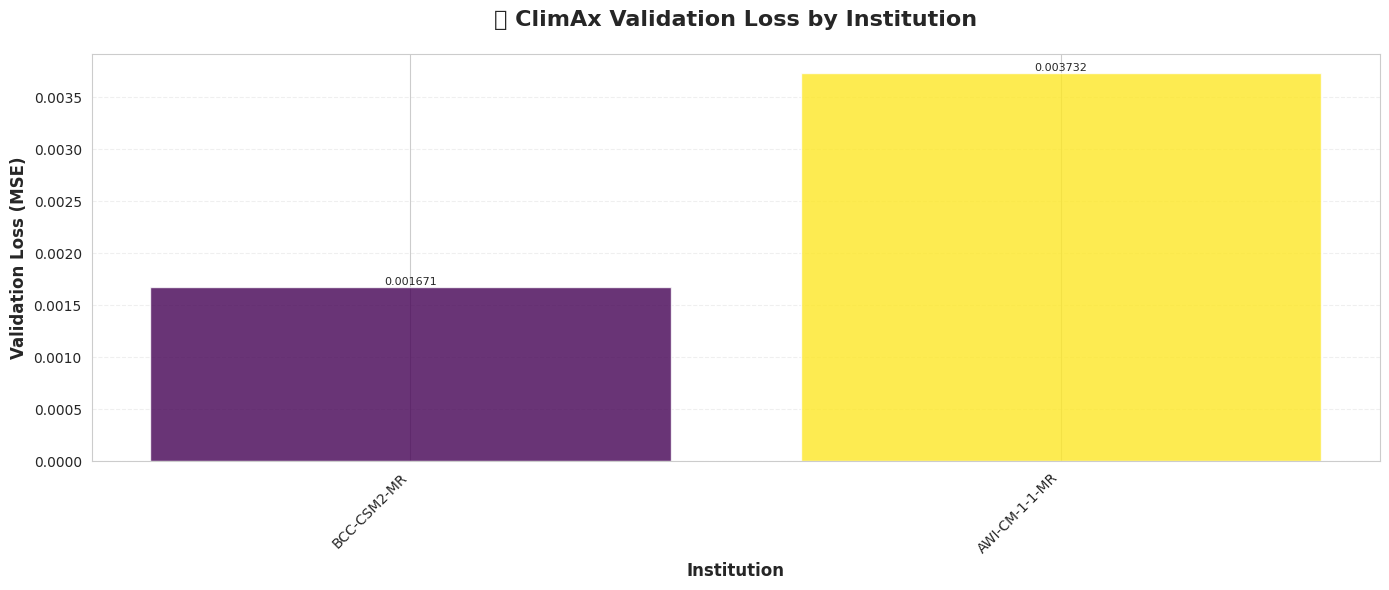

✅ Saved: 01_validation_loss_comparison.png


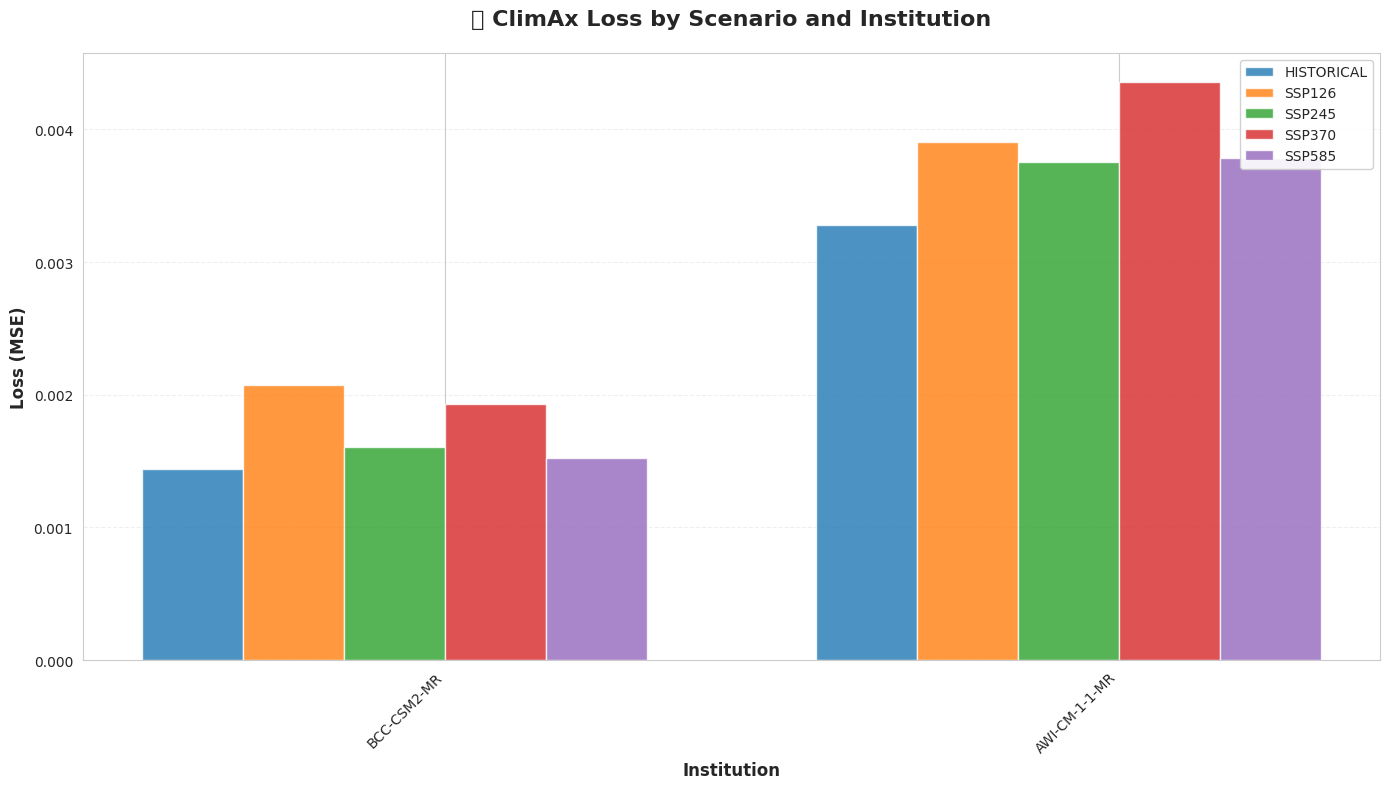

✅ Saved: 02_scenario_losses.png


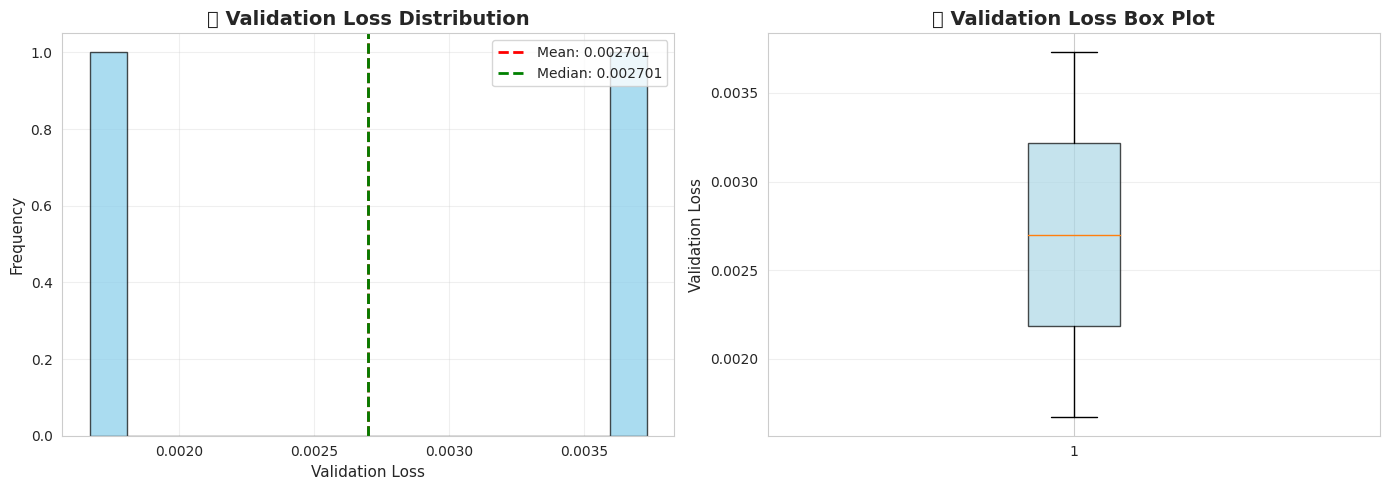

✅ Saved: 03_distribution_analysis.png


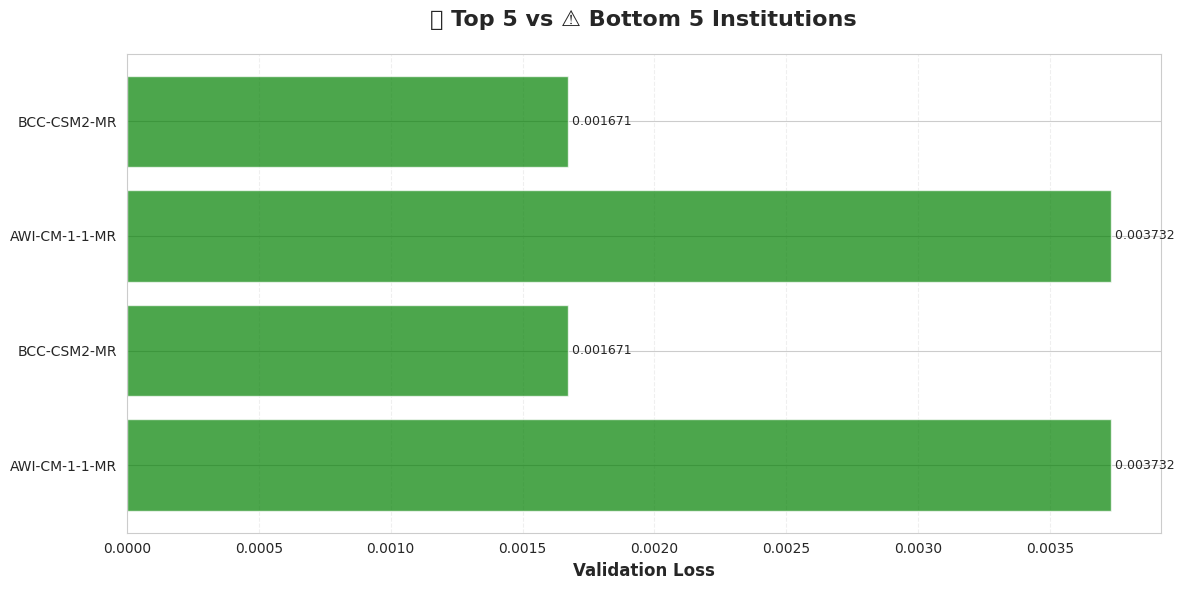

✅ Saved: 04_top_vs_bottom.png

✅ All visualizations saved to: /kaggle/working/climax_phase4_results/plots/

Step 3/6: Plotting top-K training curves...

📉 Generating training curves for top 3 institutions...


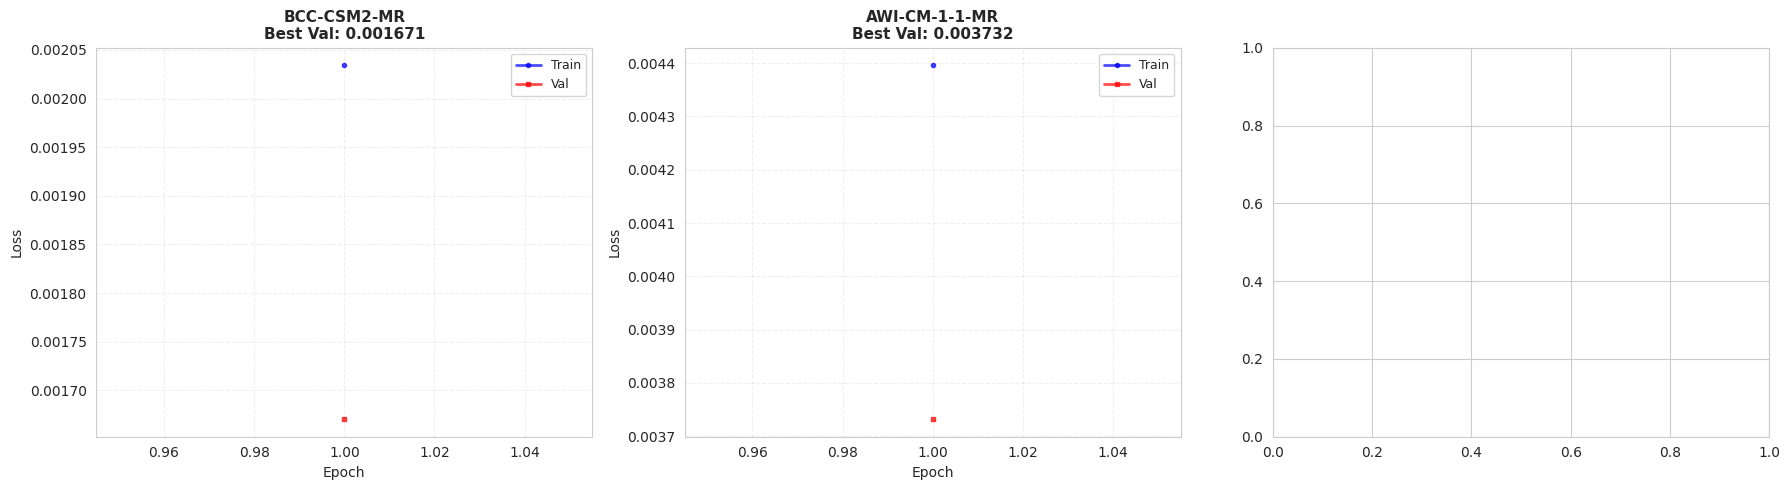

✅ Saved top 3 training curves

Step 4/6: Creating ensemble configuration...

🤝 Creating Ensemble Configuration (Top 5 institutions)
🏆 Top 5 institutions for ensemble:
  1. BCC-CSM2-MR
     Val Loss: 0.001671 | Weight: 0.6908
  2. AWI-CM-1-1-MR
     Val Loss: 0.003732 | Weight: 0.3092

💾 Ensemble configuration saved to: /kaggle/working/climax_phase4_results/climax_ensemble_config.json

Step 5/6: Generating comprehensive report...

📋 Generating comprehensive report...
✅ Report saved to: /kaggle/working/climax_phase4_results/climax_training_report.txt

📊 ClimAx Phase 4 - Comprehensive Training Report
Generated: 2025-10-23 17:53:23

📈 SUMMARY STATISTICS
--------------------------------------------------------------------------------
Total Institutions Trained: 2
Best Validation Loss: 0.00167062
Worst Validation Loss: 0.00373224
Mean Validation Loss: 0.00270143
Std Validation Loss: 0.00145778
Median Validation Loss: 0.00270143

🏆 TOP 5 PERFORMING INSTITUTIONS
-------------------------------

In [21]:
print("="*80)
print("🎯 ClimAx Phase 4 - Post-Training Analysis")
print("="*80)

# Check if training is complete
summary_path = os.path.join(OUTPUT_DIR, "logs", "phase4_training_summary.json")

if not os.path.exists(summary_path):
    print("⚠️ Training summary not found!")
    print(f"Expected path: {summary_path}")
    print("\nPlease complete training first (Section 6) before running analysis.")
else:
    print("✅ Training summary found!")
    print("\n🔄 Starting comprehensive analysis...\n")
    
    # ========================================
    # 📊 Step 1: Analyze Results
    # ========================================
    print("Step 1/6: Analyzing results...")
    df_sorted = analyze_climax_results(
        results_summary_path=summary_path,
        output_dir=OUTPUT_DIR
    )
    
    if df_sorted is not None:
        # ========================================
        # 📈 Step 2: Generate Visualizations
        # ========================================
        print("\nStep 2/6: Generating visualizations...")
        visualize_climax_results(df_sorted, output_dir=OUTPUT_DIR)
        
        # ========================================
        # 📉 Step 3: Top K Training Curves
        # ========================================
        print("\nStep 3/6: Plotting top-K training curves...")
        plot_top_k_training_curves(df_sorted, k=3, output_dir=OUTPUT_DIR)
        
        # ========================================
        # 🤝 Step 4: Create Ensemble Config
        # ========================================
        print("\nStep 4/6: Creating ensemble configuration...")
        ensemble_config = create_climax_ensemble_config(
            df_sorted, 
            top_k=5, 
            output_dir=OUTPUT_DIR
        )
        
        # ========================================
        # 📋 Step 5: Generate Report
        # ========================================
        print("\nStep 5/6: Generating comprehensive report...")
        generate_comprehensive_report(df_sorted, output_dir=OUTPUT_DIR)
        
        # ========================================
        # 💾 Step 6: Save Analysis Summary
        # ========================================
        print("\nStep 6/6: Saving analysis summary...")
        
        analysis_summary = {
            'analysis_timestamp': datetime.now().isoformat(),
            'total_institutions_analyzed': len(df_sorted),
            'best_institution': df_sorted.iloc[0]['Institution'],
            'best_val_loss': float(df_sorted.iloc[0]['Val_Loss']),
            'worst_institution': df_sorted.iloc[-1]['Institution'],
            'worst_val_loss': float(df_sorted.iloc[-1]['Val_Loss']),
            'mean_val_loss': float(df_sorted['Val_Loss'].mean()),
            'std_val_loss': float(df_sorted['Val_Loss'].std()),
            'ensemble_config': ensemble_config,
            'output_files': {
                'csv': 'climax_results_analysis.csv',
                'ensemble_config': 'climax_ensemble_config.json',
                'report': 'climax_training_report.txt',
                'plots': [
                    '01_validation_loss_comparison.png',
                    '02_scenario_losses.png',
                    '03_distribution_analysis.png',
                    '04_top_vs_bottom.png',
                    '05_top3_training_curves.png'
                ]
            }
        }
        
        analysis_path = os.path.join(OUTPUT_DIR, "climax_analysis_summary.json")
        with open(analysis_path, 'w') as f:
            json.dump(analysis_summary, f, indent=2)
        
        print(f"✅ Analysis summary saved to: {analysis_path}")
        
        # ========================================
        # 🎉 Final Summary
        # ========================================
        print("\n" + "="*80)
        print("🎉 ANALYSIS COMPLETE!")
        print("="*80)
        print(f"📁 All outputs saved to: {OUTPUT_DIR}/")
        print("\n📊 Generated Files:")
        print(f"  ├─ 📄 climax_results_analysis.csv")
        print(f"  ├─ 📄 climax_ensemble_config.json")
        print(f"  ├─ 📄 climax_training_report.txt")
        print(f"  ├─ 📄 climax_analysis_summary.json")
        print(f"  └─ 📂 plots/")
        print(f"      ├─ 01_validation_loss_comparison.png")
        print(f"      ├─ 02_scenario_losses.png")
        print(f"      ├─ 03_distribution_analysis.png")
        print(f"      ├─ 04_top_vs_bottom.png")
        print(f"      └─ 05_top3_training_curves.png")
        
        print("\n✅ You can now:")
        print("  1. Review the comprehensive report")
        print("  2. Examine the visualizations")
        print("  3. Use the ensemble config for inference")
        print("  4. Compare with ConvLSTM Phase 4 results")
        print("="*80)
        
    else:
        print("❌ Analysis failed - no valid results found!")

In [17]:
# =============================================================================
# 💾 CREATE ZIP FOR DOWNLOAD
# =============================================================================
import os
import shutil
from IPython.display import FileLink

print("="*80)
print("📦 CREATING DOWNLOADABLE ZIP ARCHIVE")
print("="*80)

# Check if output directory exists
if not os.path.exists(OUTPUT_DIR):
    print(f"❌ ERROR: Output directory not found!")
    print(f"   Path: {OUTPUT_DIR}")
    print(f"   Make sure training completed successfully.")
else:
    # Count files and calculate size
    file_count = 0
    total_size = 0
    
    for root, dirs, files in os.walk(OUTPUT_DIR):
        file_count += len(files)
        for f in files:
            try:
                total_size += os.path.getsize(os.path.join(root, f))
            except:
                pass
    
    print(f"📊 Directory Stats:")
    print(f"   Files: {file_count}")
    print(f"   Size: {total_size/(1024**2):.2f} MB")
    
    if file_count == 0:
        print(f"\n⚠️  No files to archive!")
    else:
        # Create ZIP archive
        print(f"\n🔄 Creating ZIP archive...")
        zip_base = '/kaggle/working/climax_results'
        zip_file = zip_base + '.zip'
        
        try:
            # Remove old ZIP if exists
            if os.path.exists(zip_file):
                os.remove(zip_file)
                print(f"   🗑️  Removed old ZIP")
            
            # Create new ZIP
            shutil.make_archive(zip_base, 'zip', OUTPUT_DIR)
            
            # Verify creation
            if os.path.exists(zip_file):
                zip_size = os.path.getsize(zip_file) / (1024**2)
                print(f"   ✅ ZIP created successfully!")
                print(f"\n📦 Archive Details:")
                print(f"   Location: {zip_file}")
                print(f"   Size: {zip_size:.2f} MB")
                print(f"   Files: {file_count}")
                
                # Display download link
                print(f"\n⬇️  DOWNLOAD LINK:")
                print("="*80)
                display(FileLink(zip_file))
                print("="*80)
                
            else:
                print(f"   ❌ ZIP file not found after creation")
                
        except Exception as e:
            print(f"   ❌ Error creating ZIP: {e}")
            print(f"\n💡 Alternative: Use Kaggle's 'Save Version' to commit outputs")

print("\n" + "="*80)
print("💡 REMEMBER TO SAVE PERMANENTLY:")
print("="*80)
print("Option 1: Click 'Save Version' → 'Save & Run All' (RECOMMENDED)")
print("Option 2: Download the ZIP file using the link above")
print("="*80)

📦 CREATING DOWNLOADABLE ZIP ARCHIVE
📊 Directory Stats:
   Files: 13
   Size: 10.78 MB

🔄 Creating ZIP archive...
   🗑️  Removed old ZIP
   ✅ ZIP created successfully!

📦 Archive Details:
   Location: /kaggle/working/climax_results.zip
   Size: 9.72 MB
   Files: 13

⬇️  DOWNLOAD LINK:


/kaggle/working/climax_results.zip


💡 REMEMBER TO SAVE PERMANENTLY:
Option 1: Click 'Save Version' → 'Save & Run All' (RECOMMENDED)
Option 2: Download the ZIP file using the link above


In [18]:
# Diagnostic: Check what's in your output directory
import os

print("🔍 Directory Contents:")
print("="*80)

if os.path.exists(OUTPUT_DIR):
    for root, dirs, files in os.walk(OUTPUT_DIR):
        level = root.replace(OUTPUT_DIR, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show first 5 files per directory
            size = os.path.getsize(os.path.join(root, file)) / (1024**2)
            print(f'{subindent}├─ {file} ({size:.2f} MB)')
        if len(files) > 5:
            print(f'{subindent}└─ ... and {len(files)-5} more files')
else:
    print(f"❌ Directory not found: {OUTPUT_DIR}")

🔍 Directory Contents:
climax_phase4_results/
  ├─ climax_results_analysis.csv (0.00 MB)
  checkpoints/
    ├─ BCC-CSM2-MR_final.pt (2.55 MB)
    ├─ BCC-CSM2-MR_multiscenario_best.pt (2.55 MB)
    ├─ AWI-CM-1-1-MR_multiscenario_best.pt (2.55 MB)
    ├─ AWI-CM-1-1-MR_final.pt (2.55 MB)
  logs/
    ├─ phase4_progress.json (0.00 MB)
    ├─ AWI-CM-1-1-MR_phase4_results.json (0.00 MB)
    ├─ phase4_training_summary.json (0.00 MB)
    ├─ BCC-CSM2-MR_phase4_results.json (0.00 MB)
  visualizations/
  plots/
    ├─ 02_scenario_losses.png (0.16 MB)
    ├─ 03_distribution_analysis.png (0.13 MB)
    ├─ 04_top_vs_bottom.png (0.12 MB)
    ├─ 01_validation_loss_comparison.png (0.15 MB)
  metrics/


## 🎉 Done!

Your models are now trained and saved in the `climax_phase4_results/` directory.

### 📁 Output Files:
- **Models**: `climax_phase4_results/checkpoints/*.pt`
- **Logs**: `climax_phase4_results/logs/*.json`
- **Summary**: `climax_phase4_results/logs/phase4_training_summary.json`

### 🔄 Next Steps:
1. Load trained models for inference
2. Evaluate on test set
3. Generate predictions for different scenarios
4. Visualize results